# Machine Learning Task - Idoven

##### This notebook contains the required task for the Data Scientist position at Idoven.

First we import all the used libraries

In [1]:
import os
import ast
import wfdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import neurokit2 as nk
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer

import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import layers, losses
from keras.metrics import AUC
import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, precision_recall_curve, average_precision_score, roc_curve, auc, roc_auc_score
import matplotlib.cm as cm

import warnings
warnings.filterwarnings("ignore")

Once imported the libraries, I follow the steps recommended in the physionet web to load the required data

In [2]:
path = 'physionet.org/files/ptb-xl/1.0.2/'

metadata = pd.read_csv(os.path.join(path, 'ptbxl_database.csv'), index_col='ecg_id')
metadata.scp_codes = metadata.scp_codes.apply(lambda x: ast.literal_eval(x))
metadata.patient_id = metadata.patient_id.astype(int)
metadata.nurse = metadata.nurse.astype('Int64')
metadata.site = metadata.site.astype('Int64')
metadata.validated_by = metadata.validated_by.astype('Int64')

scp_statements = pd.read_csv(os.path.join(path, 'scp_statements.csv'), index_col=0)
scp_statements = scp_statements[scp_statements.diagnostic == 1]


metadata.head()


patient_id   age  sex  height  weight  nurse  site     device   
ecg_id                                                                  
1            15709  56.0    1     NaN    63.0      2     0  CS-12   E  \
2            13243  19.0    0     NaN    70.0      2     0  CS-12   E   
3            20372  37.0    1     NaN    69.0      2     0  CS-12   E   
4            17014  24.0    0     NaN    82.0      2     0  CS-12   E   
5            17448  19.0    1     NaN    70.0      2     0  CS-12   E   

             recording_date                                  report  ...   
ecg_id                                                               ...   
1       1984-11-09 09:17:34  sinusrhythmus periphere niederspannung  ...  \
2       1984-11-14 12:55:37     sinusbradykardie sonst normales ekg  ...   
3       1984-11-15 12:49:10              sinusrhythmus normales ekg  ...   
4       1984-11-15 13:44:57              sinusrhythmus normales ekg  ...   
5       1984-11-17 10:43:15              sinusrhythmus normales ekg  ...   

       SLI-LVH QRS-CLBB ST-ELEV-MI ST-DEPR-MI  Q-ISC  Q-ISC-QPeak  Q-ISC-V2V3   
ecg_id                                                                          
1        False    False      False      False  False        False       False  \
2         True    False      False      False  False        False       False   
3        False    False      False      False  False        False       False   
4        False    False      False      False  False        False       False   
5        False    False      False      False  False        False       False   

        Q-ISC-RPeak STRAIN MI-ALL  
ecg_id                             
1             False  False  False  
2             False  False  False  
3             False  False  False  
4             False  False  False  
5             False  False  False  

[5 rows x 43 columns]

In [3]:
def diagnostic_class(scp):
    res = set()
    for k in scp.keys():
        if k in scp_statements.index:
            res.add(scp_statements.loc[k].diagnostic_class)
    return list(res)
                    
metadata['labels'] = metadata.scp_codes.apply(diagnostic_class)

In [4]:
metadata['labels'].head()

ecg_id
1    [NORM]
2    [NORM]
3    [NORM]
4    [NORM]
5    [NORM]
Name: labels, dtype: object

We stored the labels to classify in the metadata dataframe in teh 'Labels' column

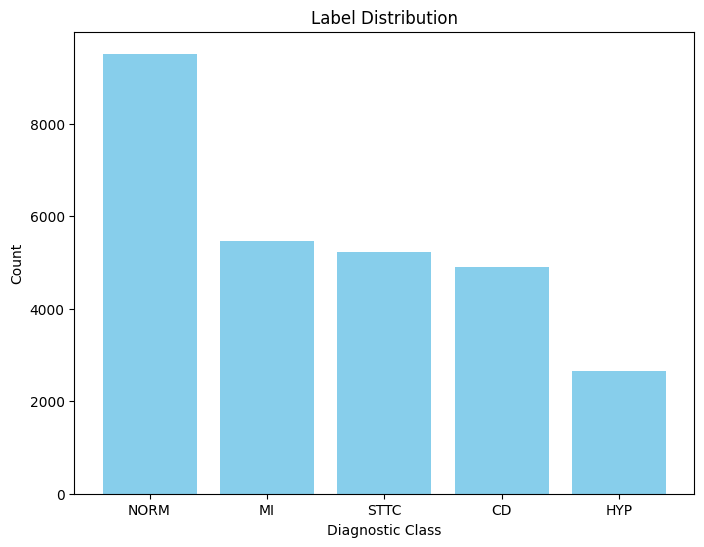

In [5]:
label_classes = ["NORM", "MI", "STTC", "CD", "HYP"]

# Flatten the lists of labels into a single list
all_labels = [label for sublist in metadata['labels'] for label in sublist]
# Count occurrences of each class
label_counts = {label: all_labels.count(label) for label in label_classes}

label_counts_df = pd.DataFrame(list(label_counts.items()), columns=['Label', 'Count'])

# Plot histogram for label distribution visualization
plt.figure(figsize=(8, 6))
plt.bar(label_counts_df['Label'], label_counts_df['Count'], color='skyblue')
plt.xlabel('Diagnostic Class')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.show()

As we can see, there is a relevant data imbalance among labels, specially between NORM and HYP. Due to the lack of time to explore this issue, I'll be overlook right now bu it would be benefitial to address it in the the future by analysing the performance of undersampling or weighting tecniques on the data.

In [58]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [59]:
fs = 100

ECGs = load_raw_data(metadata, fs, path)

Due to the lack of stong computationtal power in my laptop, I deicied to load the 100 Hz sampling frequency signals, but higher quality signals would yield better results

In [60]:
print(f'ECGs shape: {ECGs.shape}')

ECGs shape: (21801, 1000, 12)


In [61]:
def plot_ecg(ecg, leads = 12, figsize = (6,6), show_voltage = True):
    
    """
    Takes ECG waveform as input (array or df), with shape L x 12
    
    Returns a 12 lead ECG plot with matplotlib
    """
    if isinstance(ecg, np.ndarray):
        ecg = pd.DataFrame(ecg)
    
    assert leads in [8, 12], "Leads should be 8 or 12"
    
    if leads==12:
        ecg.columns = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
        num_rows = 6
    else:
        ecg.columns = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
        num_rows = 4
    
    # Define number of ECG channels and name of channels
    num_channels = len(ecg.columns)#to take the number of columns
    
    # Define time axis
    time = ecg.index.values
    #num_rows = 6
    num_cols = 2
    
    sns.set_style('darkgrid')

    fig, axs = plt.subplots(num_rows, num_cols, figsize=figsize, sharex='col')

    # Plot each channel on a separate subplot
    for i in range(num_channels):
        row = i % num_rows
        col = i // num_rows
        axs[row, col].plot(time, ecg.iloc[:, i], color='blue')
        axs[row, col].set_title(ecg.columns[i], y=1, pad=-14)
        axs[row, col].set_xlim(0, len(time))  
        axs[row, 1].set_yticks([])

    # Set common x-axis label
    fig.text(0.5, 0.04, 'Time (ms)', ha='center')

    if show_voltage == True:
        # Set common y-axis label for left column
        fig.text(0.08, 0.5, 'Voltage (mV)', va='center', rotation='vertical')

    # Adjust spacing between subplots
    fig.subplots_adjust(hspace=0, wspace=0)

    # Show the plot
    plt.show()

Once loaded the ECGs, I develop a function to have a quick plotting of the 12 leads in a similar way that is used in the cardiology department

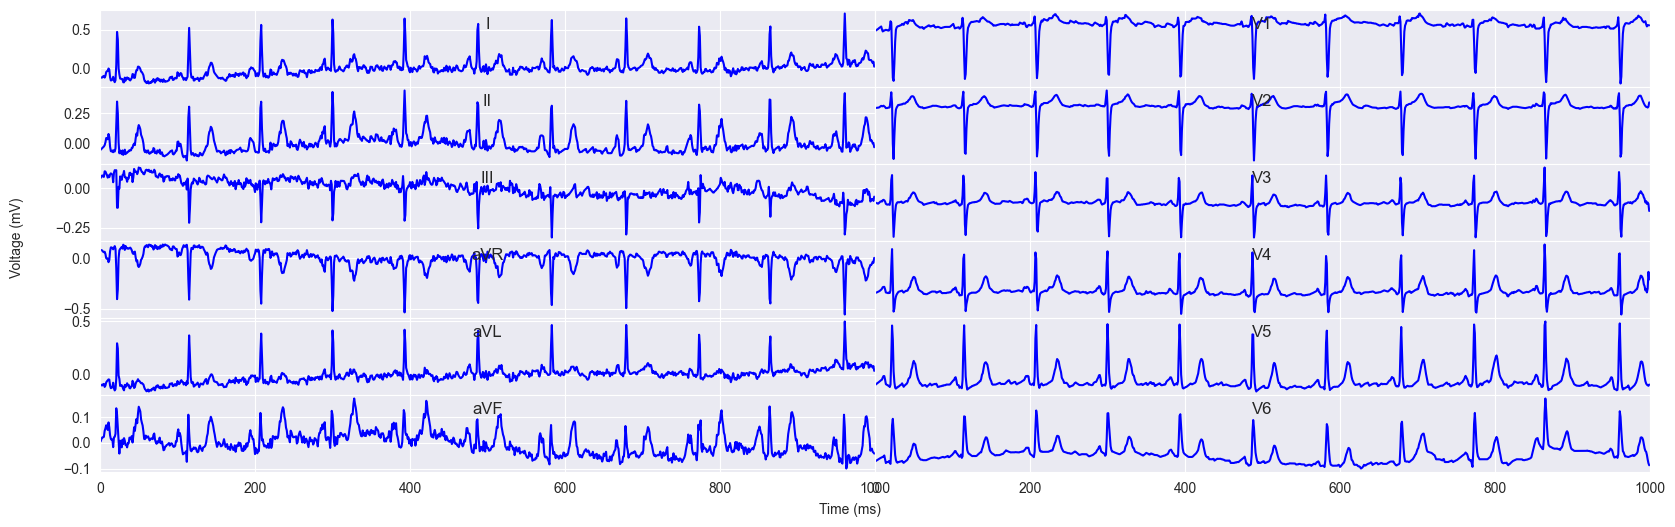

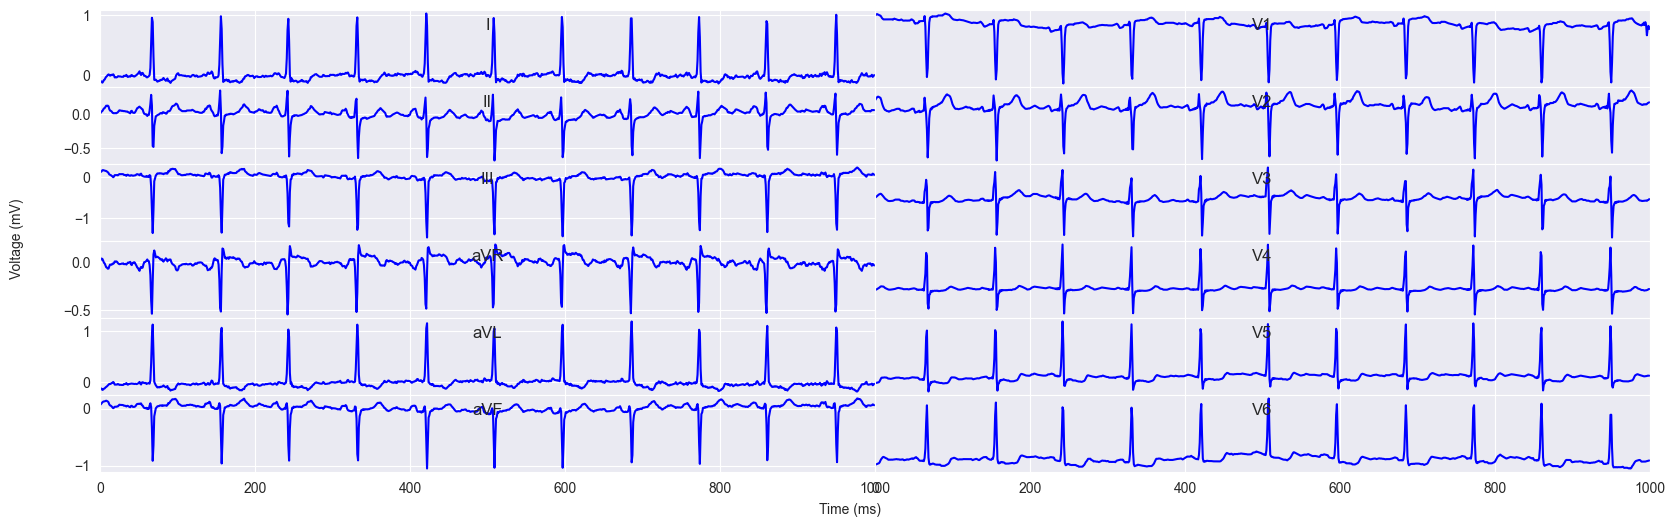

In [15]:
plot_ecg(ECGs[0,:,:], leads = 12, figsize = (20,6))
plot_ecg(ECGs[1000,:,:], leads = 12, figsize = (20,6))

As we can see, the signal presents some noise that requires filtering. Several techniques are developped and shown in the literature that are worth exploring. For the time being, the standard filtering process of the neurokit toolkit [1] is employed, which includes a 0.5 Hz high-pass butterworth filter (order = 5), followed by powerline filtering of 50 Hz.

Noisy ECG:


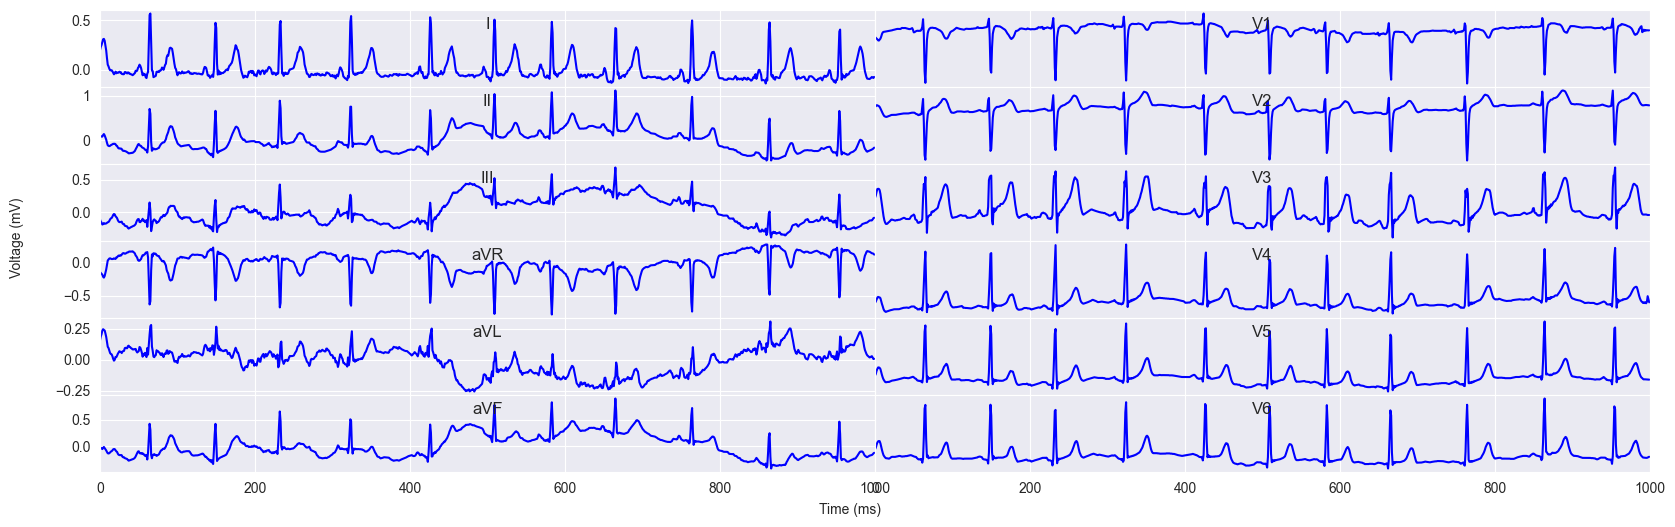

Filtered ECG:


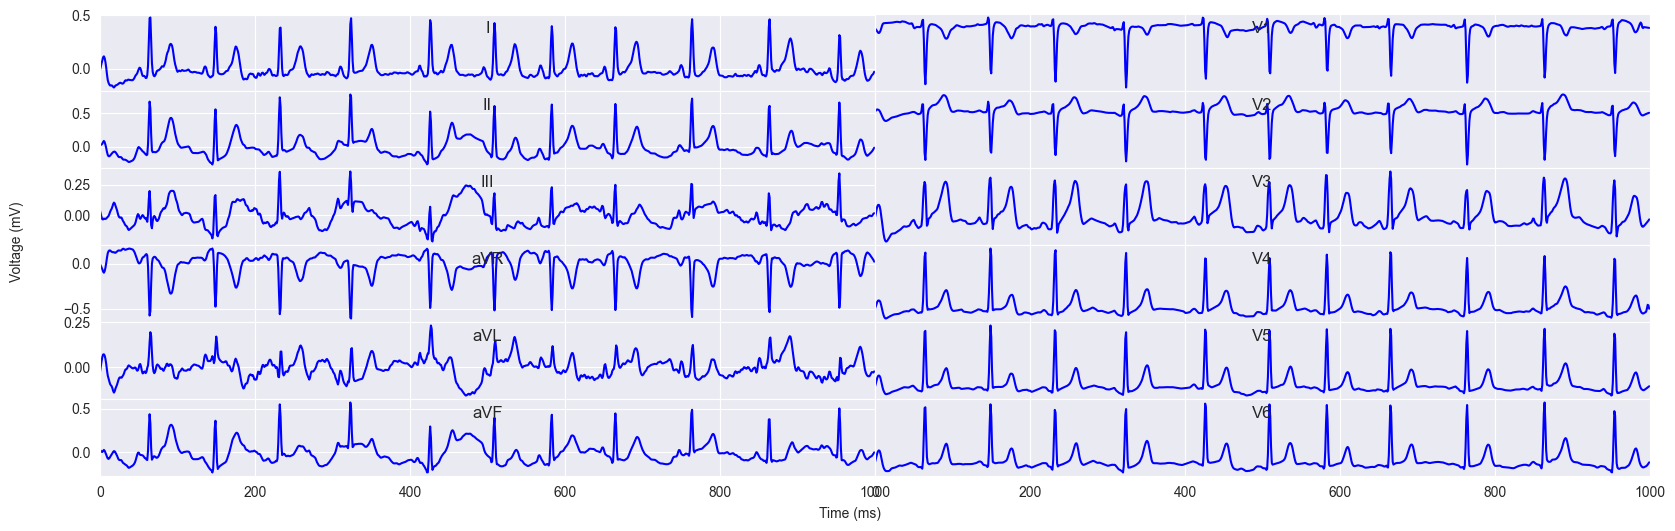

Text(0.5, 1.0, 'Lead III')

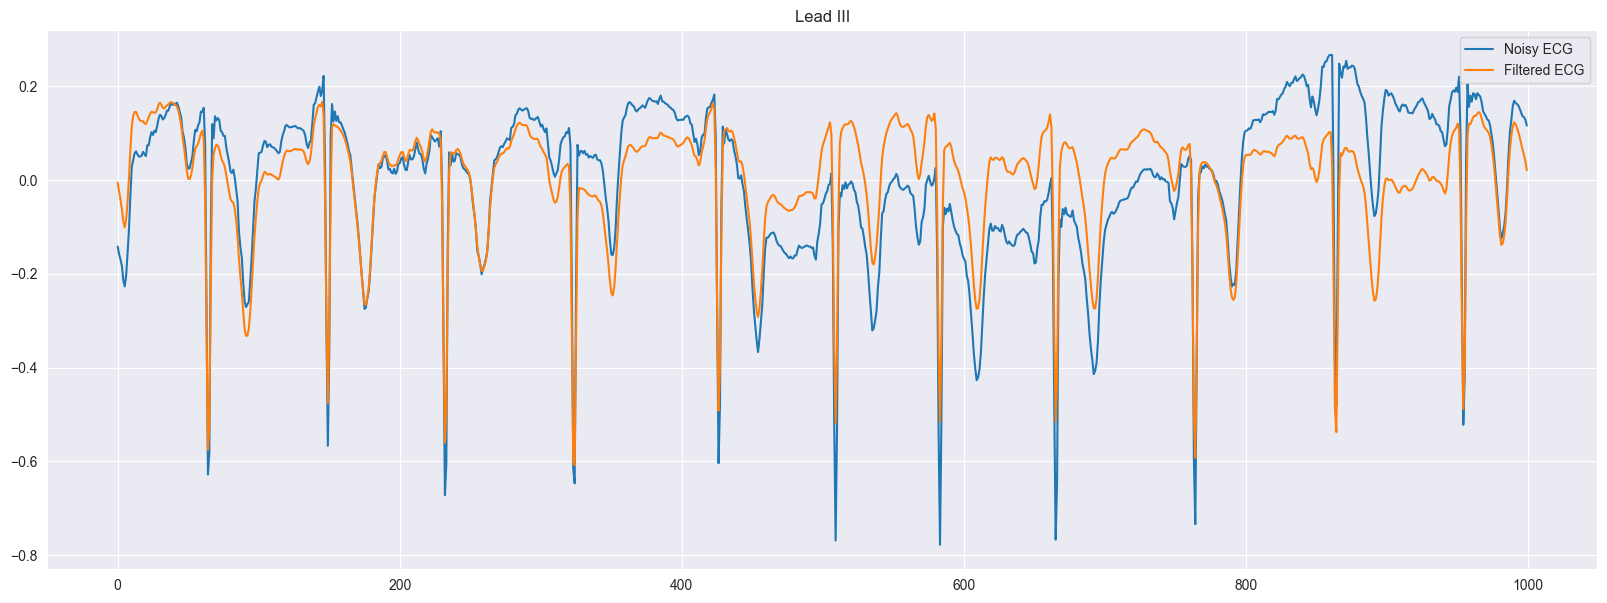

In [62]:
example_ecg_12 = ECGs[10,:,:]
print('Noisy ECG:')
plot_ecg(example_ecg_12, leads = 12, figsize = (20,6))
example_ecg_12_clean = np.zeros(example_ecg_12.shape)
for i in range(12):
    example_ecg_12_clean[:,i] = nk.ecg_clean(example_ecg_12[:,i], sampling_rate=100, method='neurokit') 

print('Filtered ECG:')
plot_ecg(example_ecg_12_clean, leads = 12, figsize = (20,6))
plt.figure(figsize=(20,7))
plt.plot(example_ecg_12[:,3], label = 'Noisy ECG')
plt.plot(example_ecg_12_clean[:,3], label = 'Filtered ECG')
plt.legend()
plt.title('Lead III')

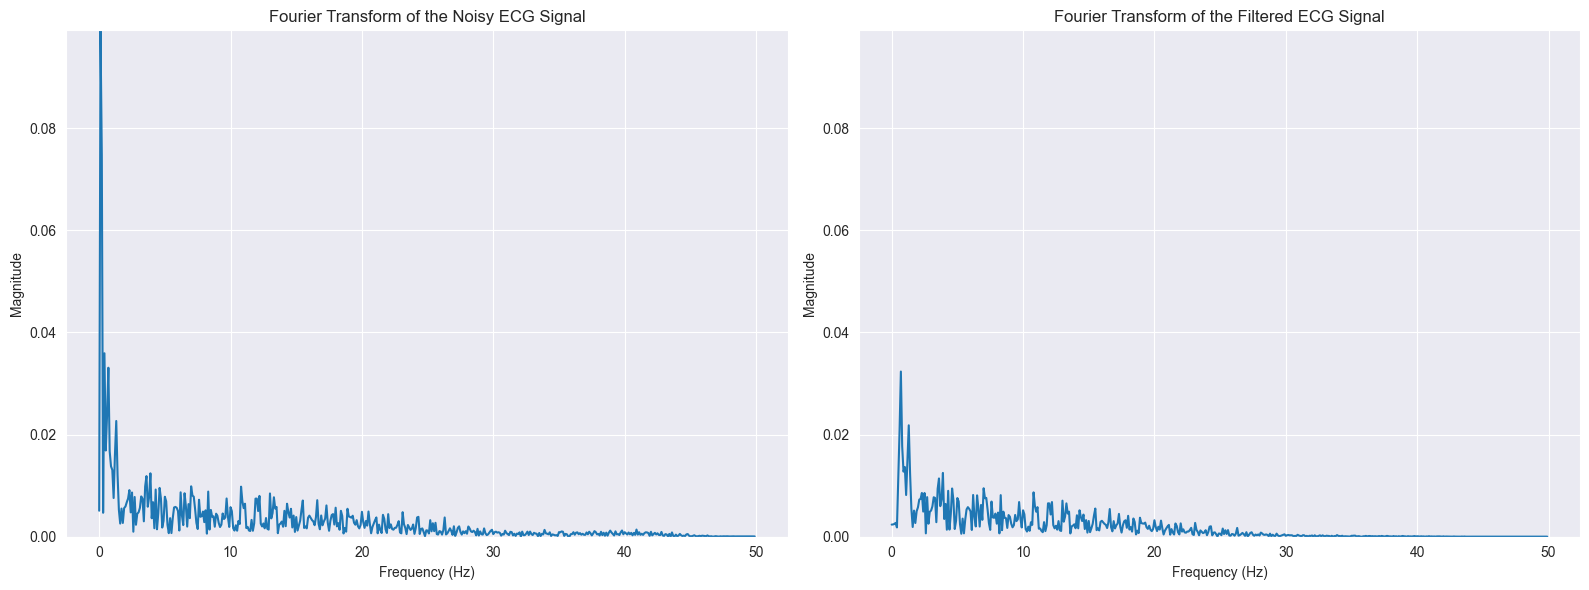

In [65]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot for noisy ECG signal
ecg_fft = fft(example_ecg_12[:, 5])
n = len(example_ecg_12[:, 5])
freqs = fftfreq(n, d=1/fs)
magnitude = np.abs(ecg_fft) / n
positive_freqs = freqs[:n // 2]
positive_magnitude = magnitude[:n // 2]

axs[0].plot(positive_freqs, positive_magnitude)
axs[0].set_title('Fourier Transform of the Noisy ECG Signal')
axs[0].set_xlabel('Frequency (Hz)')
axs[0].set_ylabel('Magnitude')
axs[0].grid(True)

# Plot for filtered ECG signal
ecg_fft_clean = fft(example_ecg_12_clean[:, 5])
n_clean = len(example_ecg_12_clean[:, 5])
freqs_clean = fftfreq(n_clean, d=1/fs)
magnitude_clean = np.abs(ecg_fft_clean) / n_clean
positive_freqs_clean = freqs_clean[:n_clean // 2]
positive_magnitude_clean = magnitude_clean[:n_clean // 2]

axs[1].plot(positive_freqs_clean, positive_magnitude_clean)
axs[1].set_title('Fourier Transform of the Filtered ECG Signal')
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('Magnitude')
axs[1].grid(True)

# Set the same y-axis limit for both subplots
max_magnitude = max(positive_magnitude.max(), positive_magnitude_clean.max())
axs[0].set_ylim(0, max_magnitude)
axs[1].set_ylim(0, max_magnitude)

# Show the plot
plt.tight_layout()
plt.show()

Fourier transform is a mathematical tool that lets you visualize signals in the frequency domain. From these plots, we can see easily that low-pass filter was strongly recommended as there was a high amount of noise in the low frequencies. On the other hand, the powerline filter was not required as it was already removed, but it is good to implement as a cautionary measure

In [19]:
N, length, leads = ECGs.shape
ECGs_clean = np.zeros(ECGs.shape)

# Loop through each ECG and clean each lead
for n in range(N):
    for i in range(leads):
        ECGs_clean[n, :, i] = nk.ecg_clean(ECGs[n, :, i], sampling_rate=100, method='neurokit')
        
# Save the cleaned ECGs as an .npy file
np.save('ECGs_clean.npy', ECGs_clean)

As this process takes some time, the filtered ECGs are stored in a npy file for later use.

In [8]:
ECGs_clean = np.load('ECGs_clean.npy')

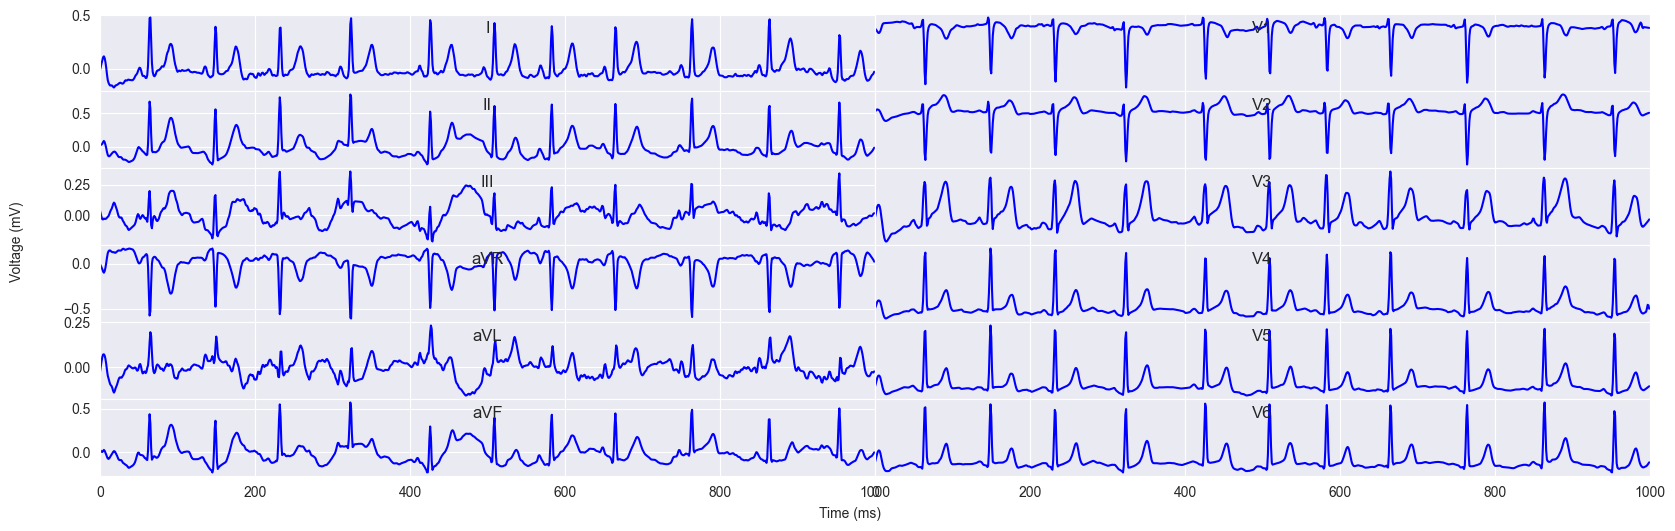

In [9]:
plot_ecg(ECGs_clean[10,:,:], leads = 12, figsize = (20,6))


On the other hand, the use of normalization is a highly encoureaged technique as it makes the classification task for the model easier. Nevertheless, the units that the ECGs present in the Y-axis are not significant anymore and can not be considered to be mV (Voltage)

In [10]:
ECG_scaler = StandardScaler()
ECG_scaler.fit(ECGs_clean.reshape(-1, ECGs_clean.shape[-1]))

ECGs_normalized = ECG_scaler.transform(ECGs_clean.reshape(-1, ECGs_clean.shape[-1])).reshape(ECGs_clean.shape)

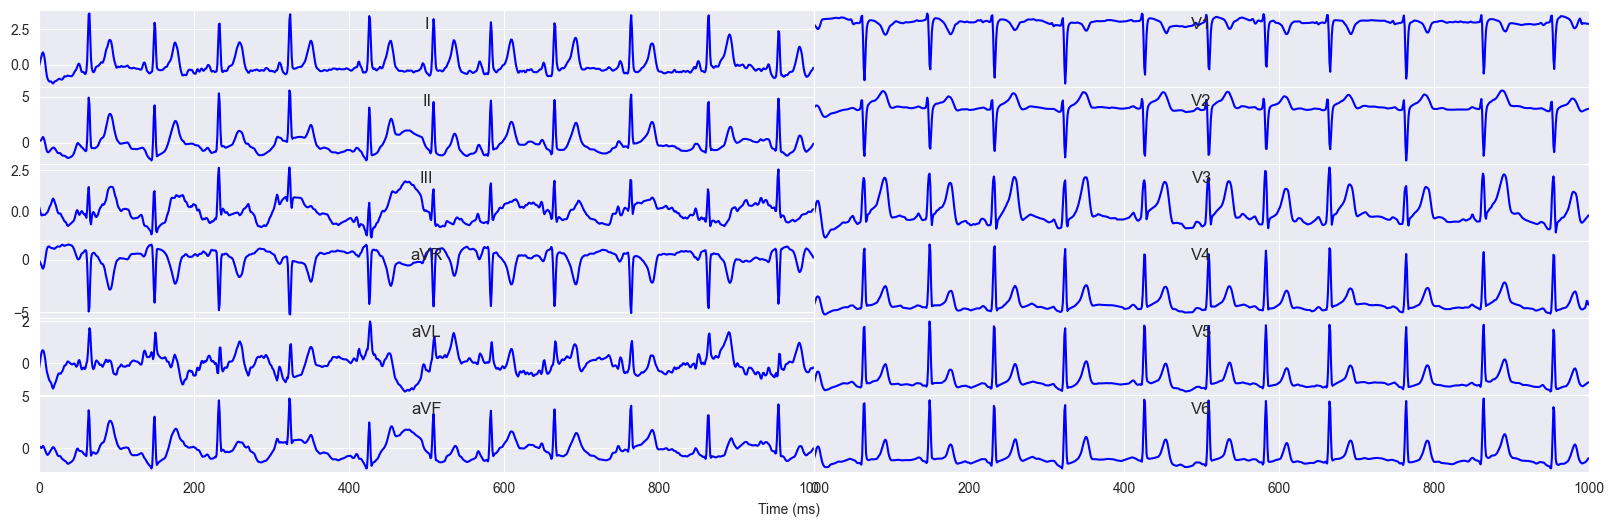

In [11]:
plot_ecg(ECGs_normalized[10,:,:], leads = 12, figsize = (20,6), show_voltage = False)

Once the ECGs are loaded, filtered and normalized, we move on to the metadata of the patients.

In these case, a lot of features were provided. Use my own criteria, I did not include in our dataframe the features that I consider that can not be available in a setting where an expert cardiologist is not present. Thus, when we include those features, the phenomenon of data leakage is produced since they are clear indicators of the presence of the disease to classify, and then improving artificially the results of the classifier.

In [76]:
features = pd.DataFrame(index=metadata.index)

features['age'] = metadata.age
features.loc[features.age > 200, 'age'] = np.nan
features.age.fillna(0, inplace=True)

features['sex'] = metadata.sex.astype(float)
features.sex.fillna(0, inplace=True)

features['height'] = metadata.height
features.loc[features.height < 50, 'height'] = np.nan
features.height.fillna(0, inplace=True)

features['weight'] = metadata.weight
features.weight.fillna(0, inplace=True)

features['pacemaker'] = (metadata.pacemaker == 'ja, pacemaker').astype(float)

heart_axis_one_hot = pd.get_dummies(metadata['heart_axis'], prefix='heart_axis', drop_first=True).astype(int)
features = pd.concat([features, heart_axis_one_hot], axis=1)

features.head()

age  sex  height  weight  pacemaker  heart_axis_ARAD  heart_axis_AXL   
ecg_id                                                                          
1       56.0  1.0     0.0    63.0        0.0                0               0  \
2       19.0  0.0     0.0    70.0        0.0                0               0   
3       37.0  1.0     0.0    69.0        0.0                0               0   
4       24.0  0.0     0.0    82.0        0.0                0               0   
5       19.0  1.0     0.0    70.0        0.0                0               0   

        heart_axis_AXR  heart_axis_LAD  heart_axis_MID  heart_axis_RAD   
ecg_id                                                                   
1                    0               0               0               0  \
2                    0               0               0               0   
3                    0               0               0               0   
4                    0               0               0               0   
5                    0               0               0               0   

        heart_axis_SAG  
ecg_id                  
1                    0  
2                    0  
3                    0  
4                    0  
5                    0

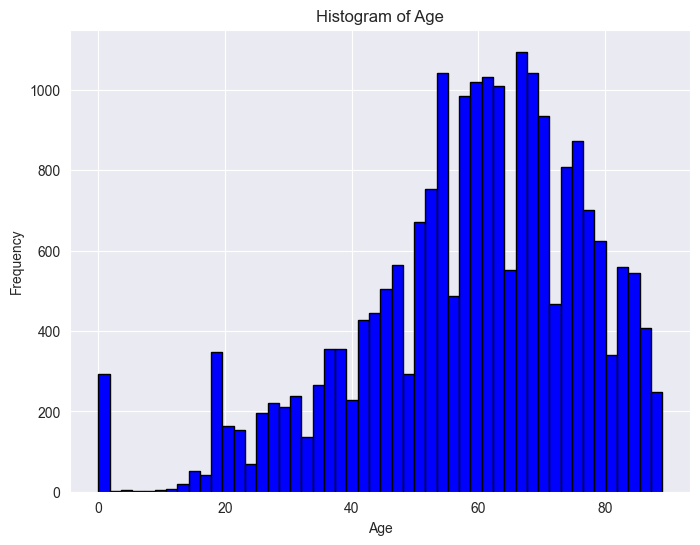

In [79]:
plt.figure(figsize=(8, 6))
plt.hist(features['age'], bins=50, color='blue', edgecolor='black')
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

As we can see, there are some cases in which the age appears to be zero. This is the result of employing outliers removal by replacing it with zeros.

After the features are loaded and selected, we normalize them as we did before via a Standard Scaler

In [80]:
scaler = StandardScaler()
features = pd.DataFrame(scaler.fit_transform(features), index=features.index, columns=features.columns)
features.head()

age       sex    height    weight  pacemaker  heart_axis_ARAD   
ecg_id                                                                       
1      -0.152091  1.042698 -0.683751  0.880889  -0.115091        -0.075017  \
2      -2.207476 -0.959051 -0.683751  1.071696  -0.115091        -0.075017   
3      -1.207559  1.042698 -0.683751  1.044438  -0.115091        -0.075017   
4      -1.929721 -0.959051 -0.683751  1.398793  -0.115091        -0.075017   
5      -2.207476  1.042698 -0.683751  1.071696  -0.115091        -0.075017   

        heart_axis_AXL  heart_axis_AXR  heart_axis_LAD  heart_axis_MID   
ecg_id                                                                   
1            -0.068223       -0.048423       -0.456817       -0.737995  \
2            -0.068223       -0.048423       -0.456817       -0.737995   
3            -0.068223       -0.048423       -0.456817       -0.737995   
4            -0.068223       -0.048423       -0.456817       -0.737995   
5            -0.068223       -0.048423       -0.456817       -0.737995   

        heart_axis_RAD  heart_axis_SAG  
ecg_id                                  
1            -0.101198       -0.011731  
2            -0.101198       -0.011731  
3            -0.101198       -0.011731  
4            -0.101198       -0.011731  
5            -0.101198       -0.011731

Later, we use a MultiLabelBinarizer to encode the labels in such a way that it can be easily understood by the ML models

In [81]:
mlb = MultiLabelBinarizer(classes=label_classes)

labels = metadata['labels']
labels_encoded = pd.DataFrame(mlb.fit_transform(labels), columns= label_classes)

labels_encoded.head(10)

NORM  MI  STTC  CD  HYP
0     1   0     0   0    0
1     1   0     0   0    0
2     1   0     0   0    0
3     1   0     0   0    0
4     1   0     0   0    0
5     1   0     0   0    0
6     1   0     0   0    0
7     0   1     0   0    0
8     1   0     0   0    0
9     1   0     0   0    0

Finally, we make use of the suggested train-test-val partition to divide the data in those categories

In [14]:
test_fold = 10
val_fold = 9

train_cond = np.where((metadata.strat_fold != test_fold) & (metadata.strat_fold != val_fold))[0]
test_cond = np.where(metadata.strat_fold == test_fold)[0]
val_cond = np.where(metadata.strat_fold == val_fold)[0]

feat_train = features.iloc[train_cond]
ecg_train =  ECGs_normalized[train_cond]
labels_train = labels_encoded.iloc[train_cond]

feat_test = features.iloc[test_cond]
ecg_test =  ECGs_normalized[test_cond]
labels_test = labels_encoded.iloc[test_cond]

feat_val = features.iloc[val_cond]
ecg_val =  ECGs_normalized[val_cond]
labels_val = labels_encoded.iloc[val_cond]

## First models

### Baseline model: Only metadata patient features

First, we train a model employing just the metadata features to use as a baseline model

In [23]:
def create_feat_model(feats, *, units=32, dropouts=0.3):
    
    X = keras.layers.Dense(units, activation='relu')(feats)
    X = keras.layers.Dropout(dropouts)(X)
    X = keras.layers.Dense(units, activation='relu')(X)
    X = keras.layers.Dropout(dropouts)(X)
    
    return X

In [16]:
def create_baseline_model(feat_shape, label_shape):
    
    inputs = keras.Input(feat_shape[1:])

    X = create_feat_model(inputs)
    X = keras.layers.Dense(32, activation='relu')(X)
    X = keras.layers.Dense(12, activation='relu')(X)
    X = keras.layers.Dropout(0.5, name='Z_drop_1')(X)
    outputs = keras.layers.Dense(label_shape[-1], activation='sigmoid')(X)

    model = keras.Model(inputs=inputs, outputs=outputs, name='model_baseline')
    return model
    

In [23]:
baseline_model = create_baseline_model(feat_train.shape, labels_train.shape)
baseline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['categorical_accuracy', 'Precision', 'Recall'])
#Instead of using the default categorical_cross_entropy for multilabel classification task, I employed binary_crossentropy as categorical_cross_entropy exploded during the training and didnt lead to any meaningful results while
# binary_crossentropy was stable during the training and lead to significant results
baseline_model.summary()

Model: "model_baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 12)             │           396 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Z_drop_1 (Dropout)              │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,989 (11.68 KB)

 Trainable params: 2,989 (11.68 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=10) 
]
history = baseline_model.fit(feat_train, labels_train, epochs=40, batch_size=32, callbacks=callbacks_list, validation_data=(feat_val, labels_val))

Epoch 1/40


545/545 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - Precision: 0.2849 - Recall: 0.1796 - categorical_accuracy: 0.3517 - loss: 1.1213 - val_Precision: 0.7359 - val_Recall: 0.1029 - val_categorical_accuracy: 0.4544 - val_loss: 0.5491
Epoch 2/40
545/545 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Precision: 0.6377 - Recall: 0.0413 - categorical_accuracy: 0.4466 - loss: 0.5760 - val_Precision: 0.7242 - val_Recall: 0.1083 - val_categorical_accuracy: 0.4544 - val_loss: 0.5355
Epoch 3/40
545/545 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Precision: 0.7787 - Recall: 0.0434 - categorical_accuracy: 0.4504 - loss: 0.5499 - val_Precision: 0.7264 - val_Recall: 0.1076 - val_categorical_accuracy: 0.4544 - val_loss: 0.5320
Epoch 4/40
545/545 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Precision: 0.7953 - Recall: 0.0482 - categorical_accuracy: 0.4537 - loss: 0.5385 - val_Precision: 0.7249 - val_Recall: 0.1087 - val_categorical_accuracy: 0.4544 - val_loss: 0.5243
Epoch 5/40
545/545 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Precision: 0.7670 - R

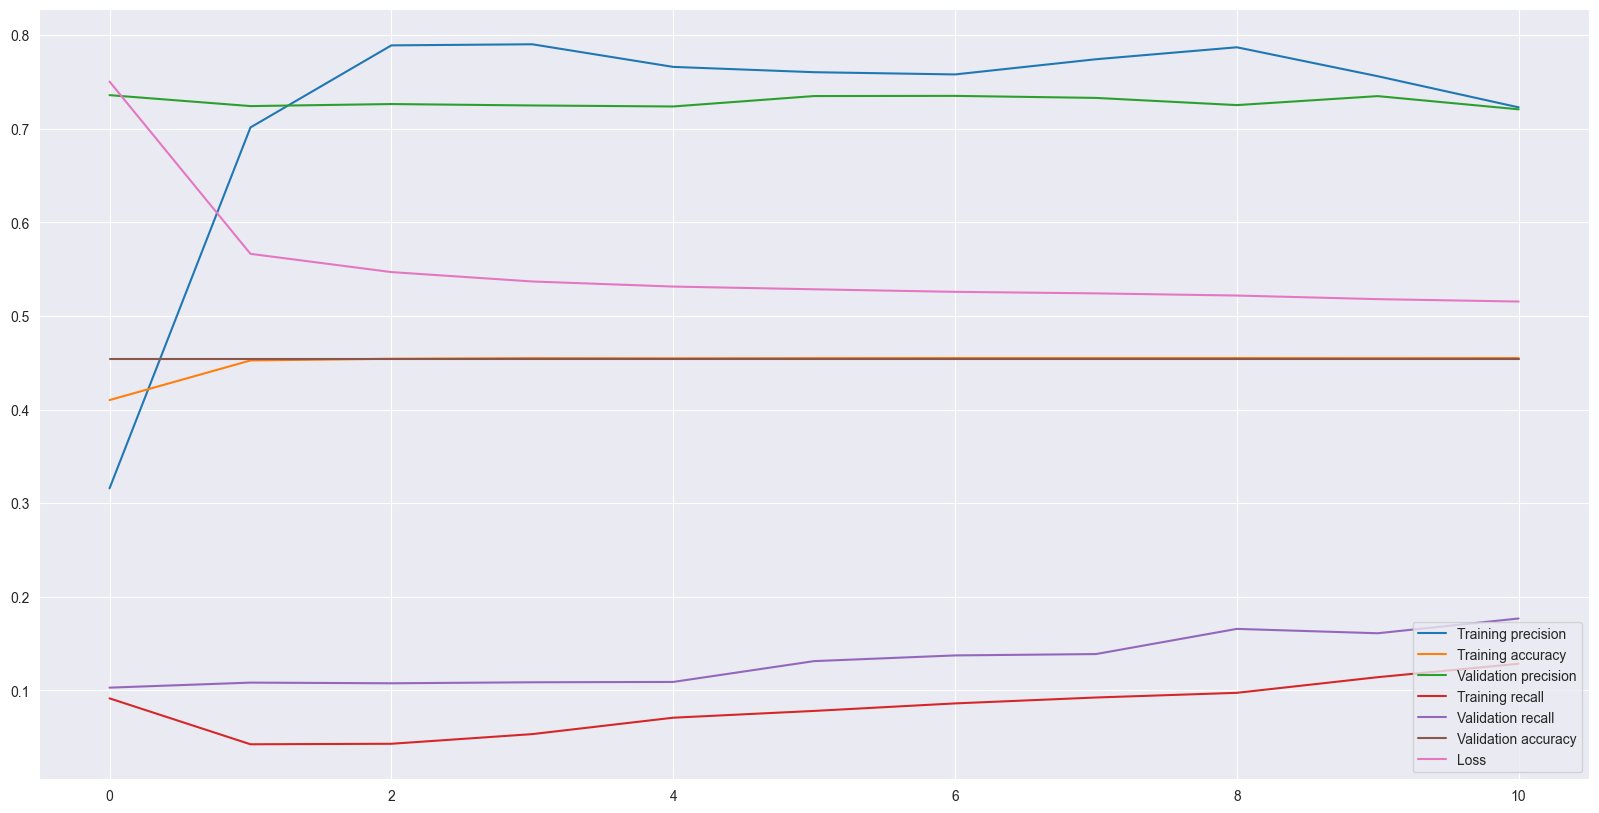

In [25]:
plt.figure(figsize=(20,10))
plt.plot(history.history['Precision'], label = 'Training precision')
plt.plot(history.history['categorical_accuracy'], label = 'Training accuracy')
plt.plot(history.history['val_Precision'], label = 'Validation precision')
plt.plot(history.history['Recall'], label = 'Training recall')
plt.plot(history.history['val_Recall'], label = 'Validation recall')
plt.plot(history.history['val_categorical_accuracy'], label = 'Validation accuracy')
plt.plot(history.history['loss'], label = 'Loss')
plt.legend()

In [26]:
print('Metadata patient model on test dataset:')
baseline_model.evaluate(feat_test, labels_test)

print('\nMetadata patient model on validation dataset:')
baseline_model.evaluate(feat_val, labels_val)

Metadata patient model on test dataset:
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Precision: 0.7487 - Recall: 0.2309 - categorical_accuracy: 0.4957 - loss: 0.4850

Metadata patient model on validation dataset:
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Precision: 0.7279 - Recall: 0.2057 - categorical_accuracy: 0.4780 - loss: 0.4966


[0.5040308237075806,
 0.4544205367565155,
 0.7207602262496948,
 0.1768292635679245]

We saved the model for later analysis

In [27]:
baseline_model.save('baseline_model.keras') 

### CNN + Metadata model

As a first attempt, I developped a simple CNN model to analyse the signal, and later be concatenated to the feature model to be used as a starting point for the classifier

In [24]:
def create_CNN_ECG_model(X, *, filters=(32, 64, 128), kernel_size=(5, 3, 3), strides=(1, 1, 1)):
    
    f1, f2, f3 = filters
    k1, k2, k3 = kernel_size
    s1, s2, s3 = strides
    
    X = keras.layers.Conv1D(f1, k1, strides=s1, padding='same')(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.ReLU()(X)

    X = keras.layers.MaxPool1D(2)(X)

    X = keras.layers.Conv1D(f2, k2, strides=s2, padding='same')(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.ReLU()(X)

    X = keras.layers.MaxPool1D(2)(X)

    X = keras.layers.Conv1D(f3, k3, strides=s3, padding='same')(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.ReLU()(X)

    X = keras.layers.GlobalAveragePooling1D()(X)
    X = keras.layers.Dropout(0.5)(X)

    return X

In [25]:
def create_CNN_feat_model(feat_shape, ecg_shape, label_shape):
    feat_inputs = keras.Input(feat_shape[1:])
    ecg_inputs = keras.Input(ecg_shape[1:])

    model_feat = create_feat_model(feat_inputs)
    model_CNN_ecgs = create_CNN_ECG_model(ecg_inputs, filters=(64, 128, 256), kernel_size=(7, 3, 3))
    
    X = keras.layers.Concatenate()([model_feat,model_CNN_ecgs])
    
    X = keras.layers.Dense(64, activation='relu')(X)
    X = keras.layers.Dense(64, activation='relu')(X)
    X = keras.layers.Dropout(0.5)(X)
    outputs = keras.layers.Dense(label_shape[-1], activation='softmax')(X)

    model = keras.Model(inputs=[feat_inputs, ecg_inputs], outputs=outputs, name='modelCNN')
    return model

In [30]:
modelCNN = create_CNN_feat_model(feat_train.shape, ecg_train.shape, labels_train.shape)
modelCNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['categorical_accuracy', 'Precision', 'Recall'])
modelCNN.summary()

Model: "modelCNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 1000, 12)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1000, 64)  │      5,440 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1000, 64)  │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 1000, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 500, 64)   │          0 │ re_lu[0][0]       │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 500, 128)  │     24,704 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 500, 128)  │        512 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 500, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 250, 128)  │          0 │ re_lu_1[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 250, 256)  │     98,560 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 32)        │        416 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 250, 256)  │      1,024 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 32)        │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 250, 256)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 32)        │      1,056 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ re_lu_2[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 32)        │          0 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 256)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 288)       │          0 │ dropout_5[0][0],  │
│ (Concatenate)       │                   │            │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 154,949 (605.27 KB)

 Trainable params: 154,053 (601.77 KB)

 Non-trainable params: 896 (3.50 KB)

In [31]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=20)]

history = modelCNN.fit([feat_train, ecg_train], labels_train, epochs=100, batch_size=32, callbacks=callbacks_list, validation_data=([feat_val, ecg_val], labels_val))

Epoch 1/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 54s 91ms/step - Precision: 0.5627 - Recall: 0.2331 - categorical_accuracy: 0.4209 - loss: 0.7294 - val_Precision: 0.7871 - val_Recall: 0.4258 - val_categorical_accuracy: 0.6244 - val_loss: 0.3609
Epoch 2/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 53s 96ms/step - Precision: 0.7706 - Recall: 0.4121 - categorical_accuracy: 0.6262 - loss: 0.3976 - val_Precision: 0.8163 - val_Recall: 0.5258 - val_categorical_accuracy: 0.6770 - val_loss: 0.3306
Epoch 3/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 57s 105ms/step - Precision: 0.7912 - Recall: 0.4902 - categorical_accuracy: 0.6560 - loss: 0.3662 - val_Precision: 0.7755 - val_Recall: 0.5352 - val_categorical_accuracy: 0.6551 - val_loss: 0.3441
Epoch 4/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 55s 100ms/step - Precision: 0.8050 - Recall: 0.5142 - categorical_accuracy: 0.6779 - loss: 0.3428 - val_Precision: 0.8122 - val_Recall: 0.5506 - val_categorical_accuracy: 0.6940 - val_loss: 0.3156
Epoch 5/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 54s 99ms/

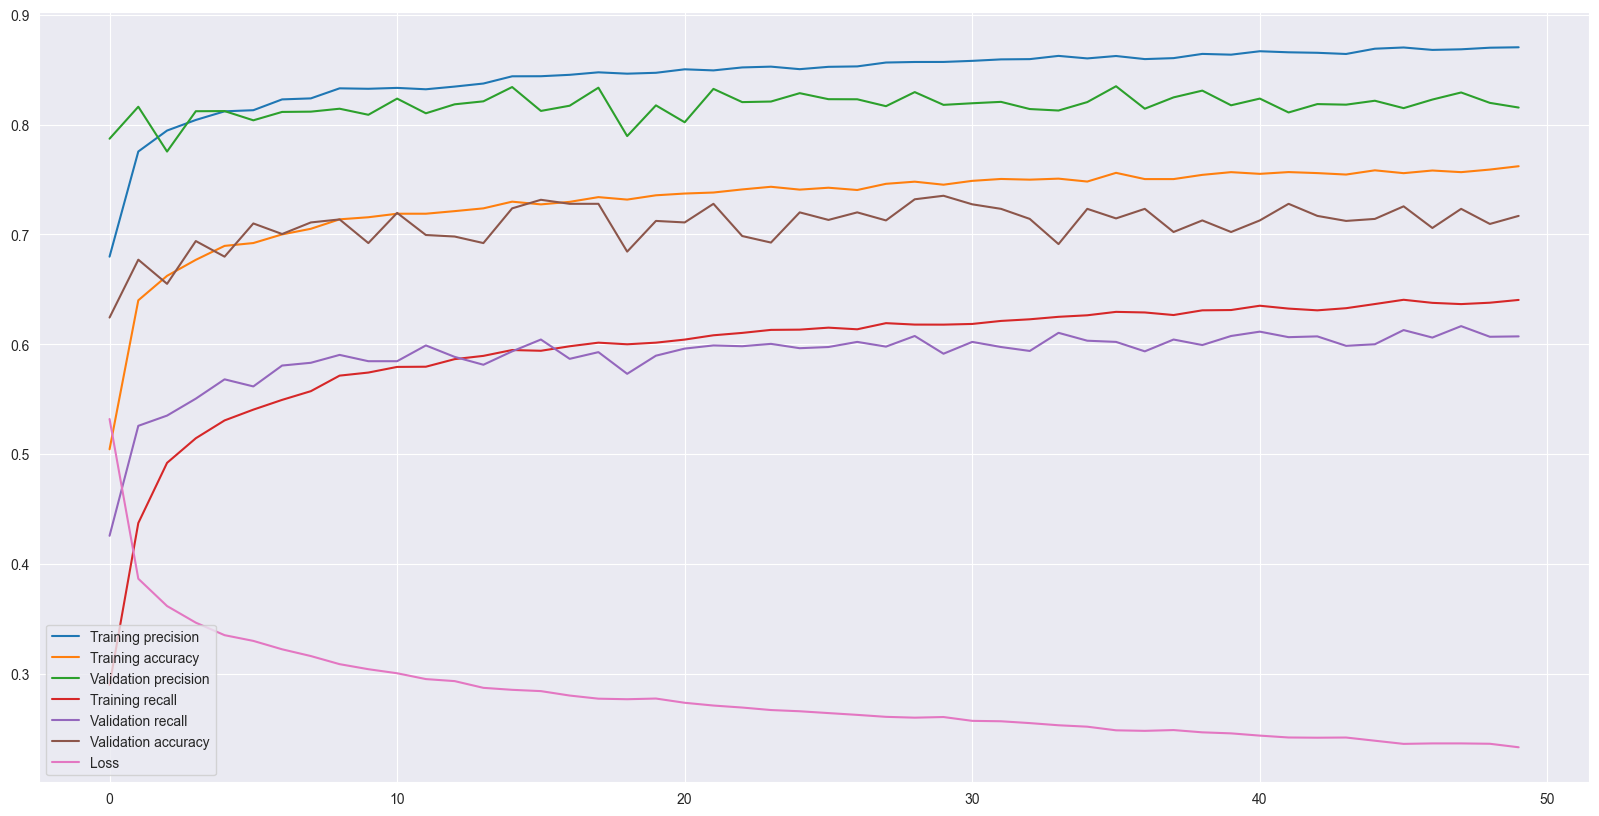

In [32]:
plt.figure(figsize=(20,10))
plt.plot(history.history['Precision'], label = 'Training precision')
plt.plot(history.history['categorical_accuracy'], label = 'Training accuracy')
plt.plot(history.history['val_Precision'], label = 'Validation precision')
plt.plot(history.history['Recall'], label = 'Training recall')
plt.plot(history.history['val_Recall'], label = 'Validation recall')
plt.plot(history.history['val_categorical_accuracy'], label = 'Validation accuracy')
plt.plot(history.history['loss'], label = 'Loss')
plt.legend()

In [33]:
modelCNN.save('modelCNN.keras') 

### CNN with residuals + Metadata models

Secondly, as it is highly employed in the literature, I developped a deep learning model that makes use of residual layers to extract more complex patterns from the signals

In [26]:
def residual_unit(unit, input_layer):
    s = '_' + str(unit)
    layer = keras.layers.Conv1D(name='Conv1' + s, filters=32, kernel_size=5, strides=1, padding='same', activation='relu')(input_layer)
    layer = keras.layers.Conv1D(name='Conv2' + s, filters=32, kernel_size=5, strides=1, padding='same', activation=None)(layer)
    layer = keras.layers.Add(name='ResidualSum' + s)([layer, input_layer])
    layer = keras.layers.Activation("relu", name='Act' + s)(layer)
    layer = keras.layers.MaxPooling1D(name='MaxPool' + s, pool_size=5, strides=2)(layer)
    return layer

In [27]:
def CNN_residual(input_layer, num_classes=5):
    
    # Initial Conv layer
    current_layer = keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu')(input_layer)

    # 5 Residual Blocks
    for i in range(5):
        current_layer = residual_unit(i + 1, current_layer)

    # Flatten the layers
    output = keras.layers.Flatten()(current_layer)

    return output


In [28]:
def create_CNN_residual_model(feat_shape, ecg_shape, label_shape):
    feat_inputs = keras.Input(feat_shape[1:])
    ecg_inputs = keras.Input(ecg_shape[1:])

    model_feat = create_feat_model(feat_inputs)
    model_CNN_residual = CNN_residual(ecg_inputs)
    
    X = keras.layers.Concatenate()([model_feat,model_CNN_residual])
    
    X = keras.layers.Dense(64, activation='relu')(X)
    X = keras.layers.Dense(64, activation='relu')(X)
    X = keras.layers.Dropout(0.5)(X)
    outputs = keras.layers.Dense(label_shape[-1], activation='softmax')(X)

    model = keras.Model(inputs=[feat_inputs, ecg_inputs], outputs=outputs, name='modelCNN_residuals')
    return model

In [37]:
modelCNN_residual = create_CNN_residual_model(feat_train.shape, ecg_train.shape, labels_train.shape)
modelCNN_residual.compile(optimizer='adam', loss='binary_crossentropy', metrics=['categorical_accuracy', 'Precision', 'Recall'])
modelCNN_residual.summary()

Model: "modelCNN_residuals"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 1000, 12)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 1000, 32)  │      1,952 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_1 (Conv1D)    │ (None, 1000, 32)  │      5,152 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2_1 (Conv1D)    │ (None, 1000, 32)  │      5,152 │ Conv1_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ResidualSum_1 (Add) │ (None, 1000, 32)  │          0 │ Conv2_1[0][0],    │
│                     │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Act_1 (Activation)  │ (None, 1000, 32)  │          0 │ ResidualSum_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MaxPool_1           │ (None, 498, 32)   │          0 │ Act_1[0][0]       │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_2 (Conv1D)    │ (None, 498, 32)   │      5,152 │ MaxPool_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2_2 (Conv1D)    │ (None, 498, 32)   │      5,152 │ Conv1_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ResidualSum_2 (Add) │ (None, 498, 32)   │          0 │ Conv2_2[0][0],    │
│                     │                   │            │ MaxPool_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Act_2 (Activation)  │ (None, 498, 32)   │          0 │ ResidualSum_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MaxPool_2           │ (None, 247, 32)   │          0 │ Act_2[0][0]       │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_3 (Conv1D)    │ (None, 247, 32)   │      5,152 │ MaxPool_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2_3 (Conv1D)    │ (None, 247, 32)   │      5,152 │ Conv1_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ResidualSum_3 (Add) │ (None, 247, 32)   │          0 │ Conv2_3[0][0],    │
│                     │                   │            │ MaxPool_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Act_3 (Activation)  │ (None, 247, 32)   │          0 │ ResidualSum_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MaxPool_3           │ (None, 122, 32)   │          0 │ Act_3[0][0]       │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_4 (Conv1D)    │ (None, 122, 32)   │      5,152 │ MaxPool_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2_4 (Conv1D)    │ (None, 122, 32)   │      5,152 │ Conv1_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ResidualSum_4 (Add) │ (None, 122, 32)   │          0 │ Conv2_4[0][0],    │
│                     │                   │            │ MaxPool_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Act_4 (Activation)  │ (None, 122, 32)   │          0 │ ResidualSum_4[0]

 Total params: 118,885 (464.39 KB)

 Trainable params: 118,885 (464.39 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=20)]

history = modelCNN_residual.fit([feat_train, ecg_train], labels_train, epochs=100, batch_size=32, callbacks=callbacks_list, validation_data=([feat_val, ecg_val], labels_val))

Epoch 1/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 78s 87ms/step - Precision: 0.6259 - Recall: 0.2123 - categorical_accuracy: 0.4394 - loss: 0.6269 - val_Precision: 0.8010 - val_Recall: 0.3002 - val_categorical_accuracy: 0.5383 - val_loss: 0.4269
Epoch 2/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 43s 78ms/step - Precision: 0.8124 - Recall: 0.2888 - categorical_accuracy: 0.5637 - loss: 0.4295 - val_Precision: 0.7704 - val_Recall: 0.3153 - val_categorical_accuracy: 0.6161 - val_loss: 0.4109
Epoch 3/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 43s 79ms/step - Precision: 0.8165 - Recall: 0.3025 - categorical_accuracy: 0.5946 - loss: 0.4110 - val_Precision: 0.7525 - val_Recall: 0.3271 - val_categorical_accuracy: 0.6170 - val_loss: 0.4254
Epoch 4/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - Precision: 0.8325 - Recall: 0.3020 - categorical_accuracy: 0.6117 - loss: 0.3970 - val_Precision: 0.7862 - val_Recall: 0.3138 - val_categorical_accuracy: 0.6244 - val_loss: 0.3980
Epoch 5/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 25s 46ms/st

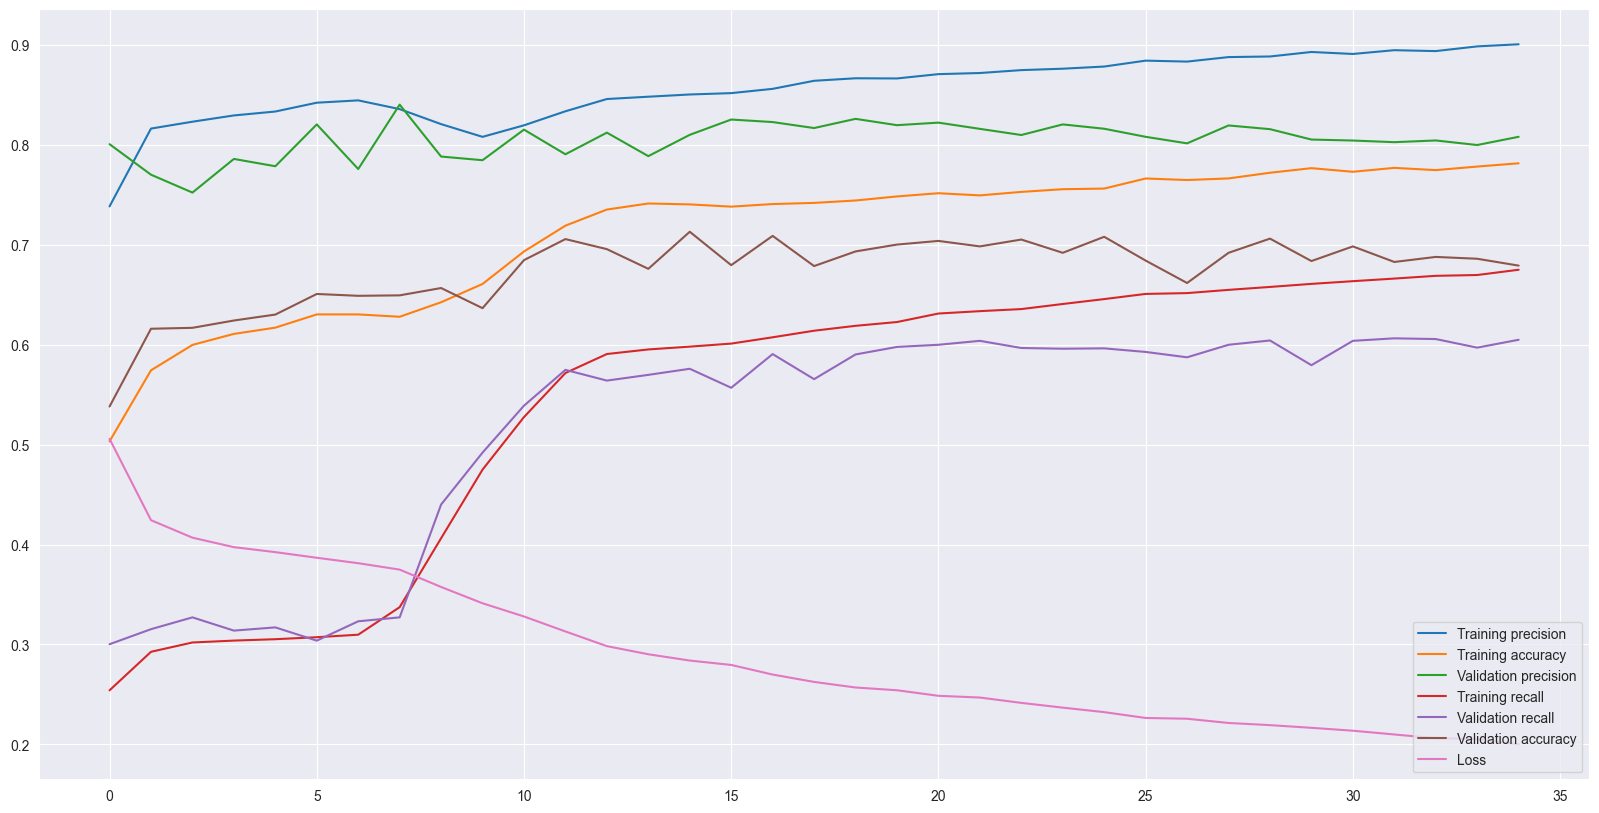

In [39]:
plt.figure(figsize=(20,10))
plt.plot(history.history['Precision'], label = 'Training precision')
plt.plot(history.history['categorical_accuracy'], label = 'Training accuracy')
plt.plot(history.history['val_Precision'], label = 'Validation precision')
plt.plot(history.history['Recall'], label = 'Training recall')
plt.plot(history.history['val_Recall'], label = 'Validation recall')
plt.plot(history.history['val_categorical_accuracy'], label = 'Validation accuracy')
plt.plot(history.history['loss'], label = 'Loss')
plt.legend()

In [40]:
modelCNN_residual.save('modelCNN_residual.keras') 

### LSTM

Another idea is to make use of LSTM as it is able to extract significant patterns in Time-Series. For that purpose, I also developped a simple LSTM model to be used on our ECGs signals

In [96]:
def RNN_LSTM_ECG_model(X):
    
    X = keras.layers.LSTM(32, return_sequences=True, input_shape=X.shape)(X)
    X = keras.layers.LSTM(32)(X)
    
    return X

In [97]:
def create_LSTM_model(feat_shape, ecg_shape, label_shape):
    
    feat_inputs = keras.Input(feat_shape[1:])
    ecg_inputs = keras.Input(ecg_shape[1:])

    model_feat = create_feat_model(feat_inputs)
    model_LSTM = RNN_LSTM_ECG_model(ecg_inputs)
    
    X = keras.layers.Concatenate()([model_feat, model_LSTM])
    
    X = keras.layers.Dense(64, activation='relu')(X)
    X = keras.layers.Dense(64, activation='relu')(X)
    X = keras.layers.Dropout(0.5)(X)
    outputs = keras.layers.Dense(label_shape[-1], activation='softmax')(X)

    model = keras.Model(inputs=[feat_inputs, ecg_inputs], outputs=outputs, name='modelLSTM')
    return model

In [98]:
modelLSTM = create_LSTM_model(feat_train.shape, ecg_train.shape, labels_train.shape)
modelLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['categorical_accuracy', 'Precision', 'Recall'])
modelLSTM.summary()

Model: "modelLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26      │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_64 (Dense)    │ (None, 32)        │        416 │ input_layer_26[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_41          │ (None, 32)        │          0 │ dense_64[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_27      │ (None, 1000, 12)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_65 (Dense)    │ (None, 32)        │      1,056 │ dropout_41[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_16 (LSTM)      │ (None, 1000, 32)  │      5,760 │ input_layer_27[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_42          │ (None, 32)        │          0 │ dense_65[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_17 (LSTM)      │ (None, 32)        │      8,320 │ lstm_16[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 64)        │          0 │ dropout_42[0][0], │
│ (Concatenate)       │                   │            │ lstm_17[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_66 (Dense)    │ (None, 64)        │      4,160 │ concatenate_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_67 (Dense)    │ (None, 64)        │      4,160 │ dense_66[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_43          │ (None, 64)        │          0 │ dense_67[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_68 (Dense)    │ (None, 5)         │        325 │ dropout_43[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,197 (94.52 KB)

 Trainable params: 24,197 (94.52 KB)

 Non-trainable params: 0 (0.00 B)

In [99]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=5)]

history = modelLSTM.fit([feat_train, ecg_train], labels_train, epochs=30, batch_size=32, callbacks=callbacks_list, validation_data=([feat_val, ecg_val], labels_val))

Epoch 1/30
545/545 ━━━━━━━━━━━━━━━━━━━━ 297s 536ms/step - Precision: 0.3806 - Recall: 0.1517 - categorical_accuracy: 0.3185 - loss: 1.0531 - val_Precision: 0.6812 - val_Recall: 0.2805 - val_categorical_accuracy: 0.5680 - val_loss: 0.4829
Epoch 2/30
545/545 ━━━━━━━━━━━━━━━━━━━━ 294s 540ms/step - Precision: 0.6731 - Recall: 0.2125 - categorical_accuracy: 0.4705 - loss: 0.5162 - val_Precision: 0.7249 - val_Recall: 0.1087 - val_categorical_accuracy: 0.4498 - val_loss: 0.5305
Epoch 3/30
545/545 ━━━━━━━━━━━━━━━━━━━━ 288s 527ms/step - Precision: 0.6687 - Recall: 0.1038 - categorical_accuracy: 0.4347 - loss: 0.5371 - val_Precision: 0.7094 - val_Recall: 0.1628 - val_categorical_accuracy: 0.4668 - val_loss: 0.5134
Epoch 4/30
545/545 ━━━━━━━━━━━━━━━━━━━━ 290s 532ms/step - Precision: 0.6735 - Recall: 0.1474 - categorical_accuracy: 0.4664 - loss: 0.5221 - val_Precision: 0.7215 - val_Recall: 0.1589 - val_categorical_accuracy: 0.4663 - val_loss: 0.5124
Epoch 5/30
545/545 ━━━━━━━━━━━━━━━━━━━━ 298s 547

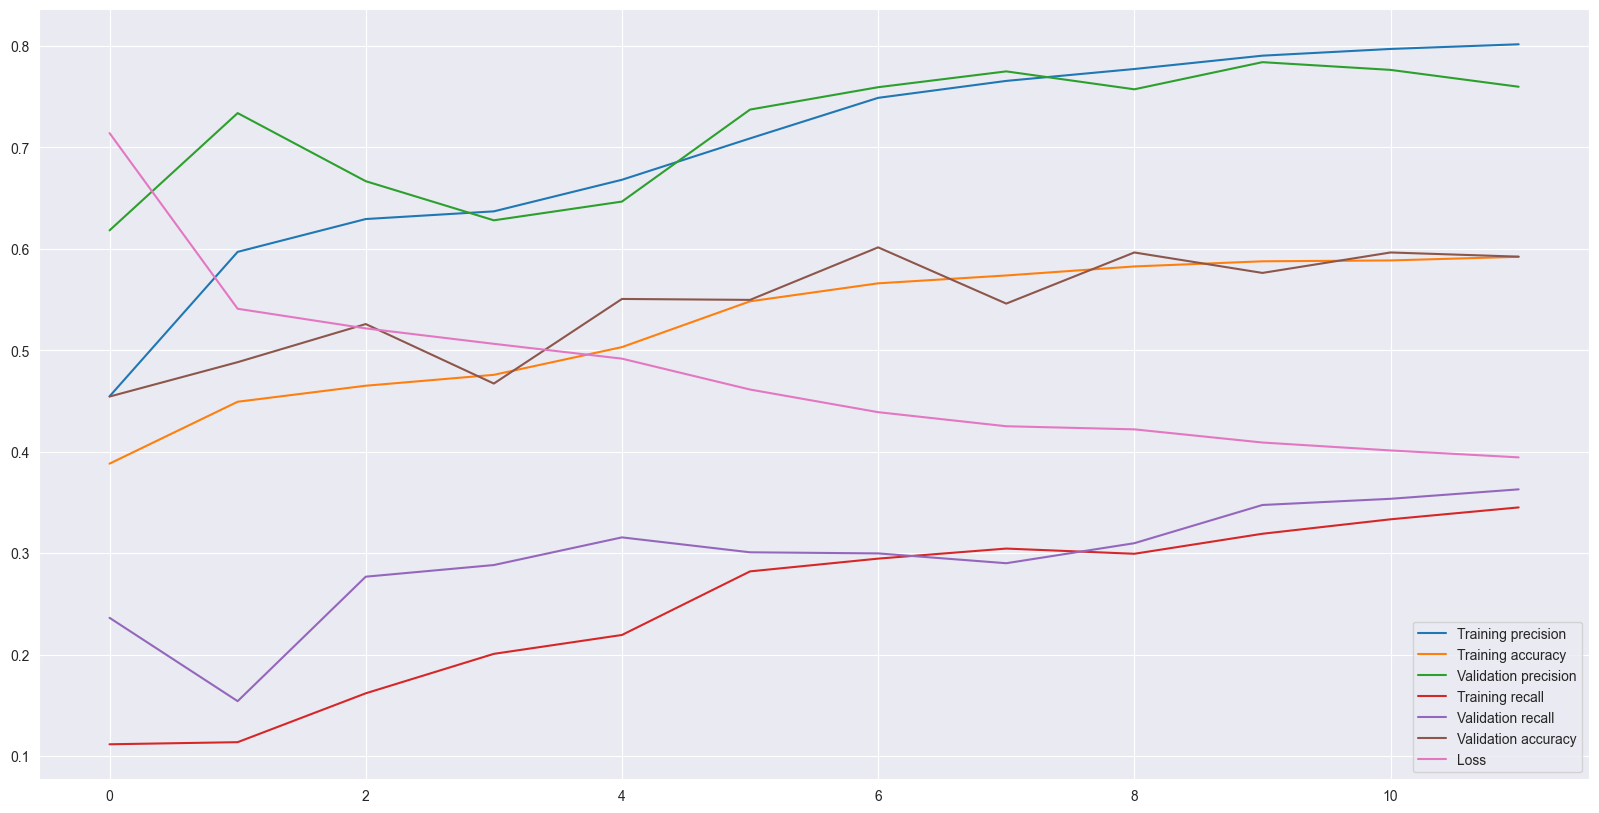

In [45]:
plt.figure(figsize=(20,10))
plt.plot(history.history['Precision'], label = 'Training precision')
plt.plot(history.history['categorical_accuracy'], label = 'Training accuracy')
plt.plot(history.history['val_Precision'], label = 'Validation precision')
plt.plot(history.history['Recall'], label = 'Training recall')
plt.plot(history.history['val_Recall'], label = 'Validation recall')
plt.plot(history.history['val_categorical_accuracy'], label = 'Validation accuracy')
plt.plot(history.history['loss'], label = 'Loss')
plt.legend()

In [46]:
modelLSTM.save('modelLSTM.keras') 

### CNN + LSTM + Metadata

Finally, using the previous models as foundations, I created a new model that combines both the simple CNN and the LSTM, plus the feature model, to extract and classify the ECGs signals.

In [47]:
def create_CNN_LSTM_model(feat_shape, ecg_shape, label_shape):
    
    feat_inputs = keras.Input(feat_shape[1:])
    ecg_inputs = keras.Input(ecg_shape[1:])

    model_feat = create_feat_model(feat_inputs)
    model_LSTM = RNN_LSTM_ECG_model(ecg_inputs)
    model_CNN = create_CNN_ECG_model(ecg_inputs, filters=(64, 128, 256), kernel_size=(7, 3, 3))


    X = keras.layers.Concatenate()([model_feat, model_LSTM, model_CNN])
    
    X = keras.layers.Dense(64, activation='relu')(X)
    X = keras.layers.Dense(64, activation='relu')(X)
    X = keras.layers.Dropout(0.5)(X)
    outputs = keras.layers.Dense(label_shape[-1], activation='softmax')(X)

    model = keras.Model(inputs=[feat_inputs, ecg_inputs], outputs=outputs, name='modelLSTM')
    return model

In [48]:
modelLSTM_CNN = create_CNN_LSTM_model(feat_train.shape, ecg_train.shape, labels_train.shape)
modelLSTM_CNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['categorical_accuracy', 'Precision', 'Recall'])
modelLSTM_CNN.summary()

Model: "modelLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 1000, 12)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 1000, 64)  │      5,440 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1000, 64)  │        256 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 1000, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 500, 64)   │          0 │ re_lu_3[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 500, 128)  │     24,704 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 500, 128)  │        512 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 500, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 250, 128)  │          0 │ re_lu_4[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 250, 256)  │     98,560 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 32)        │        416 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 250, 256)  │      1,024 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 32)        │          0 │ dense_25[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_5 (ReLU)      │ (None, 250, 256)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 32)        │      1,056 │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 1000, 32)  │      5,760 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ re_lu_5[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 32)        │          0 │ dense_26[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 32)        │      8,320 │ lstm_2[0][0]    

 Total params: 171,077 (668.27 KB)

 Trainable params: 170,181 (664.77 KB)

 Non-trainable params: 896 (3.50 KB)

In [49]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=5)]

history = modelLSTM_CNN.fit([feat_train, ecg_train], labels_train, epochs=30, batch_size=32, callbacks=callbacks_list, validation_data=([feat_val, ecg_val], labels_val))

Epoch 1/30
545/545 ━━━━━━━━━━━━━━━━━━━━ 311s 562ms/step - Precision: 0.5679 - Recall: 0.2505 - categorical_accuracy: 0.4390 - loss: 0.6975 - val_Precision: 0.7928 - val_Recall: 0.3734 - val_categorical_accuracy: 0.6335 - val_loss: 0.3681
Epoch 2/30
545/545 ━━━━━━━━━━━━━━━━━━━━ 301s 553ms/step - Precision: 0.7825 - Recall: 0.4136 - categorical_accuracy: 0.6197 - loss: 0.3930 - val_Precision: 0.8242 - val_Recall: 0.5161 - val_categorical_accuracy: 0.6615 - val_loss: 0.3455
Epoch 3/30
545/545 ━━━━━━━━━━━━━━━━━━━━ 303s 556ms/step - Precision: 0.7998 - Recall: 0.5035 - categorical_accuracy: 0.6672 - loss: 0.3552 - val_Precision: 0.7871 - val_Recall: 0.5369 - val_categorical_accuracy: 0.6885 - val_loss: 0.3330
Epoch 4/30
545/545 ━━━━━━━━━━━━━━━━━━━━ 301s 552ms/step - Precision: 0.8091 - Recall: 0.5229 - categorical_accuracy: 0.6799 - loss: 0.3366 - val_Precision: 0.8053 - val_Recall: 0.5445 - val_categorical_accuracy: 0.6885 - val_loss: 0.3131
Epoch 5/30
545/545 ━━━━━━━━━━━━━━━━━━━━ 302s 555

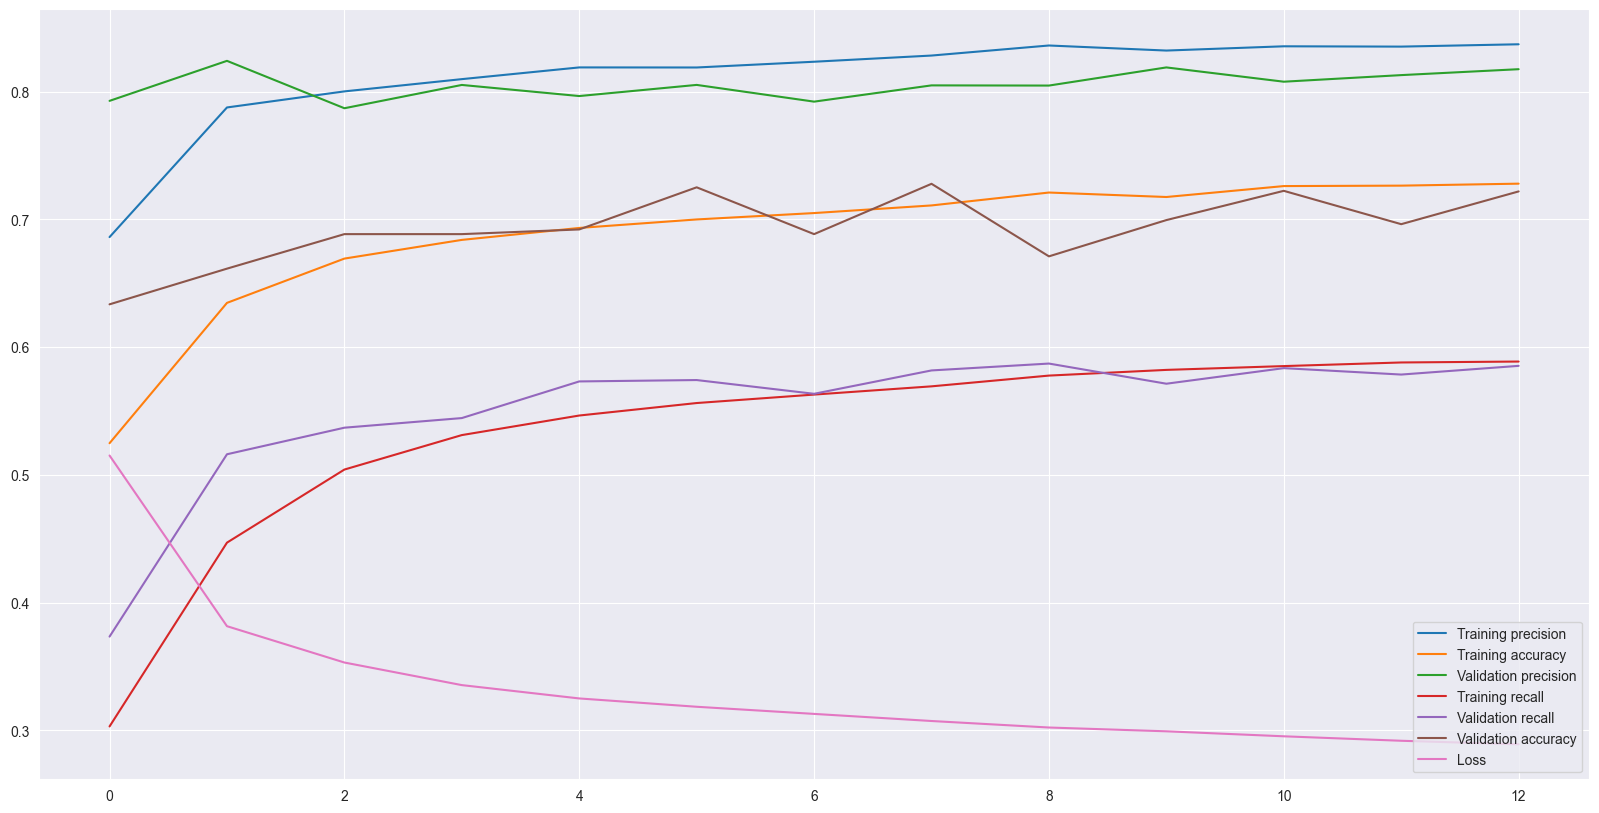

In [50]:
plt.figure(figsize=(20,10))
plt.plot(history.history['Precision'], label = 'Training precision')
plt.plot(history.history['categorical_accuracy'], label = 'Training accuracy')
plt.plot(history.history['val_Precision'], label = 'Validation precision')
plt.plot(history.history['Recall'], label = 'Training recall')
plt.plot(history.history['val_Recall'], label = 'Validation recall')
plt.plot(history.history['val_categorical_accuracy'], label = 'Validation accuracy')
plt.plot(history.history['loss'], label = 'Loss')
plt.legend()

In [51]:
modelLSTM_CNN.save('modelLSTM_CNN.keras') 

### CNN residuals + LSTM + Metadata

Following the idea from before, now i combined the more complex CNN with the residuals model with the LSTM and the feature model to perfomr the classification task.

In [100]:
def create_CNN_residuals_LSTM_model(feat_shape, ecg_shape, label_shape):
    
    feat_inputs = keras.Input(feat_shape[1:])
    ecg_inputs = keras.Input(ecg_shape[1:])

    model_feat = create_feat_model(feat_inputs)
    model_LSTM = RNN_LSTM_ECG_model(ecg_inputs)
    model_CNN = CNN_residual(ecg_inputs)


    X = keras.layers.Concatenate()([model_feat, model_LSTM, model_CNN])
    
    X = keras.layers.Dense(64, activation='relu')(X)
    X = keras.layers.Dense(64, activation='relu')(X)
    X = keras.layers.Dropout(0.5)(X)
    outputs = keras.layers.Dense(label_shape[-1], activation='softmax')(X)

    model = keras.Model(inputs=[feat_inputs, ecg_inputs], outputs=outputs, name='modelCNN_residuals_LSTM')
    return model

In [101]:
modelLSTM_CNN_residuals = create_CNN_residuals_LSTM_model(feat_train.shape, ecg_train.shape, labels_train.shape)
modelLSTM_CNN_residuals.compile(optimizer='adam', loss='binary_crossentropy', metrics=['categorical_accuracy', 'Precision', 'Recall'])
modelLSTM_CNN_residuals.summary()

Model: "modelCNN_residuals_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_29      │ (None, 1000, 12)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 1000, 32)  │      1,952 │ input_layer_29[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_1 (Conv1D)    │ (None, 1000, 32)  │      5,152 │ conv1d_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2_1 (Conv1D)    │ (None, 1000, 32)  │      5,152 │ Conv1_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ResidualSum_1 (Add) │ (None, 1000, 32)  │          0 │ Conv2_1[0][0],    │
│                     │                   │            │ conv1d_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Act_1 (Activation)  │ (None, 1000, 32)  │          0 │ ResidualSum_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MaxPool_1           │ (None, 498, 32)   │          0 │ Act_1[0][0]       │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_2 (Conv1D)    │ (None, 498, 32)   │      5,152 │ MaxPool_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2_2 (Conv1D)    │ (None, 498, 32)   │      5,152 │ Conv1_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ResidualSum_2 (Add) │ (None, 498, 32)   │          0 │ Conv2_2[0][0],    │
│                     │                   │            │ MaxPool_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Act_2 (Activation)  │ (None, 498, 32)   │          0 │ ResidualSum_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MaxPool_2           │ (None, 247, 32)   │          0 │ Act_2[0][0]       │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_3 (Conv1D)    │ (None, 247, 32)   │      5,152 │ MaxPool_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_28      │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2_3 (Conv1D)    │ (None, 247, 32)   │      5,152 │ Conv1_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_69 (Dense)    │ (None, 32)        │        416 │ input_layer_28[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ResidualSum_3 (Add) │ (None, 247, 32)   │          0 │ Conv2_3[0][0],    │
│                     │                   │            │ MaxPool_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_44          │ (None, 32)        │          0 │ dense_69[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Act_3 (Activation)  │ (None, 247, 32)   │          0 │ ResidualSum_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_70 (Dense)    │ (None, 32)        │      1,056 │ dropout_44[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_18 (LSTM)      │ (None, 1000, 32)  │      5,760 │ input_layer_29[0

 Total params: 306,917 (1.17 MB)

 Trainable params: 306,917 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

In [102]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=5)]

history = modelLSTM_CNN_residuals.fit([feat_train, ecg_train], labels_train, epochs=30, batch_size=32, callbacks=callbacks_list, validation_data=([feat_val, ecg_val], labels_val))

Epoch 1/30
545/545 ━━━━━━━━━━━━━━━━━━━━ 305s 549ms/step - Precision: 0.6373 - Recall: 0.2581 - categorical_accuracy: 0.4646 - loss: 0.5544 - val_Precision: 0.7821 - val_Recall: 0.4455 - val_categorical_accuracy: 0.6262 - val_loss: 0.3668
Epoch 2/30
545/545 ━━━━━━━━━━━━━━━━━━━━ 306s 562ms/step - Precision: 0.7947 - Recall: 0.4796 - categorical_accuracy: 0.6533 - loss: 0.3718 - val_Precision: 0.7985 - val_Recall: 0.5585 - val_categorical_accuracy: 0.6830 - val_loss: 0.3342
Epoch 3/30
545/545 ━━━━━━━━━━━━━━━━━━━━ 312s 572ms/step - Precision: 0.8153 - Recall: 0.5410 - categorical_accuracy: 0.6788 - loss: 0.3339 - val_Precision: 0.7899 - val_Recall: 0.5516 - val_categorical_accuracy: 0.6725 - val_loss: 0.3297
Epoch 4/30
545/545 ━━━━━━━━━━━━━━━━━━━━ 306s 560ms/step - Precision: 0.8287 - Recall: 0.5602 - categorical_accuracy: 0.6972 - loss: 0.3097 - val_Precision: 0.8081 - val_Recall: 0.5814 - val_categorical_accuracy: 0.6958 - val_loss: 0.3141
Epoch 5/30
545/545 ━━━━━━━━━━━━━━━━━━━━ 307s 563

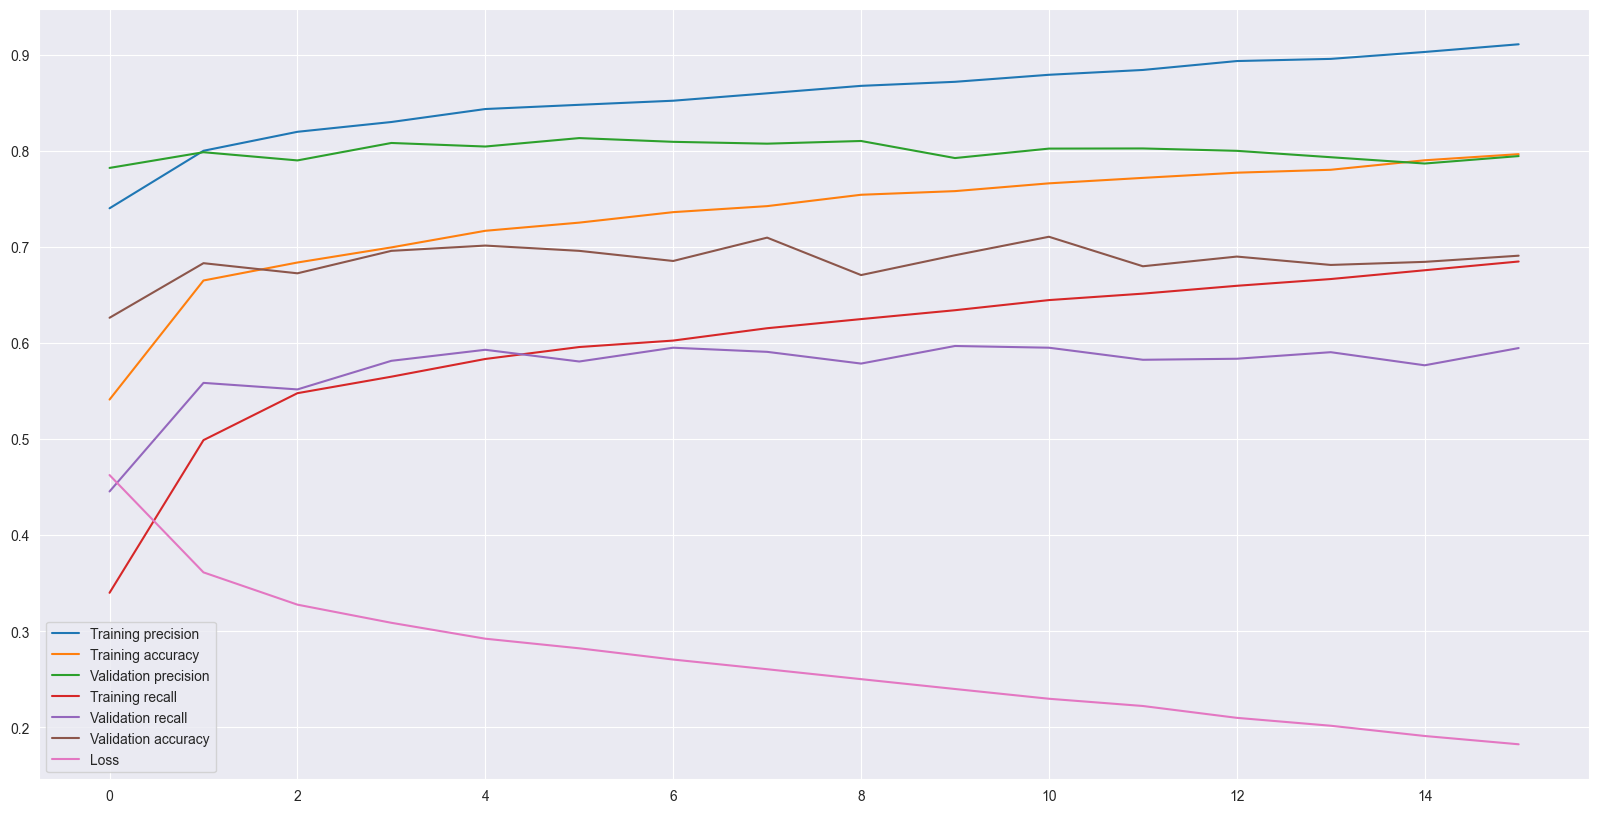

In [103]:
plt.figure(figsize=(20,10))
plt.plot(history.history['Precision'], label = 'Training precision')
plt.plot(history.history['categorical_accuracy'], label = 'Training accuracy')
plt.plot(history.history['val_Precision'], label = 'Validation precision')
plt.plot(history.history['Recall'], label = 'Training recall')
plt.plot(history.history['val_Recall'], label = 'Validation recall')
plt.plot(history.history['val_categorical_accuracy'], label = 'Validation accuracy')
plt.plot(history.history['loss'], label = 'Loss')
plt.legend()

In [104]:
modelLSTM_CNN_residuals.save('modelLSTM_CNN_residuals.keras') 

## First models comparison:

To perform the analysis, three metrics were explored: the confusion matrix, the ROC AUC and the PR AUC. For that purpouse, I developped three functions to extract them from the predictions and plot the resulting metrics.

In [52]:
baseline_model = keras.models.load_model('baseline_model.keras')
modelCNN = keras.models.load_model('modelCNN.keras')
modelCNN_residual = keras.models.load_model('modelCNN_residual.keras')
modelLSTM = keras.models.load_model('modelLSTM.keras')
modelLSTM_CNN = keras.models.load_model('modelLSTM_CNN.keras')

In [53]:
pred_baseline = baseline_model.predict(feat_test)

threshold = 0.5
pred_labels_baseline = (pred_baseline >= threshold).astype(int)

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [35]:
from sklearn.metrics import multilabel_confusion_matrix

def plot_five_classes_cm(labels, pred_labels, label_classes):
    """
    Function to plot Confusion Matrices for each label in a multiclass problem.
    """
    cm = multilabel_confusion_matrix(labels, pred_labels)

    fig, axes = plt.subplots(1, len(label_classes), figsize=(20, 4))

    for i, label in enumerate(label_classes):
        sns.heatmap(cm[i, :, :], annot=True, fmt='d', cmap='Blues', cbar=True, ax=axes[i])
        axes[i].set_title(label)
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')

        # Set tick labels for True/False
        axes[i].set_xticklabels(['Negative', 'Positive'])
        axes[i].set_yticklabels(['Negative', 'Positive'])

    # Adjust layout
    plt.tight_layout()
    plt.show()

Baseline model:


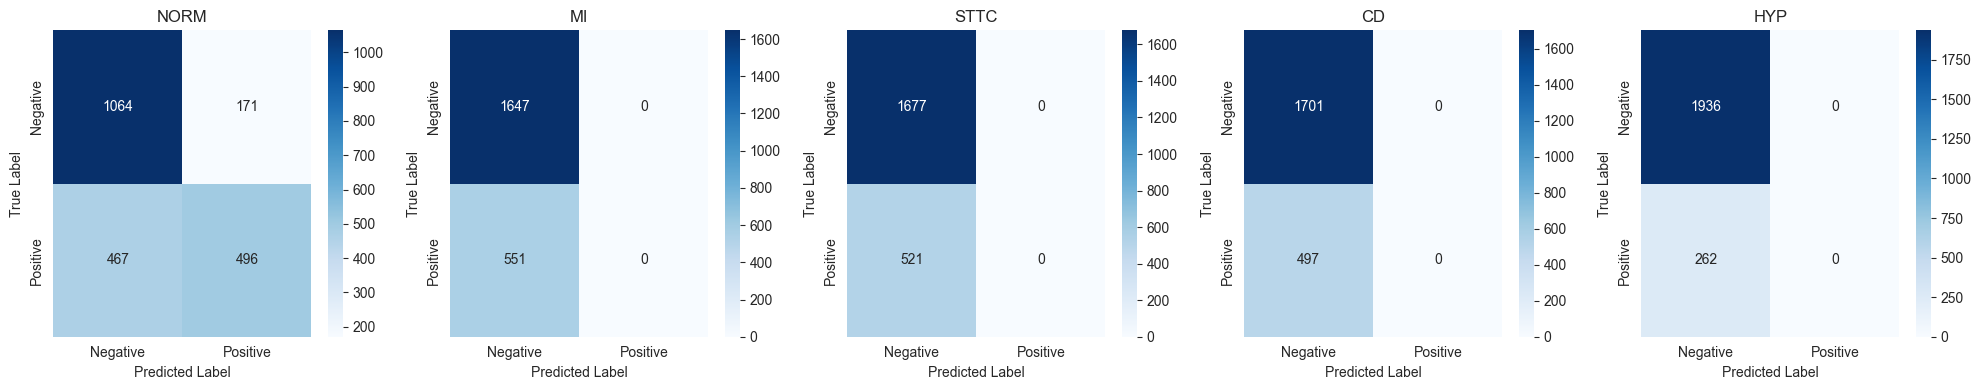

modelCNN:
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


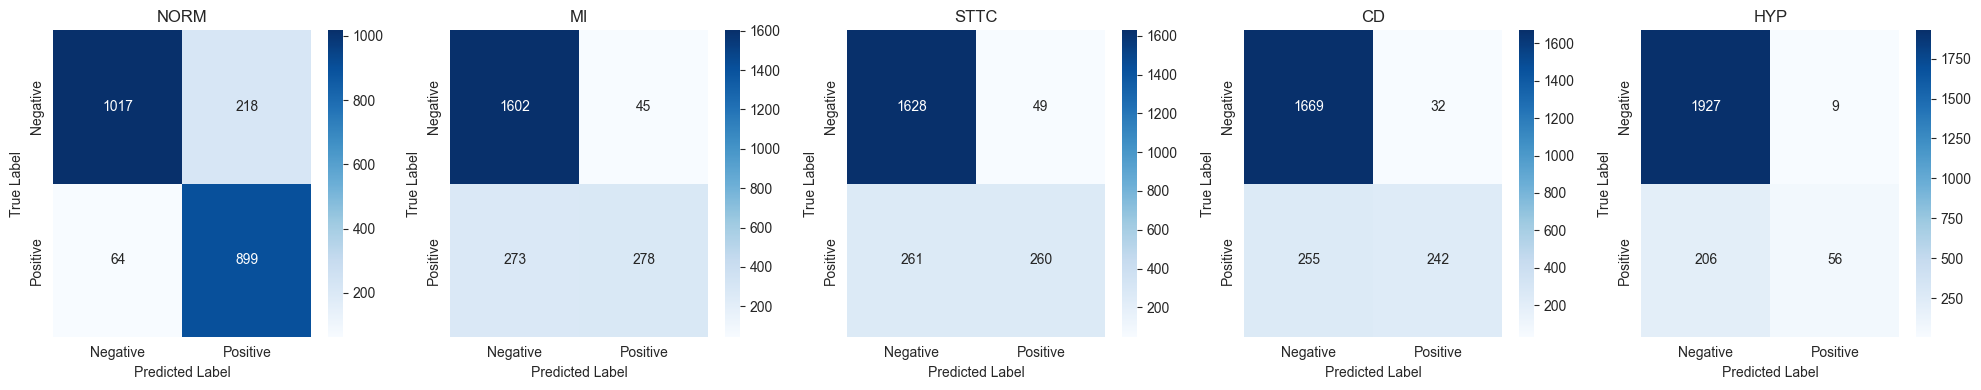

modelCNN_residual:
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


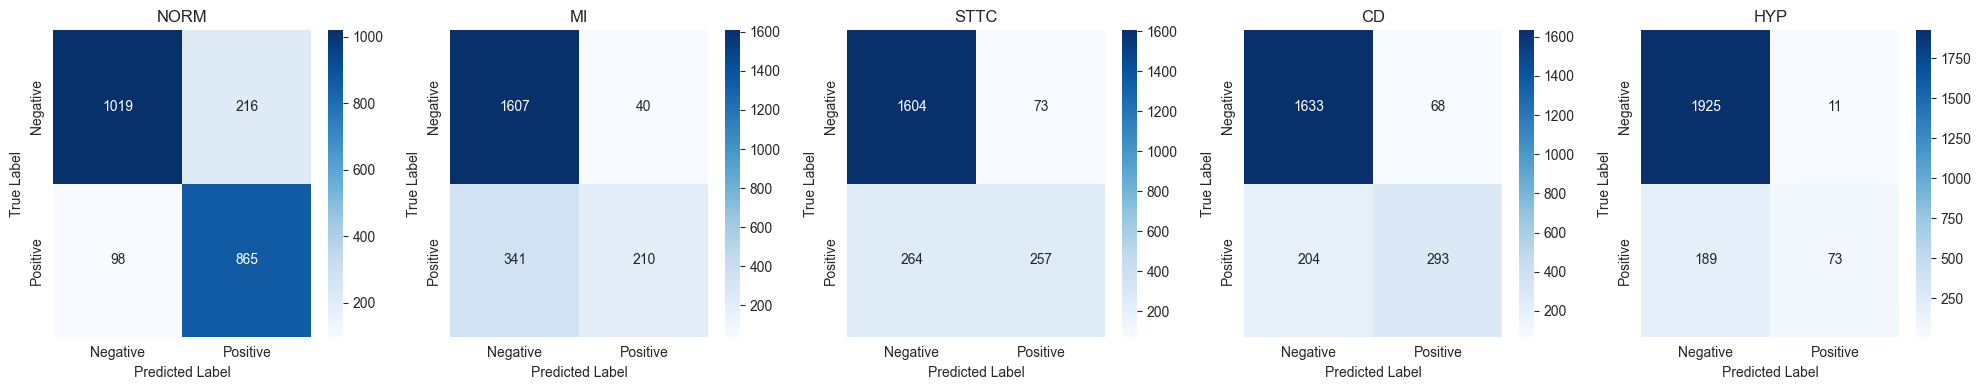

modelLSTM:
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step


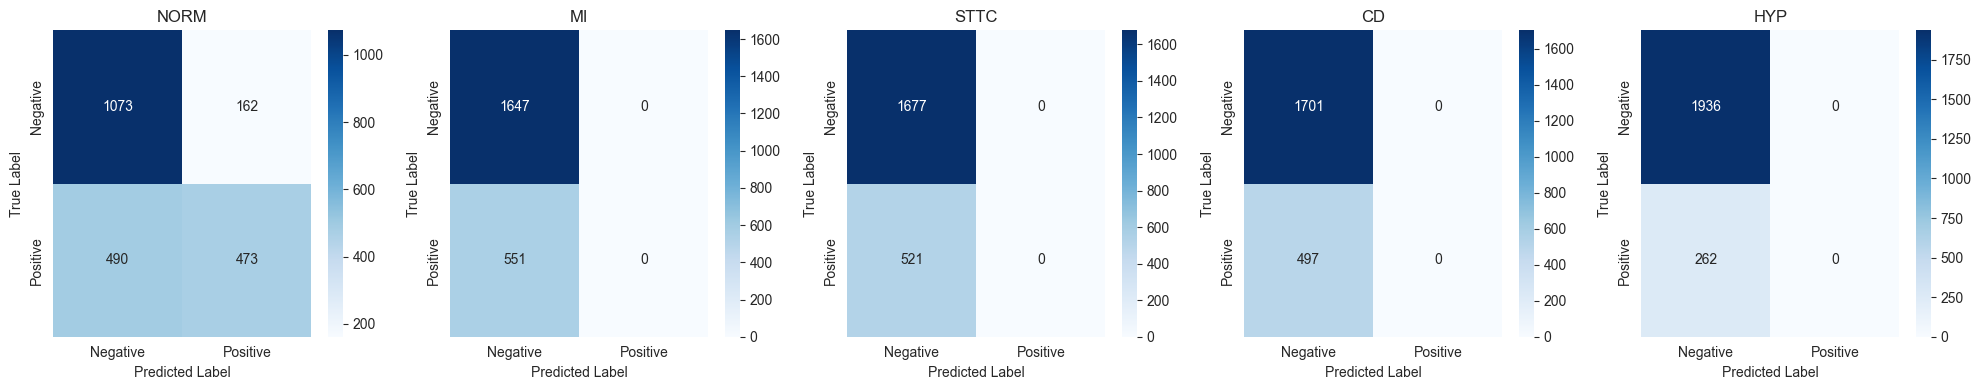

modelLSTM_CNN:
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 160ms/step


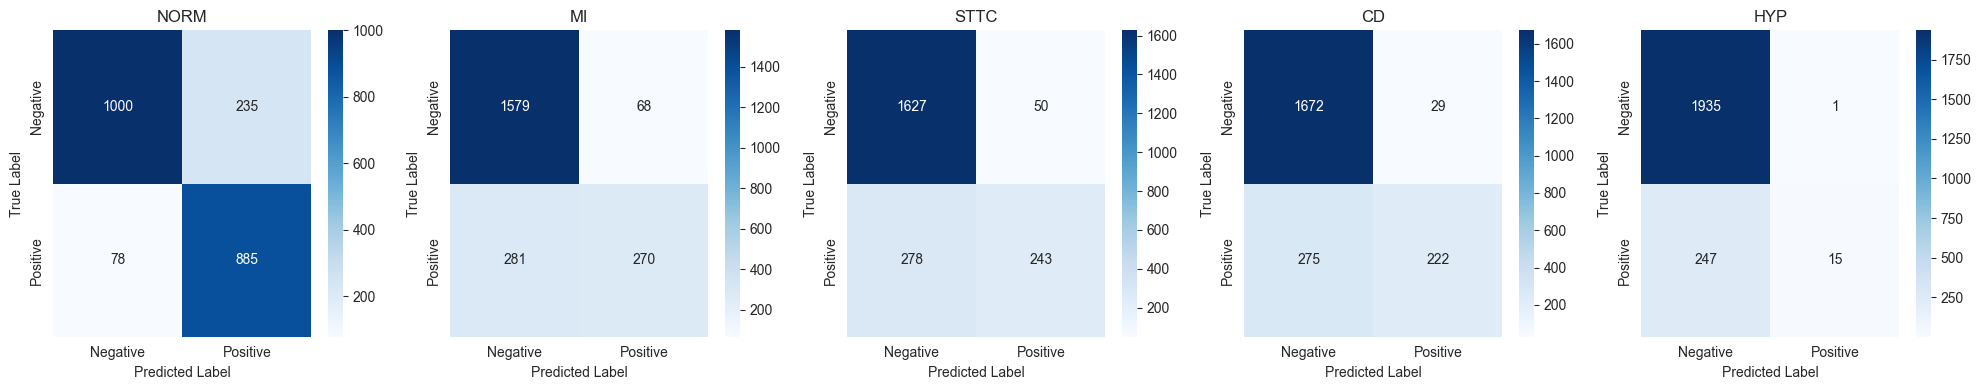

modelLSTM_CNN_residuals:
69/69 ━━━━━━━━━━━━━━━━━━━━ 12s 161ms/step


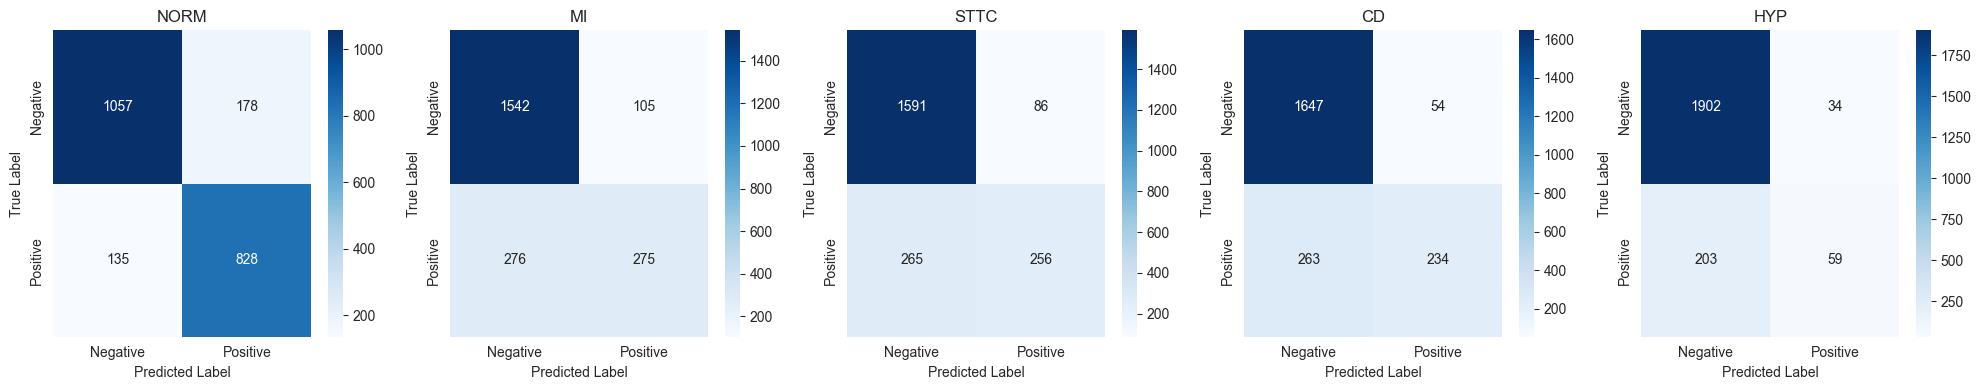

In [105]:
label_classes = ["NORM", "MI", "STTC", "CD", "HYP"]
threshold = 0.5
pred_labels_baseline = (pred_baseline >= threshold).astype(int)

print('Baseline model:')
plot_five_classes_cm(labels_test, pred_labels_baseline, label_classes)

threshold = 0.5
model_names = ['modelCNN','modelCNN_residual','modelLSTM','modelLSTM_CNN','modelLSTM_CNN_residuals']
models = {
    'modelCNN': modelCNN,
    'modelCNN_residual': modelCNN_residual,
    'modelLSTM': modelLSTM,
    'modelLSTM_CNN': modelLSTM_CNN,
    'modelLSTM_CNN_residuals': modelLSTM_CNN_residuals
}

for i, name_model in enumerate(model_names):
    print(f'{name_model}:')
    pred =  models[name_model].predict([feat_test, ecg_test])
    pred_labels = (pred >= threshold).astype(int)
    plot_five_classes_cm(labels_test, pred_labels, label_classes)

In [38]:
def plot_five_classes_roc(labels, pred_labels, label_classes):
    """
    Function to plot ROC curves for each label in a multiclass problem.
    """
    fig, ax = plt.subplots(figsize=(10, 8))

    roc_auc_values = []
    for i, label in enumerate(label_classes):

        fpr, tpr, _ = roc_curve(labels[:, i], pred_labels[:, i])
        roc_auc = auc(fpr, tpr)
        roc_auc_values.append(roc_auc)
        
        ax.plot(fpr, tpr, label=f'{label} label (AUC = {roc_auc:.2f})')
    
    avg_roc_auc = sum(roc_auc_values) / len(roc_auc_values)
    
    ax.plot([0, 1], [0, 1], 'k--', label='Random ROC (AUC = 0.50)')

    ax.set_title('ROC Curves for Each Class')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')

    ax.legend(loc='lower right', title=f'Avg AUC = {avg_roc_auc:.2f}')
    plt.tight_layout()
    plt.show()
    
    return avg_roc_auc


Baseline model:


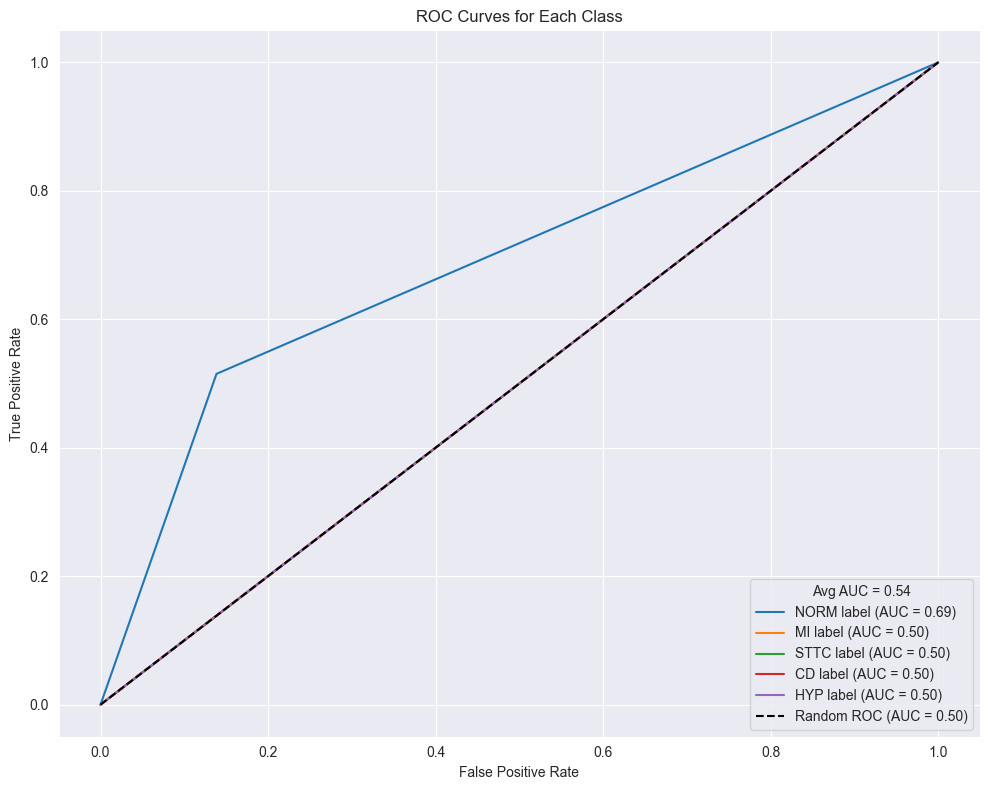

modelCNN:
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


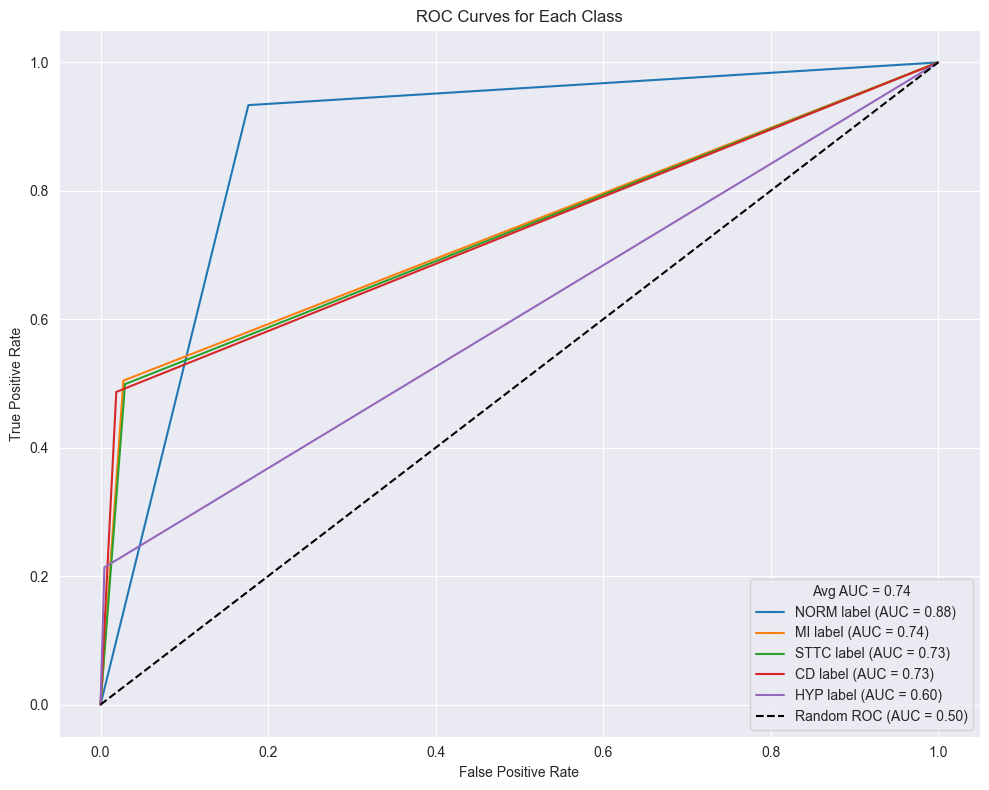

modelCNN_residual:
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


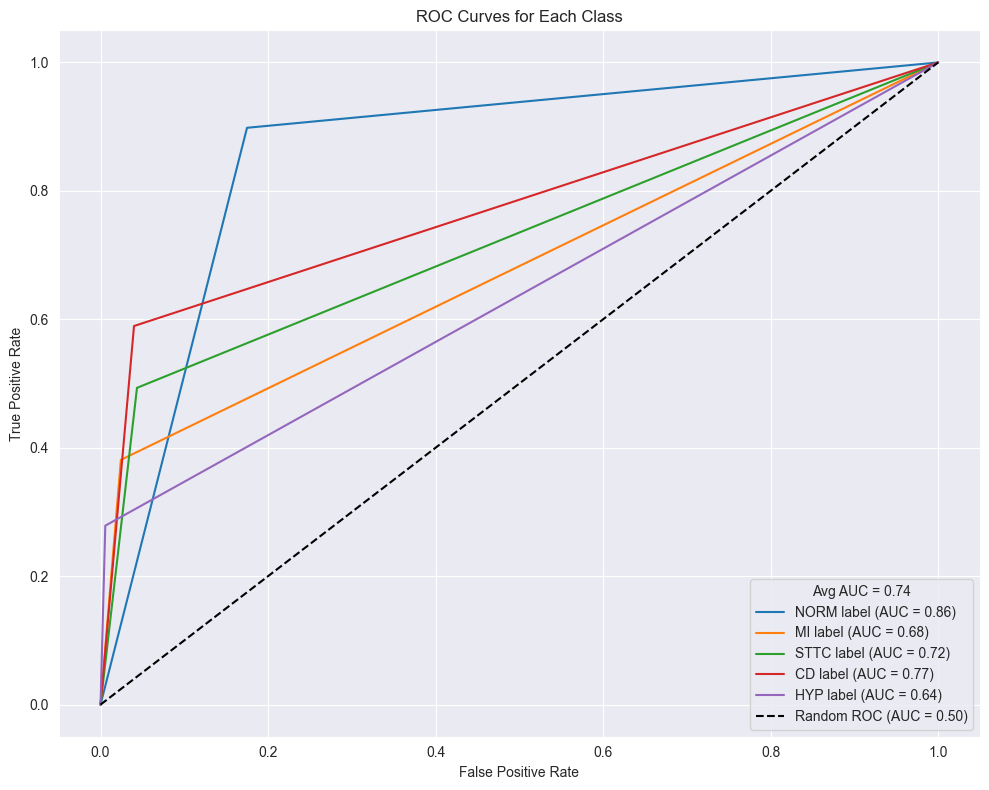

modelLSTM:
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step


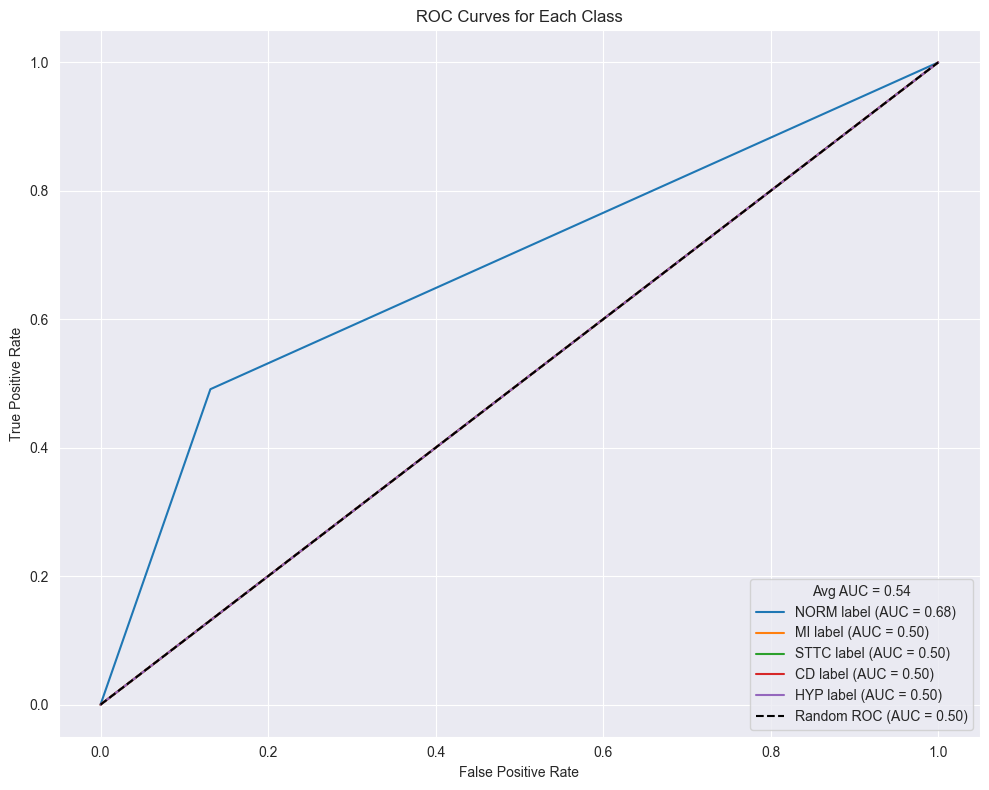

modelLSTM_CNN:
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step


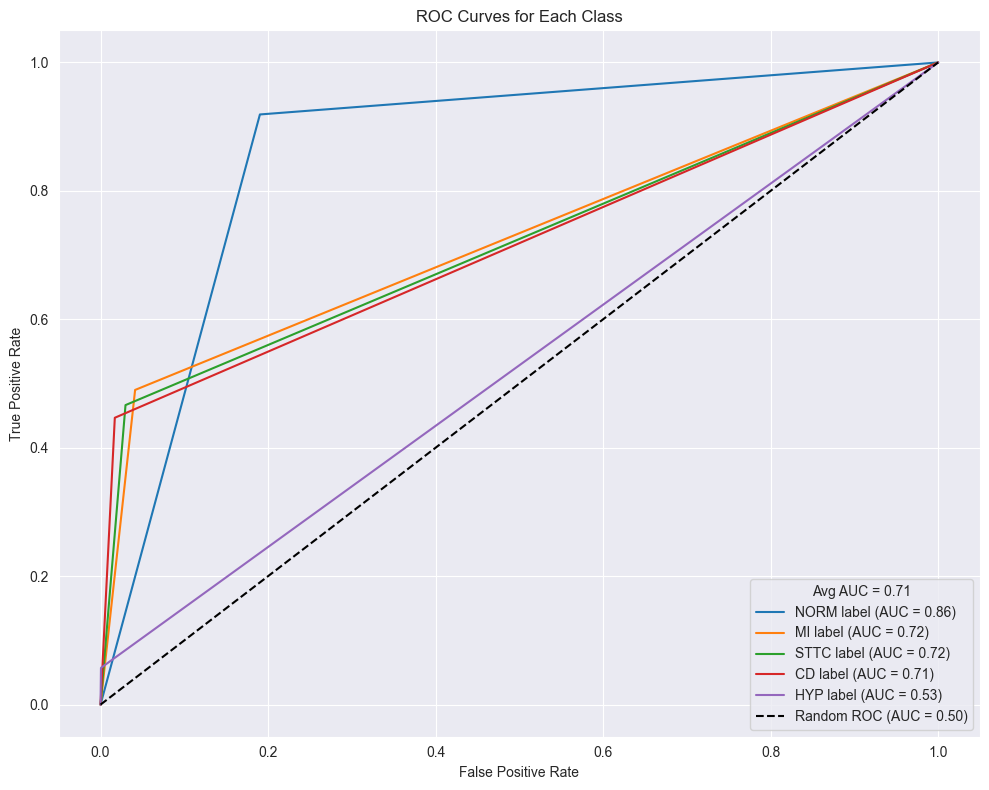

modelLSTM_CNN_residuals:
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 157ms/step


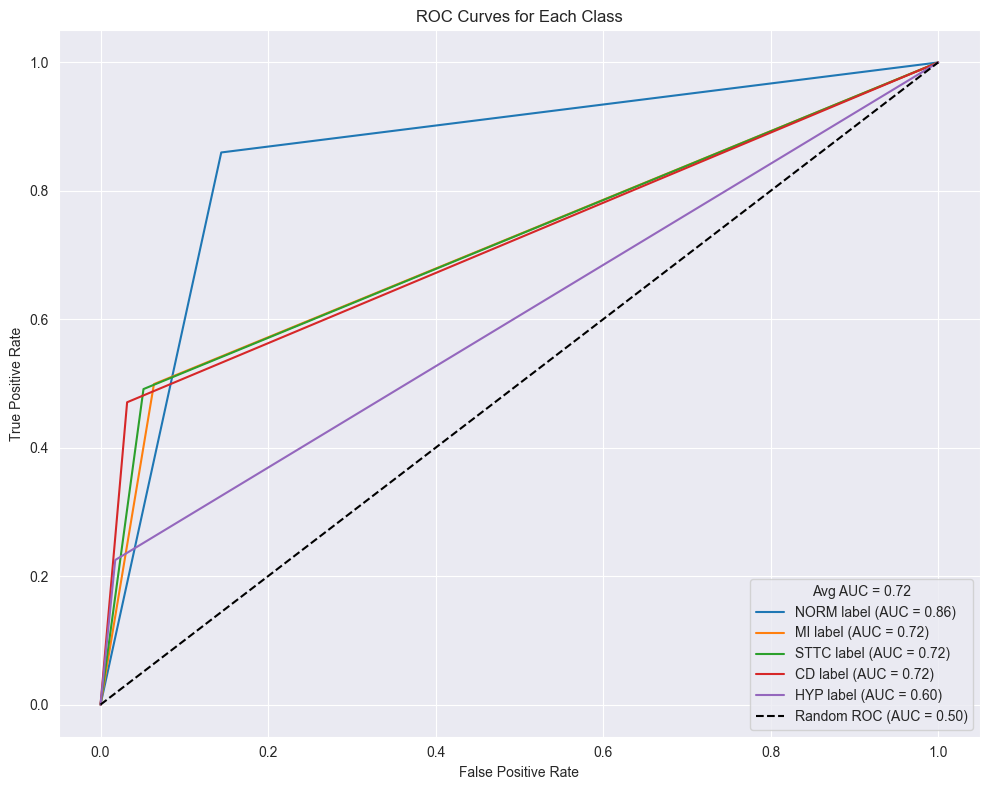

In [106]:
print('Baseline model:')
pred_labels_baseline = (pred_baseline >= threshold).astype(int)
avg_roc_auc = plot_five_classes_roc(np.array(labels_test), pred_labels_baseline, label_classes)

for name_model in model_names:
    print(f'{name_model}:')
    pred = models[name_model].predict([feat_test, ecg_test])
    pred_labels = (pred >= threshold).astype(int)
    avg_roc_auc = plot_five_classes_roc(np.array(labels_test), pred_labels, label_classes)

In [39]:
def plot_five_classes_pr(labels, pred_labels, label_classes):
    """
    Function to plot PR curves for each label in a multiclass problem.
    """
    fig, ax = plt.subplots(figsize=(10, 8))

    pr_auc_values = []
    for i, label in enumerate(label_classes):

        precision, recall, _ = precision_recall_curve(labels[:, i], pred_labels[:, i])
        pr_auc = average_precision_score(labels[:, i], pred_labels[:, i])
        pr_auc_values.append(pr_auc)
        
        ax.plot(recall, precision, label=f'{label} (AUC = {pr_auc:.2f})')
    
    avg_pr_auc = sum(pr_auc_values) / len(pr_auc_values)

    ax.set_title('PR Curves for Each Class')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')

    ax.legend(loc='lower left', title=f'Avg AUC = {avg_pr_auc:.2f}')
    
    plt.tight_layout()
    plt.show()

Baseline model:


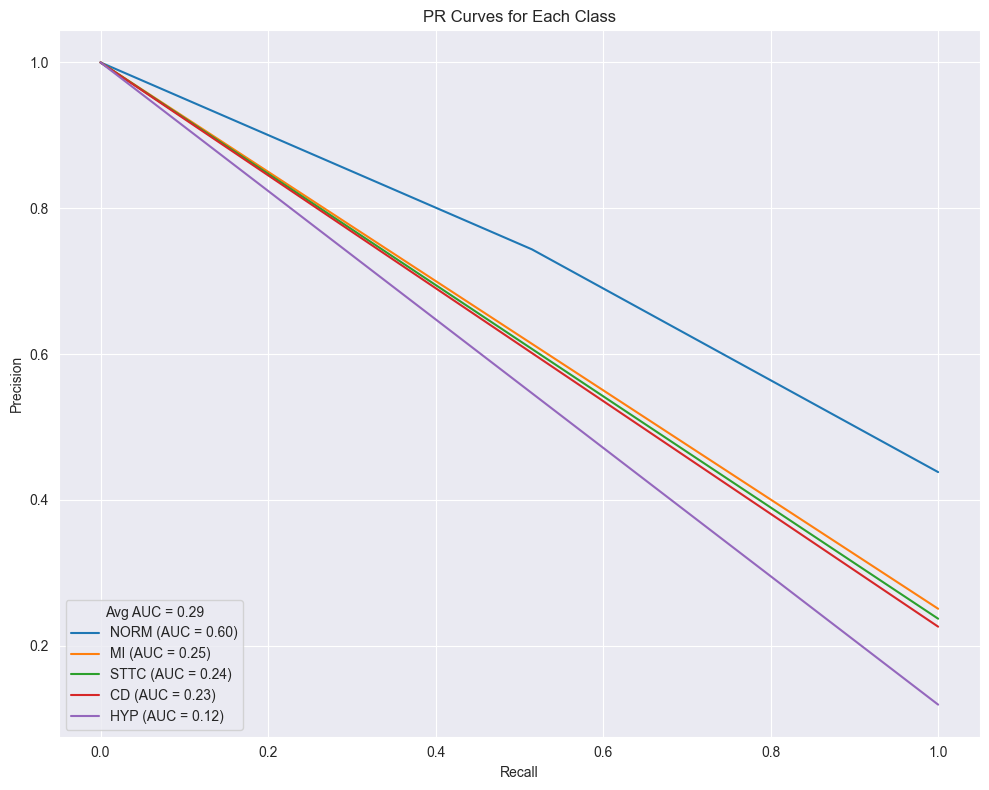

modelCNN:
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


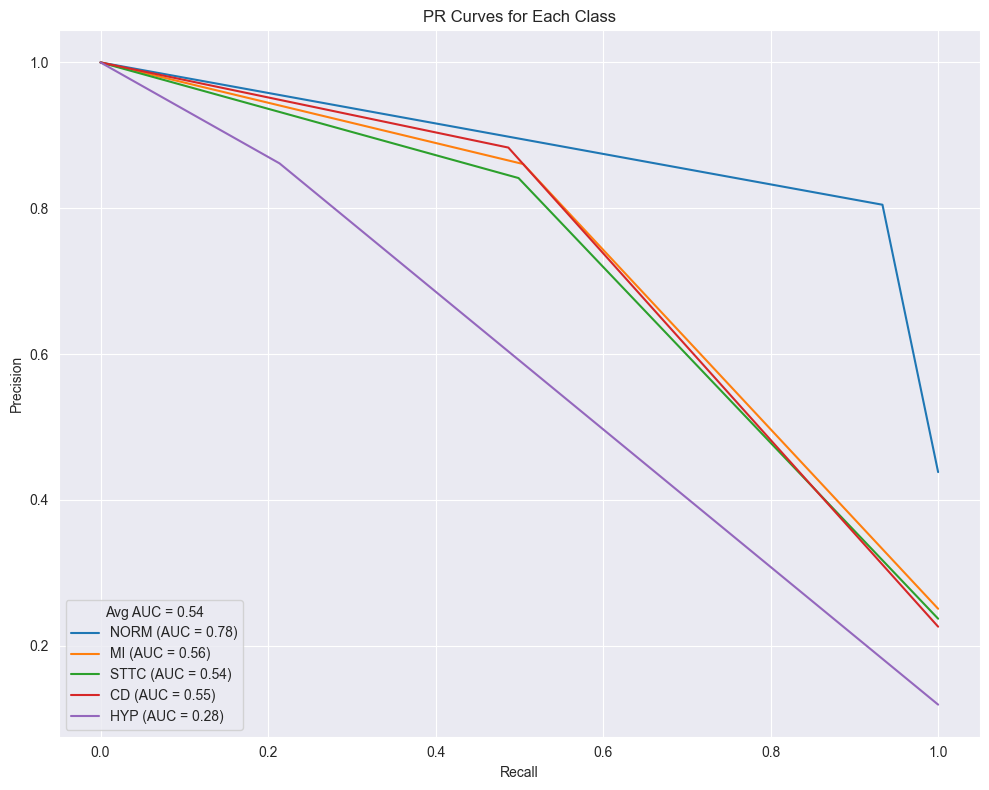

modelCNN_residual:
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


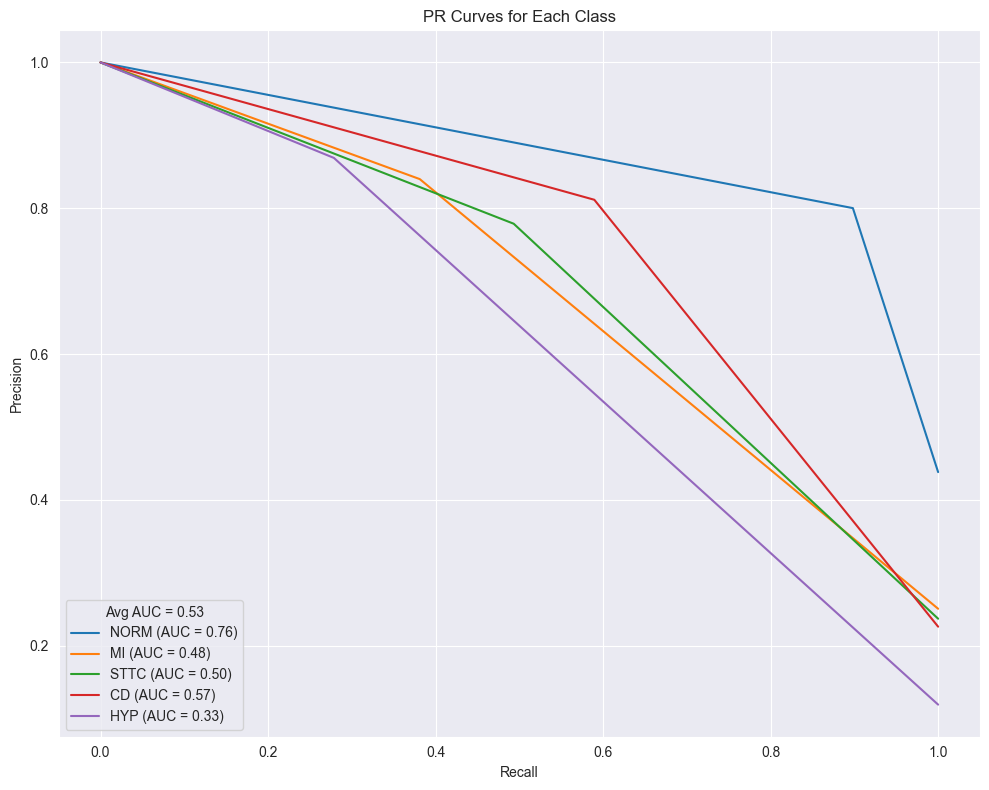

modelLSTM:
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 161ms/step


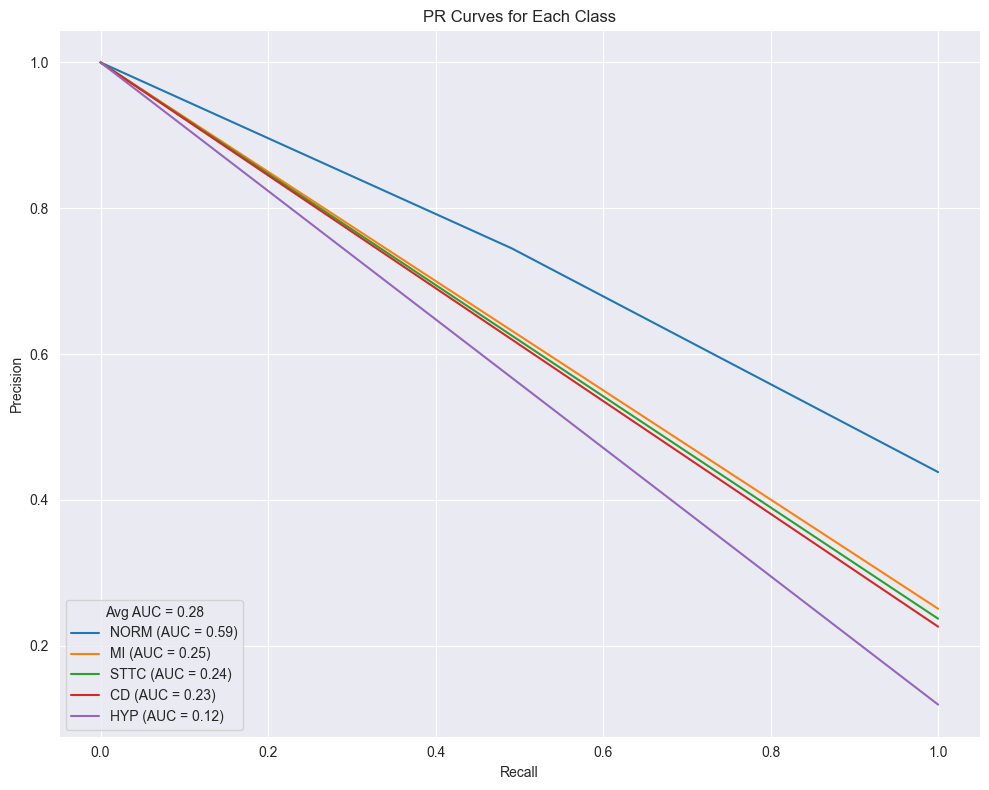

modelLSTM_CNN:
69/69 ━━━━━━━━━━━━━━━━━━━━ 12s 177ms/step


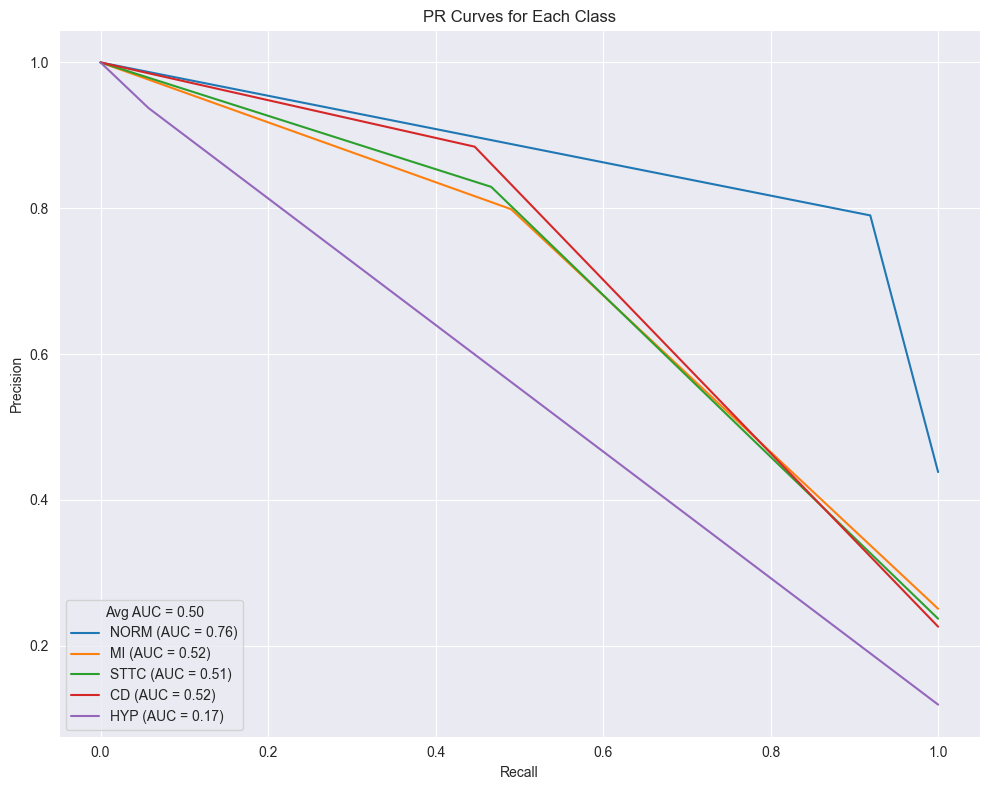

modelLSTM_CNN_residuals:
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step


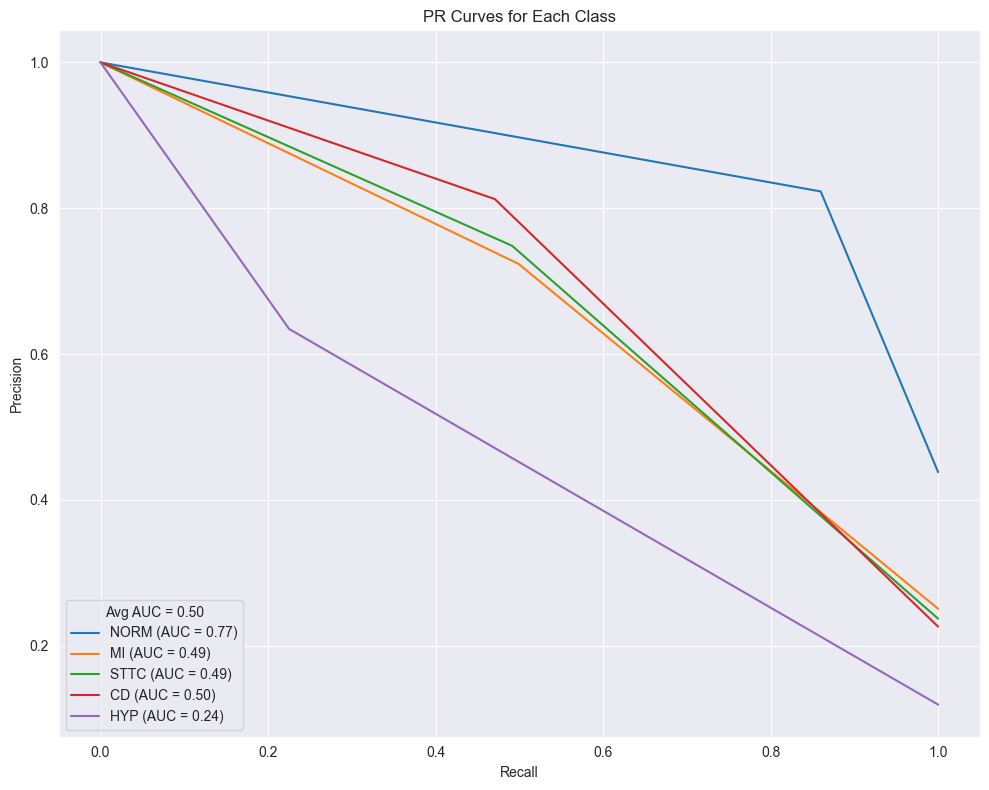

In [108]:
print('Baseline model:')
pred_labels_baseline = (pred_baseline >= threshold).astype(int)
plot_five_classes_pr(np.array(labels_test), pred_labels_baseline, label_classes)

# Other models
for name_model in model_names:
    print(f'{name_model}:')
    pred = models[name_model].predict([feat_test, ecg_test])
    pred_labels = (pred >= threshold).astype(int)
    plot_five_classes_pr(np.array(labels_test), pred_labels, label_classes)

AS we can see, the best performing models are the CNN models, with and without residuals. The incorporation of the LSTM layer to the model did not improve the results but worsened it. Those results are not as optimized as they can be since hyperparameters tuning has not been carried out due to time limitations. Nevertheless, they provided a basic understanding of the models performances, showing potential routes to be taken in the future. On the other hand, the incorparation opf the previously explained features highly improved the results, but probably due to data leakage.

## Median Beats Models

Another path to follow in this study is the use of median beats of the ECGs instead of the whole signal. This technique, highly used in the state of the art, constitutes a very efficient way to sum up redundant information in the signal while reducing the computational cost. 

### Median Beats Preprocessing

In [17]:
def getECGpattern(ecg, fs=1000, mode='median', 
                       window_left=420, window_right=580, 
                       filtering = False, show_figures=True, verbose=False):
    """
    Parameters:
     - ecg: array of the raw ECG Length x N_leads (if NxL it is transposed)
     - fs (int): ecg sampling frequency  
     - mode (string): 'median' (default) median of all the beats, 'mean' average of all the beats
     - show_figures (bool): show result figures
     - filtering (bool): perform filtering on the signals
     - verbose (bool): to print additional information about the steps
    
    Returns:
     - ECG_beat_patterns (numpy array): [L, N] matrix containing the beat pattern for each ecg lead. L number of samples, N number of ECG leads
    """

    [L,num_ecg_leads] = ecg.shape
    
    if L<num_ecg_leads:
        # Just in case the data input is transposed
        ecg = np.transpose(ecg)
        [L, num_ecg_leads] = ecg.shape
    
    if verbose:
        aux_print = '- ECG file loaded: ' + str(num_ecg_leads) + ' leads, ' + str(L) + ' samples.'
        print(aux_print)
    
    ecg_max = np.max(abs(ecg), axis=1) 
    
    if show_figures:
        signals, info = nk.ecg_process(ecg_max, sampling_rate=fs, method='neurokit')
        # Visualize
        nk.ecg_plot(signals)
    
    if verbose:
        aux_print = '- Cleaning the ECG signal and detecting the R-peaks...'
        print(aux_print)
        
    ecg_max_clean = nk.ecg_clean(ecg_max, sampling_rate=fs, method='neurokit')
    _, results = nk.ecg_peaks(ecg_max_clean, sampling_rate=fs, method='rodrigues2021')
    rpeaks = results["ECG_R_Peaks"]
    
    # Delete the first and last R-peak (partial beats)
    rpeaks = rpeaks[1:-1]
    num_rpeaks = len(rpeaks)

    
    if verbose:
        aux_print = '- Calculating beat pattern for each individual lead...'
        print(aux_print)
    
    ECG_beat_patterns = np.zeros((window_left+window_right,num_ecg_leads))

    for l in range(num_ecg_leads):
    
        # Load each channel individually
        aux_ecg = ecg[:,l]
        
        # Clean it (remove baseline wandering)
        if filtering == True:
            aux_ecg_clean = nk.ecg_clean(aux_ecg, sampling_rate=fs, method='neurokit')        
        else:
            aux_ecg_clean = aux_ecg
            
        aux_ecg_segments = np.empty((0, window_left+window_right))
        
        for r in range(num_rpeaks):
        
            aux_rpeak = rpeaks[r]
            aux_init = aux_rpeak - window_left
            aux_end = aux_rpeak + window_right
            
            # Check the window fits in the temporal vector, if no partial activation is found, do not include it (relevant for the first and last beat)
            if aux_init >=0:
                if aux_end < L:
                    aux_segment = aux_ecg_clean[aux_init:aux_end]
                    aux_ecg_segments = np.vstack((aux_ecg_segments, aux_segment))

        # Calculate median
        if mode=='median':
            aux_ecg_beat_pattern = np.median(aux_ecg_segments, axis=0)            
            aux_beat_pattern_title = 'Median beat activation - Lead: ' + str(l+1)
        else:
            # Average
            aux_ecg_beat_pattern = np.mean(aux_ecg_segments, axis=0)            
            aux_beat_pattern_title = 'Mean beat activation - Lead: ' + str(l+1)
            
        # Store lead pattern
        ECG_beat_patterns[:,l] = aux_ecg_beat_pattern
        
    if show_figures:
        plt.subplot(122)
        max_time = aux_ecg_beat_pattern.size/fs
        time_steps = np.linspace(0, max_time, aux_ecg_beat_pattern.size)
        plt.plot(time_steps, aux_ecg_beat_pattern, 'r',  linewidth='2')
        plt.title(aux_beat_pattern_title)
    
    if verbose:
        aux_print = '- Beat patterns calculation completed.'
        print(aux_print)
    
    # Return the results
    return ECG_beat_patterns


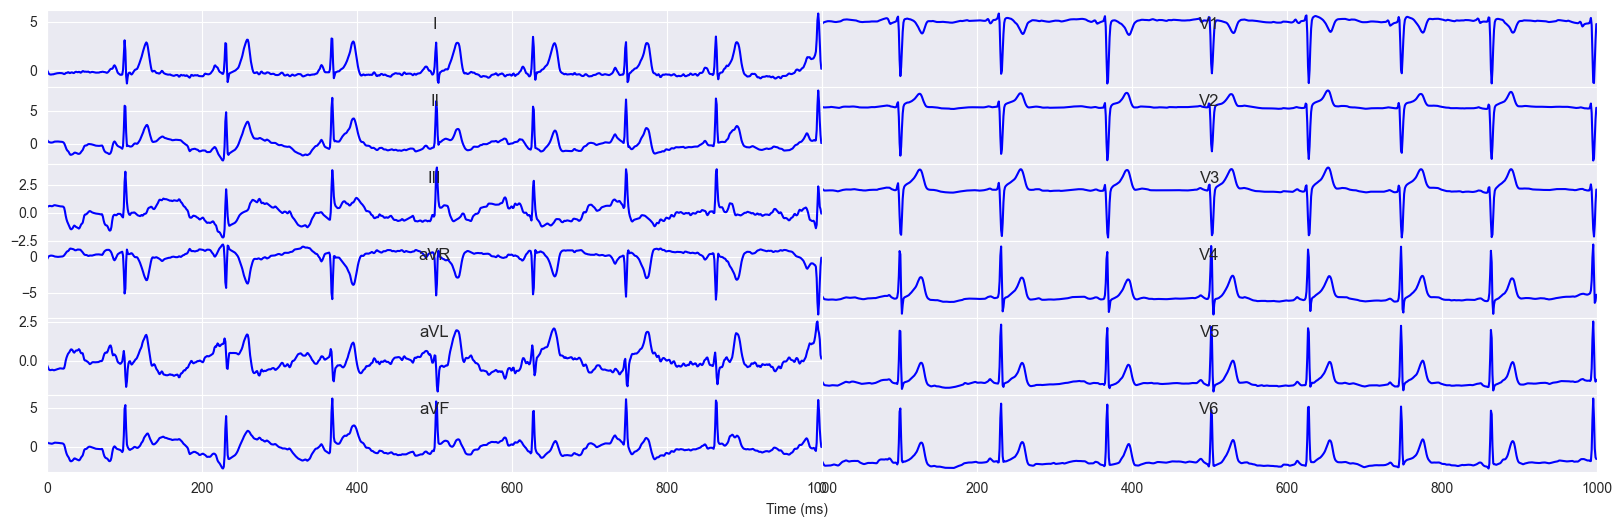

- ECG file loaded: 12 leads, 1000 samples.
- Cleaning the ECG signal and detecting the R-peaks...
- Calculating beat pattern for each individual lead...
- Beat patterns calculation completed.


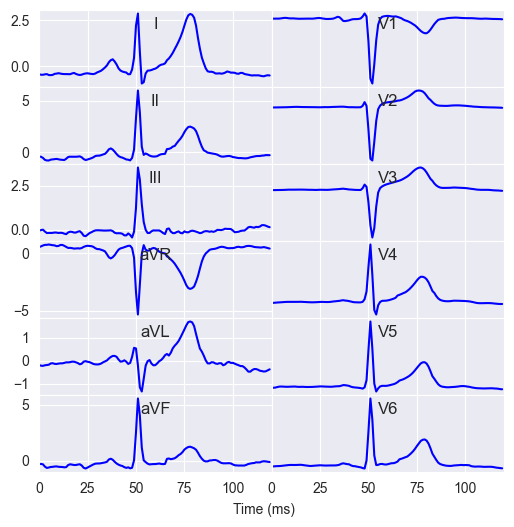

In [61]:
example_ecg_12 = ECGs_normalized[1,:,:]
plot_ecg(example_ecg_12, leads = 12, figsize = (20,6), show_voltage = False)
median_beats_12 = getECGpattern(example_ecg_12, fs=100, mode='median', 
                                window_left=52, window_right=68, 
                                show_figures=False, verbose=True)
plot_ecg(median_beats_12, leads = 12, figsize = (6,6), show_voltage = False)

As we can see, the use of median beats on a window of 1.2 sec (52 + 68) allowed us tu summarize the information of the entire ECG in a single heart activation. 

In [62]:
num_ecgs = ECGs_normalized.shape[0]
num_leads = ECGs_normalized.shape[2]
median_beats = np.zeros((num_ecgs, 120, num_leads))  # Shape: (21801, 120, 12)

for i in range(num_ecgs):
    ecg_signal = ECGs_normalized[i, :, :]  
    median_beats[i, :, :] = getECGpattern(ecg_signal, fs=100, mode='median', 
                                           window_left=52, window_right=68, 
                                           filtering=False, show_figures=False, verbose=False)

# median_beats now contains the median beat patterns for each ECG lead
np.save('median_beats_ECGs.npy', median_beats)
print("Saved median beats array with shape:", median_beats.shape)

Saved median beats array with shape: (21801, 120, 12)


In [30]:
median_beats = np.load('median_beats_ECGs.npy')

In [31]:
test_fold = 10
val_fold = 9

train_cond = np.where((metadata.strat_fold != test_fold) & (metadata.strat_fold != val_fold))[0]
test_cond = np.where(metadata.strat_fold == test_fold)[0]
val_cond = np.where(metadata.strat_fold == val_fold)[0]

feat_train = features.iloc[train_cond]
beats_train =  median_beats[train_cond]
labels_train = labels_encoded.iloc[train_cond]

feat_test = features.iloc[test_cond]
beats_test =  median_beats[test_cond]
labels_test = labels_encoded.iloc[test_cond]

feat_val = features.iloc[val_cond]
beats_val =  median_beats[val_cond]
labels_val = labels_encoded.iloc[val_cond]

Following the path from before, I use the best three performing models (CNN, CNN with residuals and LSTM + CNN with residuals) and train them on the median beats instead of the entire ECGs. 

#### CNN model with median beats

In [64]:
modelCNN_beats = create_CNN_feat_model(feat_train.shape, beats_train.shape, labels_train.shape)
modelCNN_beats.compile(optimizer='adam', loss='binary_crossentropy', metrics=['categorical_accuracy', 'Precision', 'Recall'])
modelCNN_beats.summary()

Model: "modelCNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 120, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 120, 64)   │      5,440 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 120, 64)   │        256 │ conv1d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_6 (ReLU)      │ (None, 120, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 60, 64)    │          0 │ re_lu_6[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 60, 128)   │     24,704 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 128)   │        512 │ conv1d_8[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_7 (ReLU)      │ (None, 60, 128)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 30, 128)   │          0 │ re_lu_7[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_10      │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 30, 256)   │     98,560 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 32)        │        416 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 256)   │      1,024 │ conv1d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 32)        │          0 │ dense_30[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_8 (ReLU)      │ (None, 30, 256)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 32)        │      1,056 │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ re_lu_8[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 32)        │          0 │ dense_31[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 256)       │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 154,949 (605.27 KB)

 Trainable params: 154,053 (601.77 KB)

 Non-trainable params: 896 (3.50 KB)

In [65]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=20)]

history = modelCNN_beats.fit([feat_train, beats_train], labels_train, epochs=100, batch_size=32, callbacks=callbacks_list, validation_data=([feat_val, beats_val], labels_val))

Epoch 1/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - Precision: 0.5719 - Recall: 0.2463 - categorical_accuracy: 0.4377 - loss: 0.7180 - val_Precision: 0.7927 - val_Recall: 0.4046 - val_categorical_accuracy: 0.6129 - val_loss: 0.3762
Epoch 2/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - Precision: 0.7771 - Recall: 0.4044 - categorical_accuracy: 0.6073 - loss: 0.4010 - val_Precision: 0.7606 - val_Recall: 0.5082 - val_categorical_accuracy: 0.6413 - val_loss: 0.3596
Epoch 3/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - Precision: 0.7982 - Recall: 0.4751 - categorical_accuracy: 0.6575 - loss: 0.3633 - val_Precision: 0.8000 - val_Recall: 0.5481 - val_categorical_accuracy: 0.6793 - val_loss: 0.3232
Epoch 4/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - Precision: 0.8132 - Recall: 0.5026 - categorical_accuracy: 0.6690 - loss: 0.3510 - val_Precision: 0.8064 - val_Recall: 0.5154 - val_categorical_accuracy: 0.6679 - val_loss: 0.3229
Epoch 5/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/st

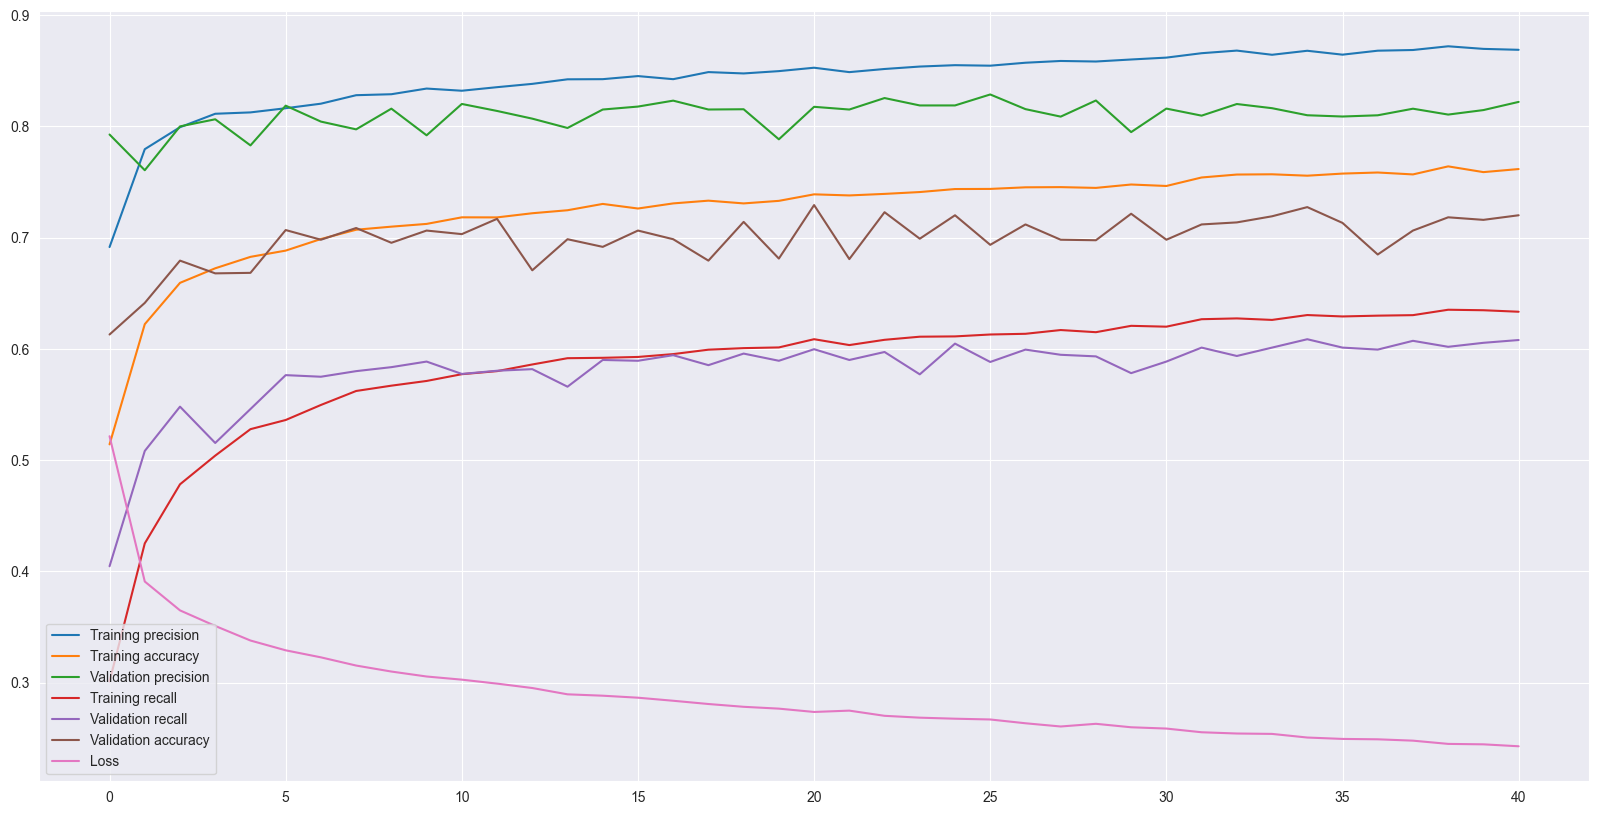

In [66]:
plt.figure(figsize=(20,10))
plt.plot(history.history['Precision'], label = 'Training precision')
plt.plot(history.history['categorical_accuracy'], label = 'Training accuracy')
plt.plot(history.history['val_Precision'], label = 'Validation precision')
plt.plot(history.history['Recall'], label = 'Training recall')
plt.plot(history.history['val_Recall'], label = 'Validation recall')
plt.plot(history.history['val_categorical_accuracy'], label = 'Validation accuracy')
plt.plot(history.history['loss'], label = 'Loss')
plt.legend()

In [67]:
modelCNN_beats.save('modelCNN_beats.keras') 

#### CNN residuals model with median beats

In [68]:
def CNN_residual(input_layer, num_classes=5):
    
    # Initial Conv layer
    current_layer = keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu')(input_layer)

    # 5 Residual Blocks
    for i in range(3):
        current_layer = residual_unit(i + 1, current_layer)

    # Flatten the layers
    output = keras.layers.Flatten()(current_layer)

    return output


In [69]:
modelCNN_residual_beats = create_CNN_residual_model(feat_train.shape, beats_train.shape, labels_train.shape)
modelCNN_residual_beats.compile(optimizer='adam', loss='binary_crossentropy', metrics=['categorical_accuracy', 'Precision', 'Recall'])
modelCNN_residual_beats.summary()

Model: "modelCNN_residuals"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 120, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 120, 32)   │      1,952 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_1 (Conv1D)    │ (None, 120, 32)   │      5,152 │ conv1d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2_1 (Conv1D)    │ (None, 120, 32)   │      5,152 │ Conv1_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ResidualSum_1 (Add) │ (None, 120, 32)   │          0 │ Conv2_1[0][0],    │
│                     │                   │            │ conv1d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Act_1 (Activation)  │ (None, 120, 32)   │          0 │ ResidualSum_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MaxPool_1           │ (None, 58, 32)    │          0 │ Act_1[0][0]       │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_2 (Conv1D)    │ (None, 58, 32)    │      5,152 │ MaxPool_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2_2 (Conv1D)    │ (None, 58, 32)    │      5,152 │ Conv1_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ResidualSum_2 (Add) │ (None, 58, 32)    │          0 │ Conv2_2[0][0],    │
│                     │                   │            │ MaxPool_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Act_2 (Activation)  │ (None, 58, 32)    │          0 │ ResidualSum_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MaxPool_2           │ (None, 27, 32)    │          0 │ Act_2[0][0]       │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_3 (Conv1D)    │ (None, 27, 32)    │      5,152 │ MaxPool_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_12      │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2_3 (Conv1D)    │ (None, 27, 32)    │      5,152 │ Conv1_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 32)        │        416 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ResidualSum_3 (Add) │ (None, 27, 32)    │          0 │ Conv2_3[0][0],    │
│                     │                   │            │ MaxPool_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 32)        │          0 │ dense_35[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Act_3 (Activation)  │ (None, 27, 32)    │          0 │ ResidualSum_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 32)        │      1,056 │ dropout_22[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MaxPool_3           │ (None, 12, 32)    │          0 │ Act_3[0][0]     

 Total params: 65,509 (255.89 KB)

 Trainable params: 65,509 (255.89 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=20)]

history = modelCNN_residual_beats.fit([feat_train, beats_train], labels_train, epochs=100, batch_size=32, callbacks=callbacks_list, validation_data=([feat_val, beats_val], labels_val))

Epoch 1/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - Precision: 0.6396 - Recall: 0.2970 - categorical_accuracy: 0.5075 - loss: 0.6216 - val_Precision: 0.7981 - val_Recall: 0.4792 - val_categorical_accuracy: 0.6574 - val_loss: 0.3511
Epoch 2/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - Precision: 0.8083 - Recall: 0.4968 - categorical_accuracy: 0.6689 - loss: 0.3642 - val_Precision: 0.8011 - val_Recall: 0.5344 - val_categorical_accuracy: 0.6551 - val_loss: 0.3291
Epoch 3/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - Precision: 0.8185 - Recall: 0.5441 - categorical_accuracy: 0.6825 - loss: 0.3242 - val_Precision: 0.7854 - val_Recall: 0.4871 - val_categorical_accuracy: 0.6377 - val_loss: 0.3480
Epoch 4/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - Precision: 0.8311 - Recall: 0.5656 - categorical_accuracy: 0.7081 - loss: 0.3100 - val_Precision: 0.8145 - val_Recall: 0.5699 - val_categorical_accuracy: 0.6899 - val_loss: 0.3003
Epoch 5/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - 

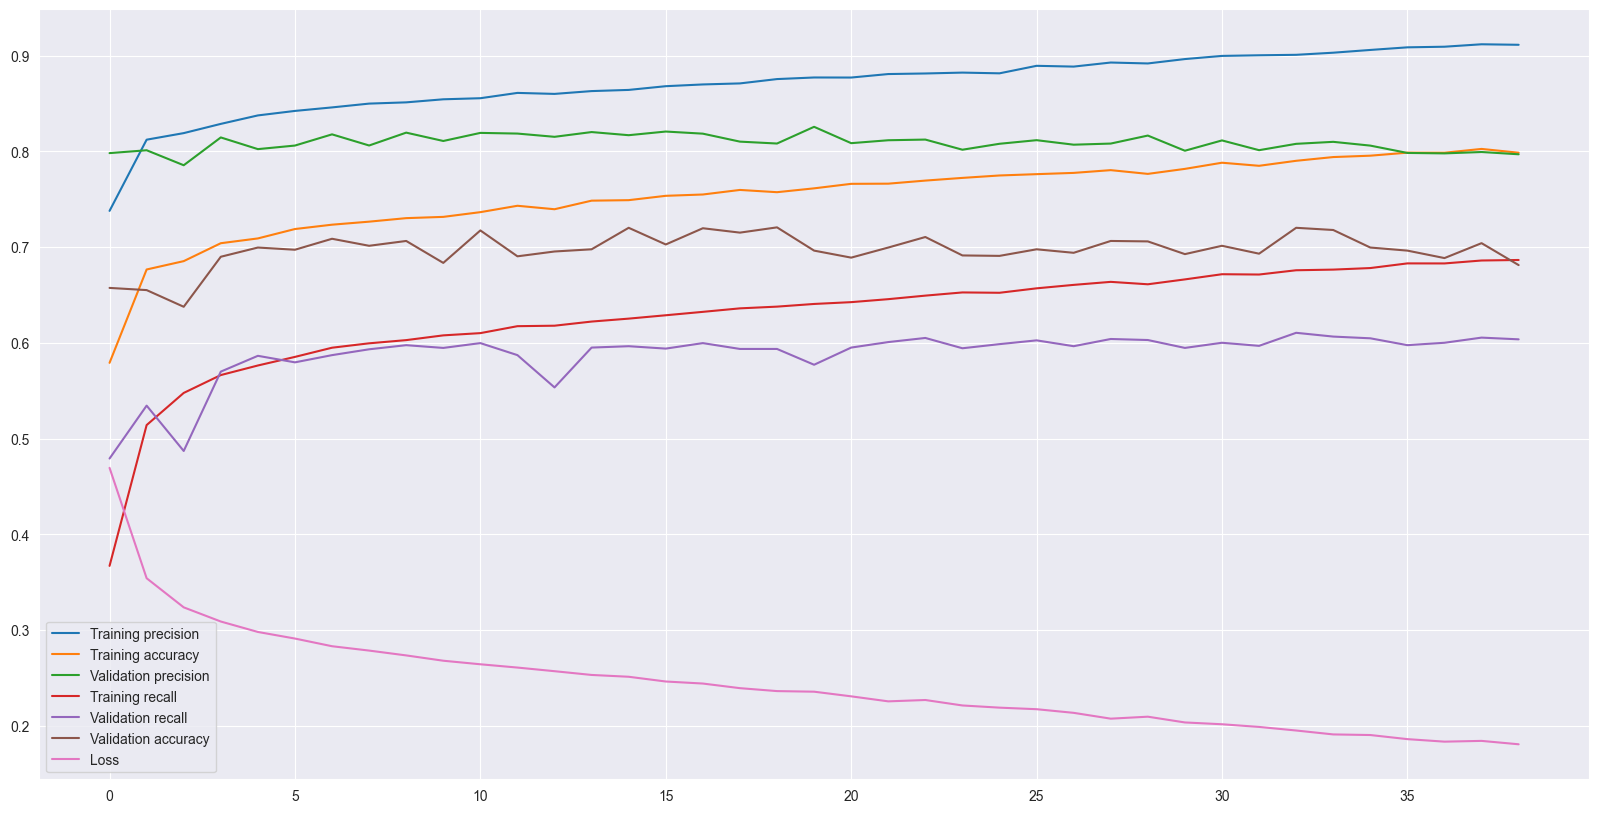

In [71]:
plt.figure(figsize=(20,10))
plt.plot(history.history['Precision'], label = 'Training precision')
plt.plot(history.history['categorical_accuracy'], label = 'Training accuracy')
plt.plot(history.history['val_Precision'], label = 'Validation precision')
plt.plot(history.history['Recall'], label = 'Training recall')
plt.plot(history.history['val_Recall'], label = 'Validation recall')
plt.plot(history.history['val_categorical_accuracy'], label = 'Validation accuracy')
plt.plot(history.history['loss'], label = 'Loss')
plt.legend()

In [72]:
modelCNN_residual_beats.save('modelCNN_residual_beats.keras') 

#### LSTM + CNN residuals model with median beats

In [75]:
def create_CNN_residuals_LSTM_model(feat_shape, ecg_shape, label_shape):
    
    feat_inputs = keras.Input(feat_shape[1:])
    ecg_inputs = keras.Input(ecg_shape[1:])

    model_feat = create_feat_model(feat_inputs)
    model_LSTM = RNN_LSTM_ECG_model(ecg_inputs)
    model_CNN = CNN_residual(ecg_inputs)


    X = keras.layers.Concatenate()([model_feat, model_LSTM, model_CNN])
    
    X = keras.layers.Dense(64, activation='relu')(X)
    X = keras.layers.Dense(64, activation='relu')(X)
    X = keras.layers.Dropout(0.5)(X)
    outputs = keras.layers.Dense(label_shape[-1], activation='softmax')(X)

    model = keras.Model(inputs=[feat_inputs, ecg_inputs], outputs=outputs, name='modelLSTM')
    return model

In [77]:
CNN_residuals_LSTM_model_beats = create_CNN_residuals_LSTM_model(feat_train.shape, beats_train.shape, labels_train.shape)
CNN_residuals_LSTM_model_beats.compile(optimizer='adam', loss='binary_crossentropy', metrics=['categorical_accuracy', 'Precision', 'Recall'])
CNN_residuals_LSTM_model_beats.summary()

Model: "modelLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 120, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 120, 32)   │      1,952 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_1 (Conv1D)    │ (None, 120, 32)   │      5,152 │ conv1d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2_1 (Conv1D)    │ (None, 120, 32)   │      5,152 │ Conv1_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ResidualSum_1 (Add) │ (None, 120, 32)   │          0 │ Conv2_1[0][0],    │
│                     │                   │            │ conv1d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Act_1 (Activation)  │ (None, 120, 32)   │          0 │ ResidualSum_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MaxPool_1           │ (None, 58, 32)    │          0 │ Act_1[0][0]       │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_2 (Conv1D)    │ (None, 58, 32)    │      5,152 │ MaxPool_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2_2 (Conv1D)    │ (None, 58, 32)    │      5,152 │ Conv1_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ResidualSum_2 (Add) │ (None, 58, 32)    │          0 │ Conv2_2[0][0],    │
│                     │                   │            │ MaxPool_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Act_2 (Activation)  │ (None, 58, 32)    │          0 │ ResidualSum_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MaxPool_2           │ (None, 27, 32)    │          0 │ Act_2[0][0]       │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_3 (Conv1D)    │ (None, 27, 32)    │      5,152 │ MaxPool_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_18      │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2_3 (Conv1D)    │ (None, 27, 32)    │      5,152 │ Conv1_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_47 (Dense)    │ (None, 32)        │        416 │ input_layer_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ResidualSum_3 (Add) │ (None, 27, 32)    │          0 │ Conv2_3[0][0],    │
│                     │                   │            │ MaxPool_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 32)        │          0 │ dense_47[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Act_3 (Activation)  │ (None, 27, 32)    │          0 │ ResidualSum_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_48 (Dense)    │ (None, 32)        │      1,056 │ dropout_30[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 120, 32)   │      5,760 │ input_layer_19[0

 Total params: 81,637 (318.89 KB)

 Trainable params: 81,637 (318.89 KB)

 Non-trainable params: 0 (0.00 B)

In [79]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=10)]

history = CNN_residuals_LSTM_model_beats.fit([feat_train, beats_train], labels_train, epochs=30, batch_size=32, callbacks=callbacks_list, validation_data=([feat_val, beats_val], labels_val))

Epoch 1/30
545/545 ━━━━━━━━━━━━━━━━━━━━ 36s 65ms/step - Precision: 0.6088 - Recall: 0.2542 - categorical_accuracy: 0.4538 - loss: 0.6034 - val_Precision: 0.7682 - val_Recall: 0.4613 - val_categorical_accuracy: 0.5813 - val_loss: 0.3744
Epoch 2/30
545/545 ━━━━━━━━━━━━━━━━━━━━ 35s 64ms/step - Precision: 0.7988 - Recall: 0.4543 - categorical_accuracy: 0.6331 - loss: 0.3766 - val_Precision: 0.8121 - val_Recall: 0.5395 - val_categorical_accuracy: 0.6725 - val_loss: 0.3280
Epoch 3/30
545/545 ━━━━━━━━━━━━━━━━━━━━ 37s 68ms/step - Precision: 0.8185 - Recall: 0.5255 - categorical_accuracy: 0.6823 - loss: 0.3354 - val_Precision: 0.8194 - val_Recall: 0.5502 - val_categorical_accuracy: 0.6798 - val_loss: 0.3067
Epoch 4/30
545/545 ━━━━━━━━━━━━━━━━━━━━ 36s 65ms/step - Precision: 0.8282 - Recall: 0.5632 - categorical_accuracy: 0.6990 - loss: 0.3137 - val_Precision: 0.8206 - val_Recall: 0.5642 - val_categorical_accuracy: 0.7041 - val_loss: 0.3019
Epoch 5/30
545/545 ━━━━━━━━━━━━━━━━━━━━ 38s 70ms/step - 

In [ ]:
CNN_residuals_LSTM_model_beats.save('CNN_residuals_LSTM_model_beats.keras') 

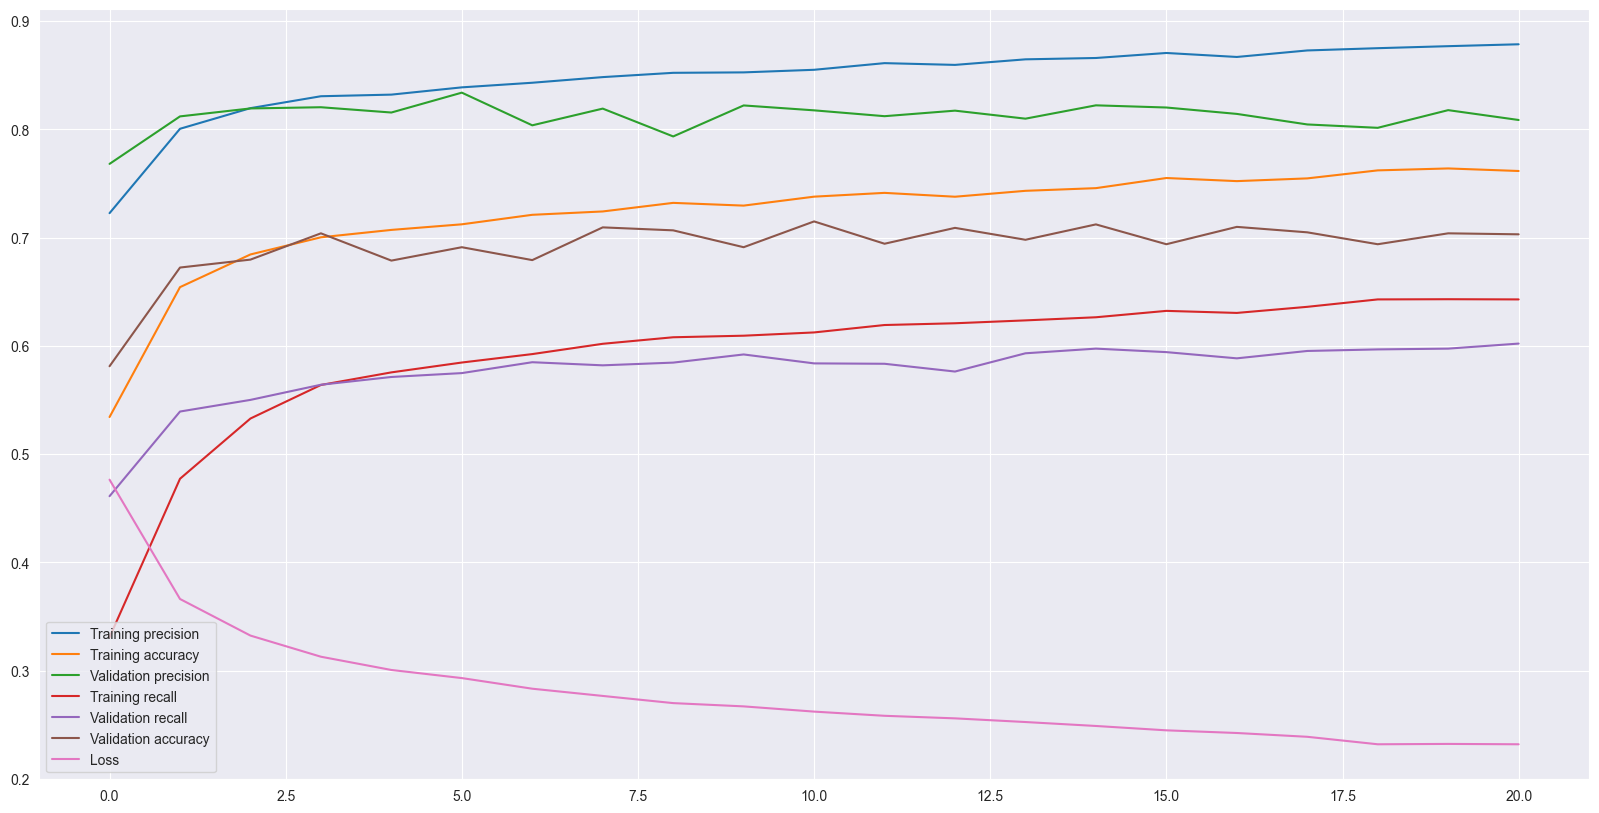

In [80]:
plt.figure(figsize=(20,10))
plt.plot(history.history['Precision'], label = 'Training precision')
plt.plot(history.history['categorical_accuracy'], label = 'Training accuracy')
plt.plot(history.history['val_Precision'], label = 'Validation precision')
plt.plot(history.history['Recall'], label = 'Training recall')
plt.plot(history.history['val_Recall'], label = 'Validation recall')
plt.plot(history.history['val_categorical_accuracy'], label = 'Validation accuracy')
plt.plot(history.history['loss'], label = 'Loss')
plt.legend()

### Analisis of the Median Beats models:

As before, I use CM and ROC AUC to analyse the performance of the median beats models. PR AUC was not used as I considered that CM and ROC AUC were enough to evaluate the models

Baseline model:


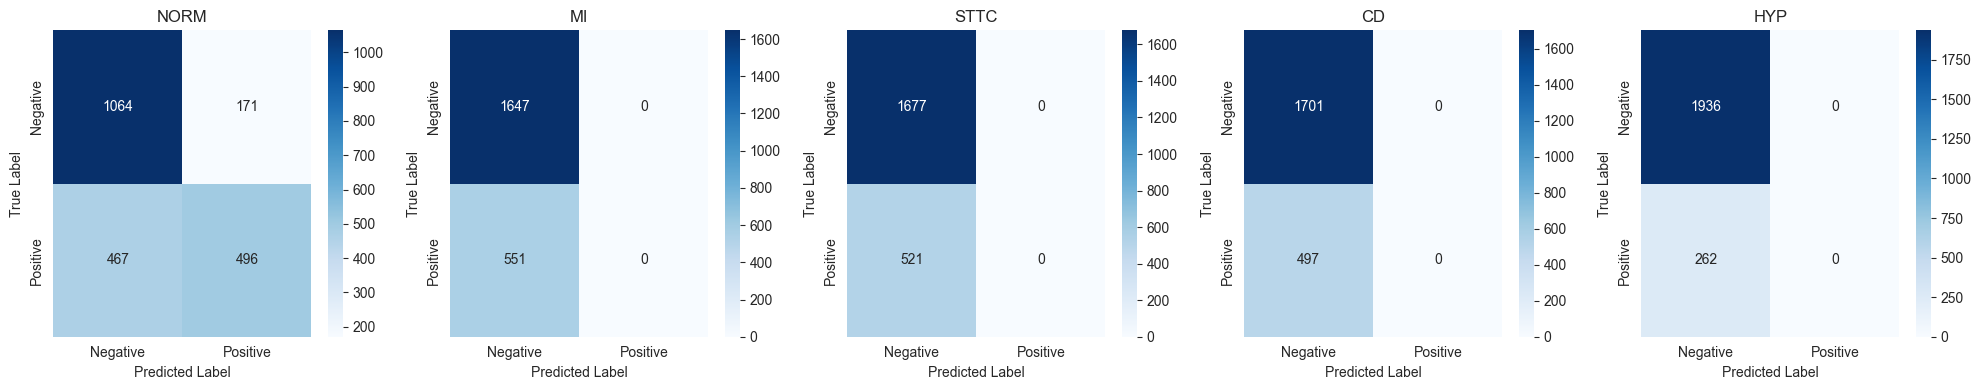

modelCNN_beats:
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


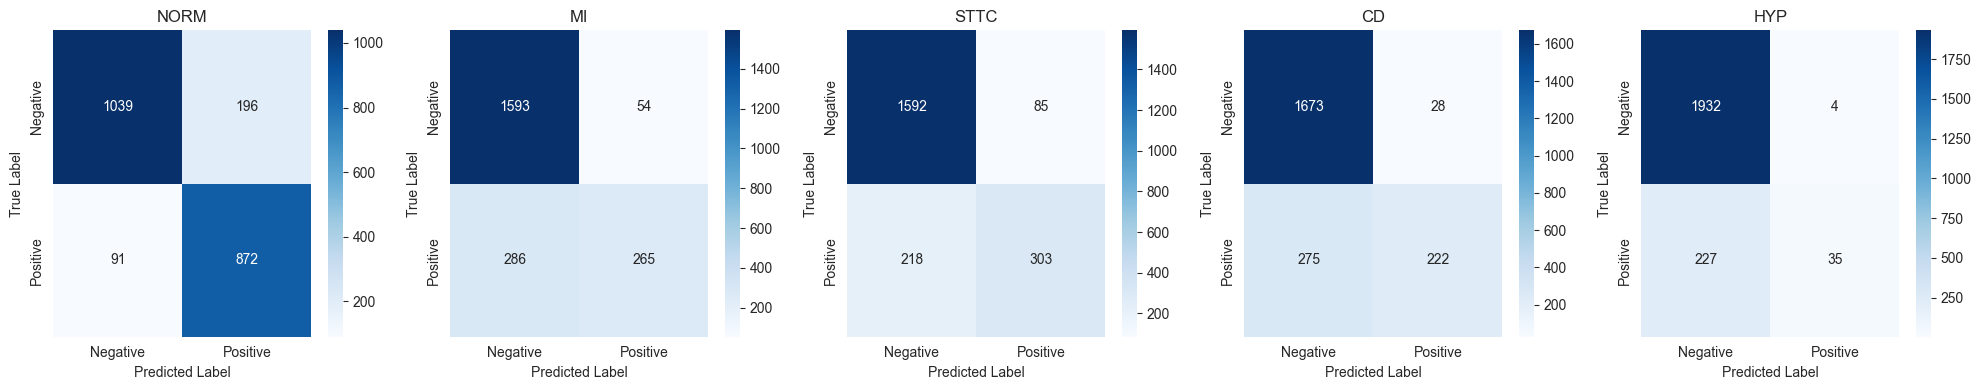

modelCNN_residual_beats:
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


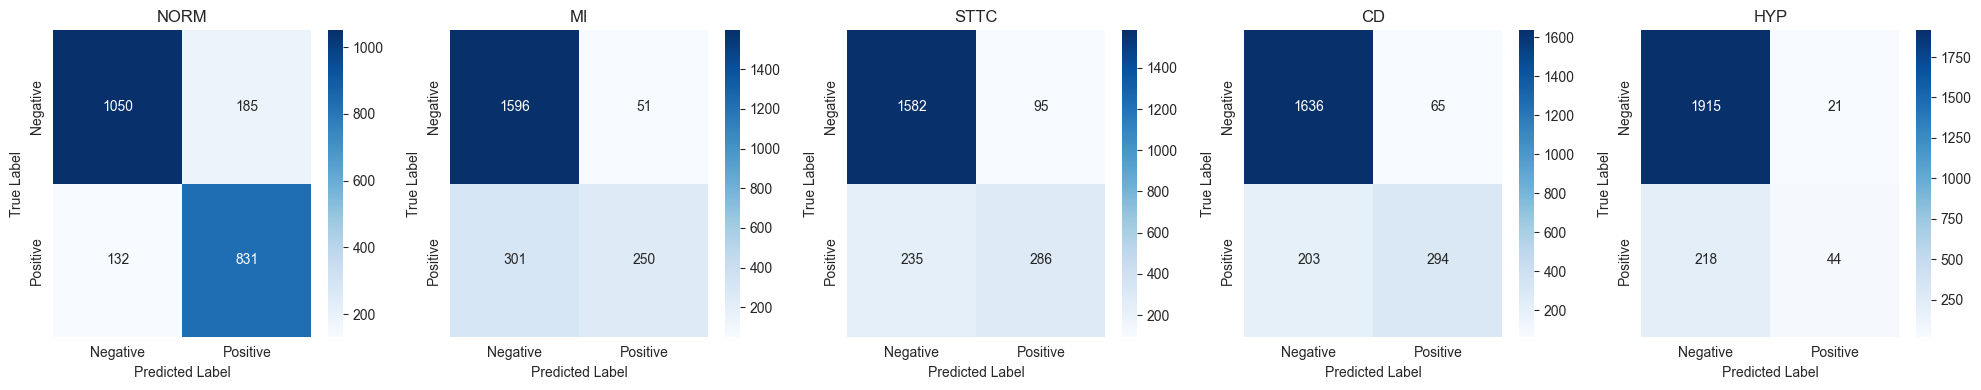

CNN_residuals_LSTM_model_beats:
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


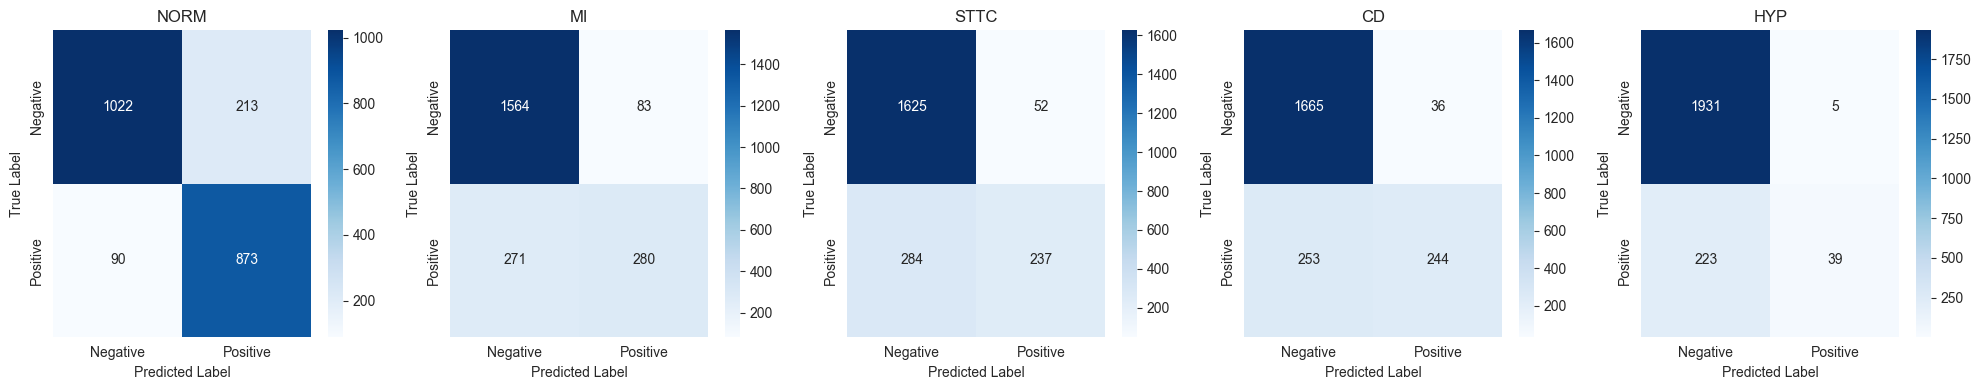

In [83]:
label_classes = ["NORM", "MI", "STTC", "CD", "HYP"]
threshold = 0.5
pred_labels_baseline = (pred_baseline >= threshold).astype(int)

print('Baseline model:')
plot_five_classes_cm(labels_test, pred_labels_baseline, label_classes)

threshold = 0.5
model_names = ['modelCNN_beats','modelCNN_residual_beats','CNN_residuals_LSTM_model_beats']
models = {
    'modelCNN_beats': modelCNN_beats,
    'modelCNN_residual_beats': modelCNN_residual_beats,
    'CNN_residuals_LSTM_model_beats': CNN_residuals_LSTM_model_beats
}

for i, name_model in enumerate(model_names):
    print(f'{name_model}:')
    pred =  models[name_model].predict([feat_test, beats_test])
    pred_labels = (pred >= threshold).astype(int)
    plot_five_classes_cm(labels_test, pred_labels, label_classes)

Baseline model:


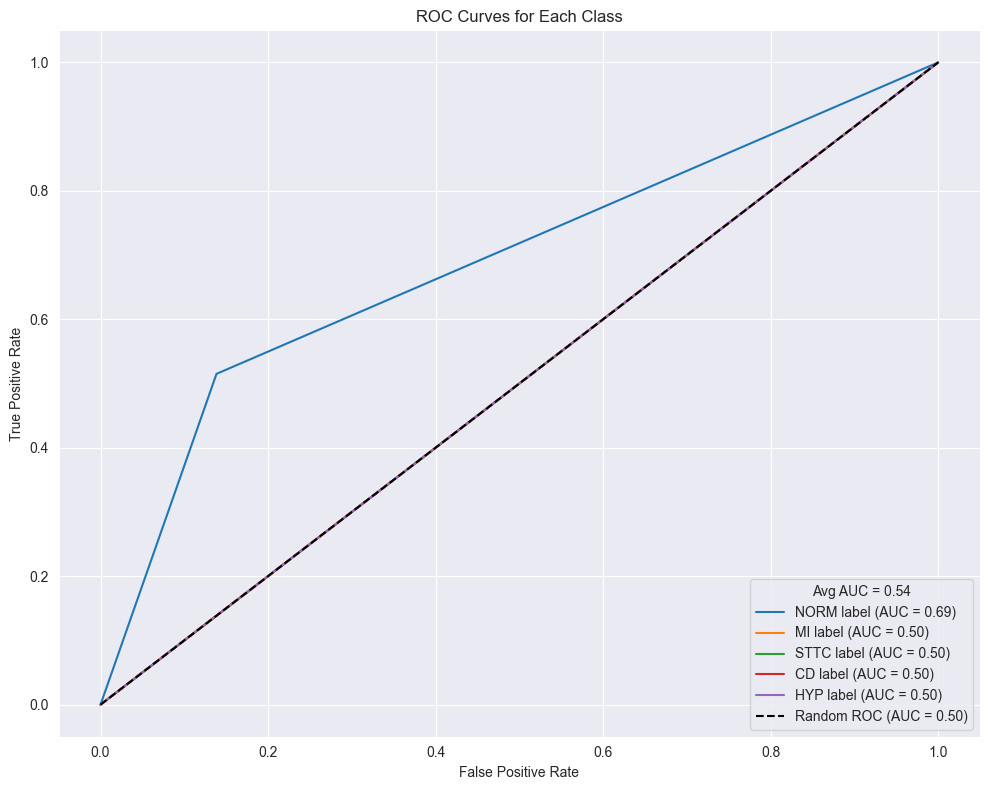

modelCNN_beats:
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


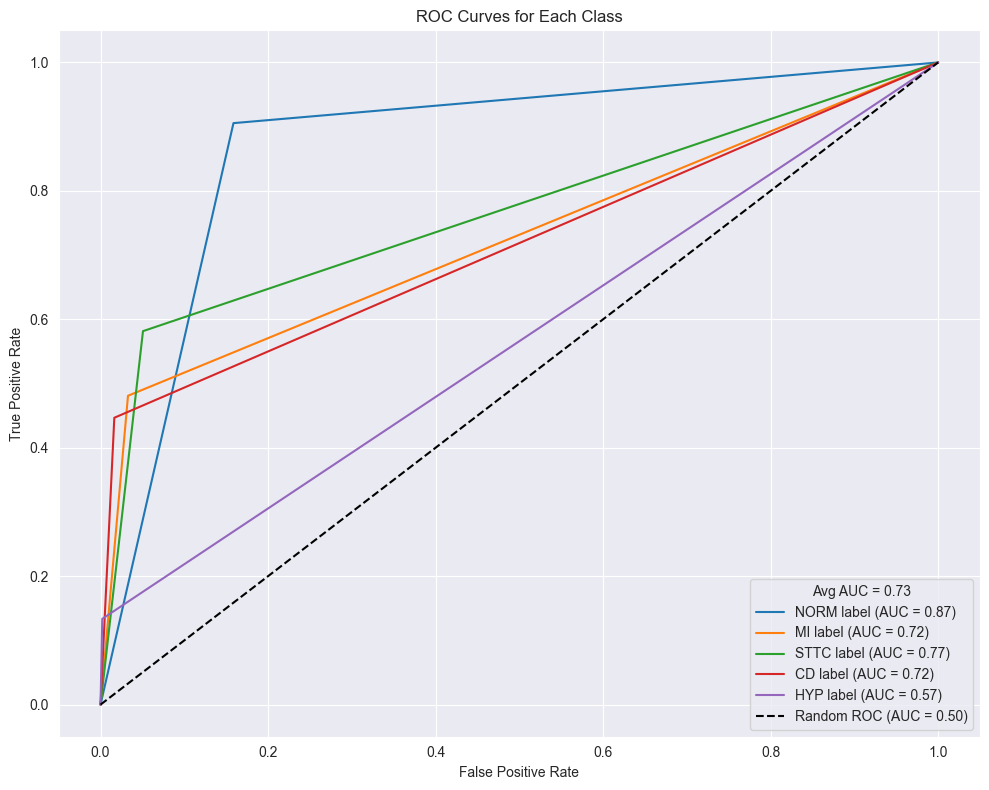

modelCNN_residual_beats:
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


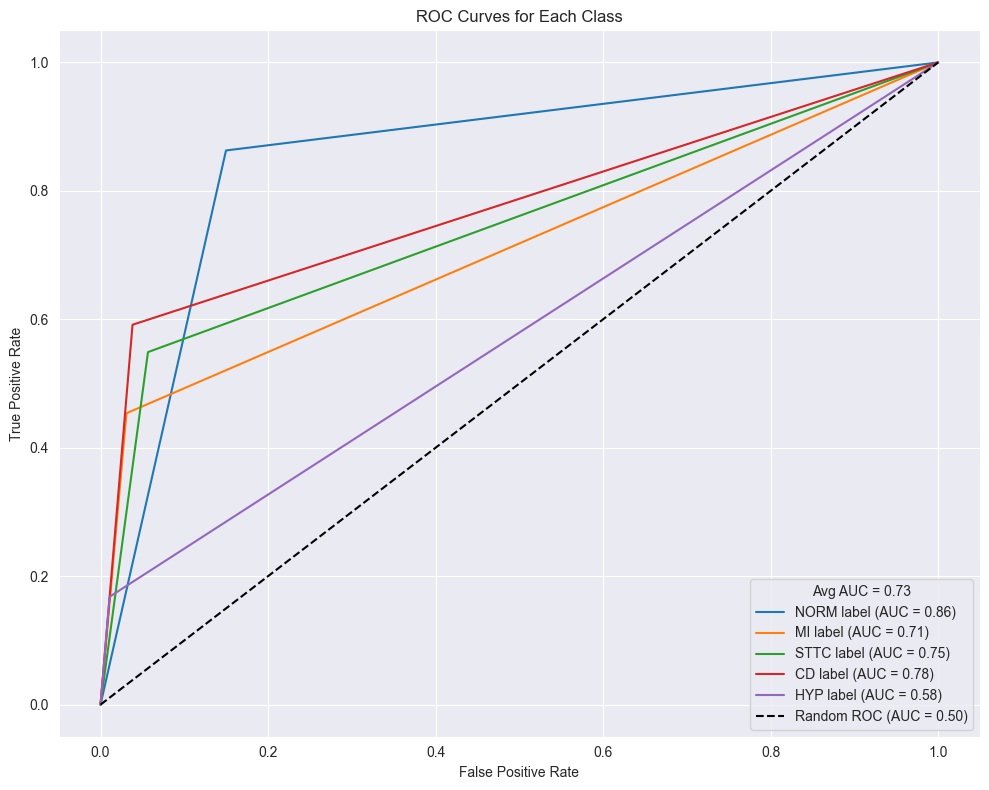

CNN_residuals_LSTM_model_beats:
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


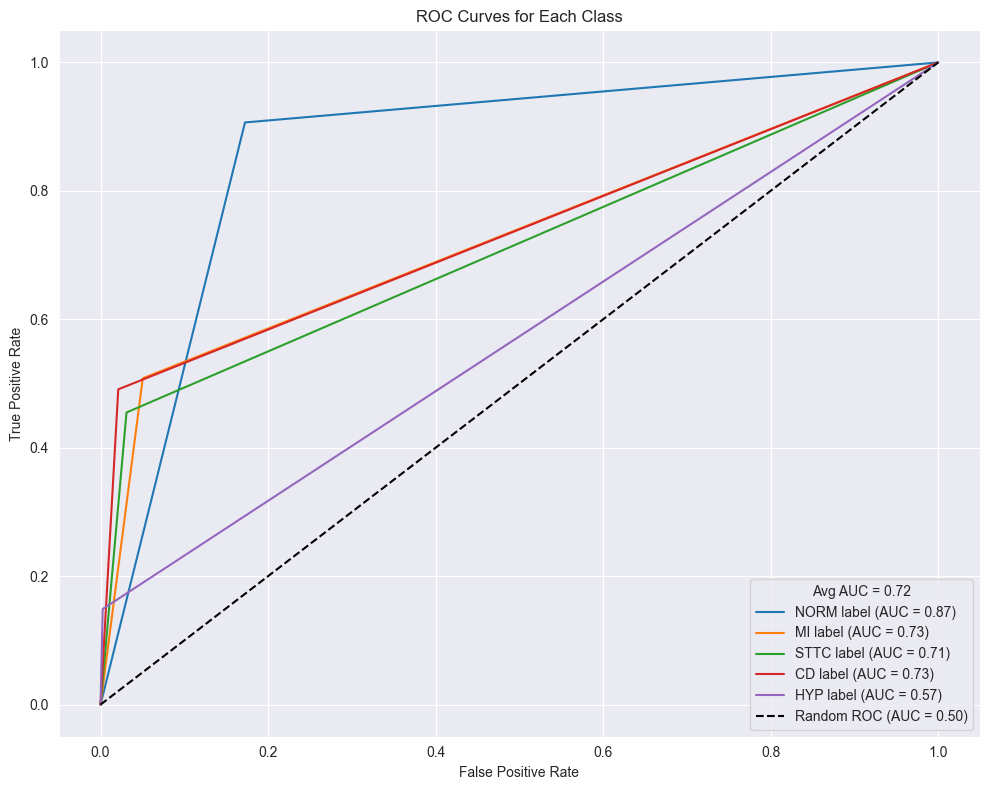

In [85]:
print('Baseline model:')
pred_labels_baseline = (pred_baseline >= threshold).astype(int)
avg_roc_auc = plot_five_classes_roc(np.array(labels_test), pred_labels_baseline, label_classes)

for name_model in model_names:
    print(f'{name_model}:')
    pred = models[name_model].predict([feat_test, beats_test])
    pred_labels = (pred >= threshold).astype(int)
    avg_roc_auc = plot_five_classes_roc(np.array(labels_test), pred_labels, label_classes)

As it is shown in the plots, the use of median beats was very similar to the original results with the advantage to have a reduced computational cost. Thus, the use of median beats is also a interesting path to explore in the future.

### Creating a hand-made ECG featurizer

Another idea that I considered is to use a hand-made ECG featurizer to extract meaningful additional information from the ECG to help the model to focus on other patterns. For that purpouse, I use the neurokit function 'ecg_process' that is able to extract efficiently the position of the different peaks (P, Q, R, S and T) from the ECG. From that I compute the mean distance between those peaks as new features to be incorporeted to the features that we already have.

In [15]:
def ecg_featurizer(ecg_signals, sampling_rate=100):
    """
    Process and extract relevant features from 12-lead ECG signals.
    
    Parameters:
    - ecg_signals: A numpy array or DataFrame containing 12-lead ECG signals, 
                   with shape (n_samples, 12).
    - sampling_rate: The sampling rate of the ECG signals (in Hz). Default is 100.
    
    Returns:
    - features_df: A DataFrame containing the aggregated features for the 12-lead ECG signal.
    """
    # Define a DataFrame with zeros for the features
    features = {
        "mean_heart_rate": 0.0,
        "mean_rq_distance": 0.0,
        "mean_rt_distance": 0.0,
        "mean_pr_distance": 0.0,
        "mean_qt_distance": 0.0,
        "mean_tp_distance": 0.0,
        "mean_st_distance": 0.0,
    }

    try:
        heart_rate_per_lead = []
        rq_distance_per_lead = []
        rt_distance_per_lead = []
        pr_distance_per_lead = []
        qt_distance_per_lead = []
        tp_distance_per_lead = []
        st_distance_per_lead = []

        def average_peak_distance(peaks1, peaks2):
            peaks1 = np.array(peaks1)[~np.isnan(peaks1)]
            peaks2 = np.array(peaks2)[~np.isnan(peaks2)]
            if len(peaks1) > 0 and len(peaks2) > 0:
                distances = np.abs(np.subtract.outer(peaks1, peaks2))
                min_distances = distances.min(axis=1)  # Nearest corresponding peak
                return np.mean(min_distances)
            else:
                return np.nan

        for lead_idx in range(ecg_signals.shape[1]):
            lead_signal = ecg_signals[:, lead_idx]
            
            _, ECG_info = nk.ecg_process(lead_signal, sampling_rate=sampling_rate)

            r_peaks = ECG_info['ECG_R_Peaks']
            p_peaks = ECG_info['ECG_P_Peaks']
            q_peaks = ECG_info['ECG_Q_Peaks']
            t_peaks = ECG_info['ECG_T_Peaks']
            s_peaks = ECG_info['ECG_S_Peaks']

            r_peaks = np.array(r_peaks)[~np.isnan(r_peaks)]
            if len(r_peaks) > 1:
                rr_intervals = np.diff(r_peaks) / sampling_rate  # To seconds
                heart_rate = 60 / np.mean(rr_intervals)  # To bpm
            else:
                heart_rate = np.nan
            heart_rate_per_lead.append(heart_rate)

            rq_distance_per_lead.append(average_peak_distance(r_peaks, q_peaks))  # R-Q interval
            rt_distance_per_lead.append(average_peak_distance(r_peaks, t_peaks))  # R-T interval
            pr_distance_per_lead.append(average_peak_distance(p_peaks, r_peaks))  # P-R interval
            qt_distance_per_lead.append(average_peak_distance(q_peaks, t_peaks))  # Q-T interval
            tp_distance_per_lead.append(average_peak_distance(t_peaks, p_peaks))  # T-P interval
            st_distance_per_lead.append(average_peak_distance(s_peaks, t_peaks))  # S-T interval

        # Aggregate the features by averaging across all 12 leads
        features = {
            "mean_heart_rate": np.nanmean(heart_rate_per_lead),
            "mean_rq_distance": np.nanmean(rq_distance_per_lead),
            "mean_rt_distance": np.nanmean(rt_distance_per_lead),
            "mean_pr_distance": np.nanmean(pr_distance_per_lead),
            "mean_qt_distance": np.nanmean(qt_distance_per_lead),
            "mean_tp_distance": np.nanmean(tp_distance_per_lead),
            "mean_st_distance": np.nanmean(st_distance_per_lead),
        }

    except Exception as e:
        print(f"Error processing ECG signals: {e}")
        # Features remain as initialized with zeros if an error happens as the nk function does not always perform well on the ECGs

    # Convert the features dictionary into a DataFrame (one row per 12-lead ECG signal)
    features_df = pd.DataFrame([features])

    return features_df


In [16]:
example_ECG = ECGs_normalized[7,:,:]
extra_feature_example_ecg = ecg_featurizer(example_ECG)
processed_signal, extra_info = nk.ecg_process(example_ECG[:,1], sampling_rate = 100)
extra_feature_example_ecg

mean_heart_rate  mean_rq_distance  mean_rt_distance  mean_pr_distance   
0        71.818942         14.431944         26.696465         17.041204  \

   mean_qt_distance  mean_tp_distance  mean_st_distance  
0         31.910927         37.792929         22.131657

In [311]:
extra_feature_list = []

for i in range(ecg_train.shape[0]):
    extra_feature_ecg = ecg_featurizer(ecg_train[i, :, :])
    extra_feature_list.append(np.array(extra_feature_ecg).flatten())

extra_feature_train = pd.DataFrame(extra_feature_list, columns= extra_feature_example_ecg.columns.tolist())
extra_feature_train.to_csv('extra_feature_train.csv', index=False)

extra_feature_train.head()

Error processing ECG signals: cannot convert float NaN to integer
Error processing ECG signals: cannot convert float NaN to integer
Error processing ECG signals: cannot convert float NaN to integer
Error processing ECG signals: cannot convert float NaN to integer
Error processing ECG signals: integer division or modulo by zero
Error processing ECG signals: cannot convert float NaN to integer
Error processing ECG signals: cannot convert float NaN to integer
Error processing ECG signals: cannot convert float NaN to integer
Error processing ECG signals: cannot convert float NaN to integer
Error processing ECG signals: cannot convert float NaN to integer
Error processing ECG signals: cannot convert float NaN to integer
Error processing ECG signals: integer division or modulo by zero
Error processing ECG signals: integer division or modulo by zero
Error processing ECG signals: cannot convert float NaN to integer
Error processing ECG signals: cannot convert float NaN to integer
Error process

mean_heart_rate  mean_rq_distance  mean_rt_distance  mean_pr_distance   
0        65.098753         14.896154         25.931410         13.910897  \
1        47.154403         23.125000         33.464286         19.138393   
2        64.355354         16.478283         25.591414         15.284933   
3        74.969906         11.265491         27.865385         16.558120   
4        65.586736         14.517424         29.607997         15.102083   

   mean_qt_distance  mean_tp_distance  mean_st_distance  
0         31.048611         39.534615         19.747685  
1         35.281349         44.706349         25.154762  
2         31.238889         38.897348         19.242361  
3         30.601010         34.042929         20.883838  
4         35.043287         39.448106         24.926157

In [312]:
extra_feature_list = []
for i in range(ecg_test.shape[0]):
    extra_feature_ecg = ecg_featurizer(ecg_test[i, :, :])
    extra_feature_list.append(np.array(extra_feature_ecg).flatten())

extra_feature_test = pd.DataFrame(extra_feature_list, columns= extra_feature_example_ecg.columns.tolist())
extra_feature_test.to_csv('extra_feature_test.csv', index=False)

extra_feature_list = []
for i in range(ecg_val.shape[0]):
    extra_feature_ecg = ecg_featurizer(ecg_val[i, :, :])
    extra_feature_list.append(np.array(extra_feature_ecg).flatten())

extra_feature_val = pd.DataFrame(extra_feature_list, columns= extra_feature_example_ecg.columns.tolist())
extra_feature_val.to_csv('extra_feature_val.csv', index=False)

Error processing ECG signals: cannot convert float NaN to integer
Error processing ECG signals: cannot convert float NaN to integer
Error processing ECG signals: cannot convert float NaN to integer
Error processing ECG signals: cannot convert float NaN to integer
Error processing ECG signals: cannot convert float NaN to integer
Error processing ECG signals: cannot convert float NaN to integer
Error processing ECG signals: cannot convert float NaN to integer
Error processing ECG signals: integer division or modulo by zero
Error processing ECG signals: integer division or modulo by zero
Error processing ECG signals: cannot convert float NaN to integer
Error processing ECG signals: cannot convert float NaN to integer
Error processing ECG signals: cannot convert float NaN to integer
Error processing ECG signals: cannot convert float NaN to integer
Error processing ECG signals: cannot convert float NaN to integer
Error processing ECG signals: cannot convert float NaN to integer
Error proces

In [86]:
combined_feat_train = pd.concat([feat_train.reset_index(drop=True), extra_feature_train.reset_index(drop=True)], axis=1)
combined_feat_test = pd.concat([feat_test.reset_index(drop=True), extra_feature_test.reset_index(drop=True)], axis=1)
combined_feat_val = pd.concat([feat_val.reset_index(drop=True), extra_feature_val.reset_index(drop=True)], axis=1)

combined_feat_train.head()


age       sex    height    weight  pacemaker  heart_axis_ARAD   
0 -0.152091  1.042698 -0.683751  0.880889  -0.115091        -0.075017  \
1 -2.207476 -0.959051 -0.683751  1.071696  -0.115091        -0.075017   
2 -1.207559  1.042698 -0.683751  1.044438  -0.115091        -0.075017   
3 -1.929721 -0.959051 -0.683751  1.398793  -0.115091        -0.075017   
4 -2.207476  1.042698 -0.683751  1.071696  -0.115091        -0.075017   

   heart_axis_AXL  heart_axis_AXR  heart_axis_LAD  heart_axis_MID   
0       -0.068223       -0.048423       -0.456817       -0.737995  \
1       -0.068223       -0.048423       -0.456817       -0.737995   
2       -0.068223       -0.048423       -0.456817       -0.737995   
3       -0.068223       -0.048423       -0.456817       -0.737995   
4       -0.068223       -0.048423       -0.456817       -0.737995   

   heart_axis_RAD  heart_axis_SAG  mean_heart_rate  mean_rq_distance   
0       -0.101198       -0.011731        65.098753         14.896154  \
1       -0.101198       -0.011731        47.154403         23.125000   
2       -0.101198       -0.011731        64.355354         16.478283   
3       -0.101198       -0.011731        74.969906         11.265491   
4       -0.101198       -0.011731        65.586736         14.517424   

   mean_rt_distance  mean_pr_distance  mean_qt_distance  mean_tp_distance   
0         25.931410         13.910897         31.048611         39.534615  \
1         33.464286         19.138393         35.281349         44.706349   
2         25.591414         15.284933         31.238889         38.897348   
3         27.865385         16.558120         30.601010         34.042929   
4         29.607997         15.102083         35.043287         39.448106   

   mean_st_distance  
0         19.747685  
1         25.154762  
2         19.242361  
3         20.883838  
4         24.926157

After that, I use only one of the best-performing models to try out the impact of the addition of this new features on the performance. In this case, I took the CNN with residuals model.

In [52]:
modelCNN_residual_extra_features = create_CNN_residual_model(combined_feat_train.shape, ecg_train.shape, labels_train.shape)
modelCNN_residual_extra_features.compile(optimizer='adam', loss='binary_crossentropy', metrics=['categorical_accuracy', 'Precision', 'Recall'])
modelCNN_residual_extra_features.summary()

Model: "modelCNN_residuals"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 1000, 12)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 1000, 32)  │      1,952 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_1 (Conv1D)    │ (None, 1000, 32)  │      5,152 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2_1 (Conv1D)    │ (None, 1000, 32)  │      5,152 │ Conv1_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ResidualSum_1 (Add) │ (None, 1000, 32)  │          0 │ Conv2_1[0][0],    │
│                     │                   │            │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Act_1 (Activation)  │ (None, 1000, 32)  │          0 │ ResidualSum_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MaxPool_1           │ (None, 498, 32)   │          0 │ Act_1[0][0]       │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_2 (Conv1D)    │ (None, 498, 32)   │      5,152 │ MaxPool_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2_2 (Conv1D)    │ (None, 498, 32)   │      5,152 │ Conv1_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ResidualSum_2 (Add) │ (None, 498, 32)   │          0 │ Conv2_2[0][0],    │
│                     │                   │            │ MaxPool_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Act_2 (Activation)  │ (None, 498, 32)   │          0 │ ResidualSum_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MaxPool_2           │ (None, 247, 32)   │          0 │ Act_2[0][0]       │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_3 (Conv1D)    │ (None, 247, 32)   │      5,152 │ MaxPool_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2_3 (Conv1D)    │ (None, 247, 32)   │      5,152 │ Conv1_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ResidualSum_3 (Add) │ (None, 247, 32)   │          0 │ Conv2_3[0][0],    │
│                     │                   │            │ MaxPool_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Act_3 (Activation)  │ (None, 247, 32)   │          0 │ ResidualSum_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MaxPool_3           │ (None, 122, 32)   │          0 │ Act_3[0][0]       │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_4 (Conv1D)    │ (None, 122, 32)   │      5,152 │ MaxPool_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2_4 (Conv1D)    │ (None, 122, 32)   │      5,152 │ Conv1_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ResidualSum_4 (Add) │ (None, 122, 32)   │          0 │ Conv2_4[0][0],    │
│                     │                   │            │ MaxPool_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Act_4 (Activation)  │ (None, 122, 32)   │          0 │ ResidualSum_4[0]

 Total params: 119,109 (465.27 KB)

 Trainable params: 119,109 (465.27 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=15)]

history = modelCNN_residual_extra_features.fit([combined_feat_train, ecg_train], labels_train, epochs=100, batch_size=32, callbacks=callbacks_list, validation_data=([combined_feat_val, ecg_val], labels_val))

Epoch 1/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - Precision: 0.5791 - Recall: 0.2111 - categorical_accuracy: 0.4173 - loss: 0.6104 - val_Precision: 0.7820 - val_Recall: 0.4709 - val_categorical_accuracy: 0.6651 - val_loss: 0.3695
Epoch 2/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step - Precision: 0.7988 - Recall: 0.4638 - categorical_accuracy: 0.6630 - loss: 0.3796 - val_Precision: 0.7906 - val_Recall: 0.5104 - val_categorical_accuracy: 0.6858 - val_loss: 0.3453
Epoch 3/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - Precision: 0.8159 - Recall: 0.5165 - categorical_accuracy: 0.6818 - loss: 0.3451 - val_Precision: 0.8111 - val_Recall: 0.5789 - val_categorical_accuracy: 0.7013 - val_loss: 0.3129
Epoch 4/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 30s 56ms/step - Precision: 0.8294 - Recall: 0.5553 - categorical_accuracy: 0.7013 - loss: 0.3196 - val_Precision: 0.8083 - val_Recall: 0.5581 - val_categorical_accuracy: 0.6917 - val_loss: 0.3039
Epoch 5/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 27s 49ms/st

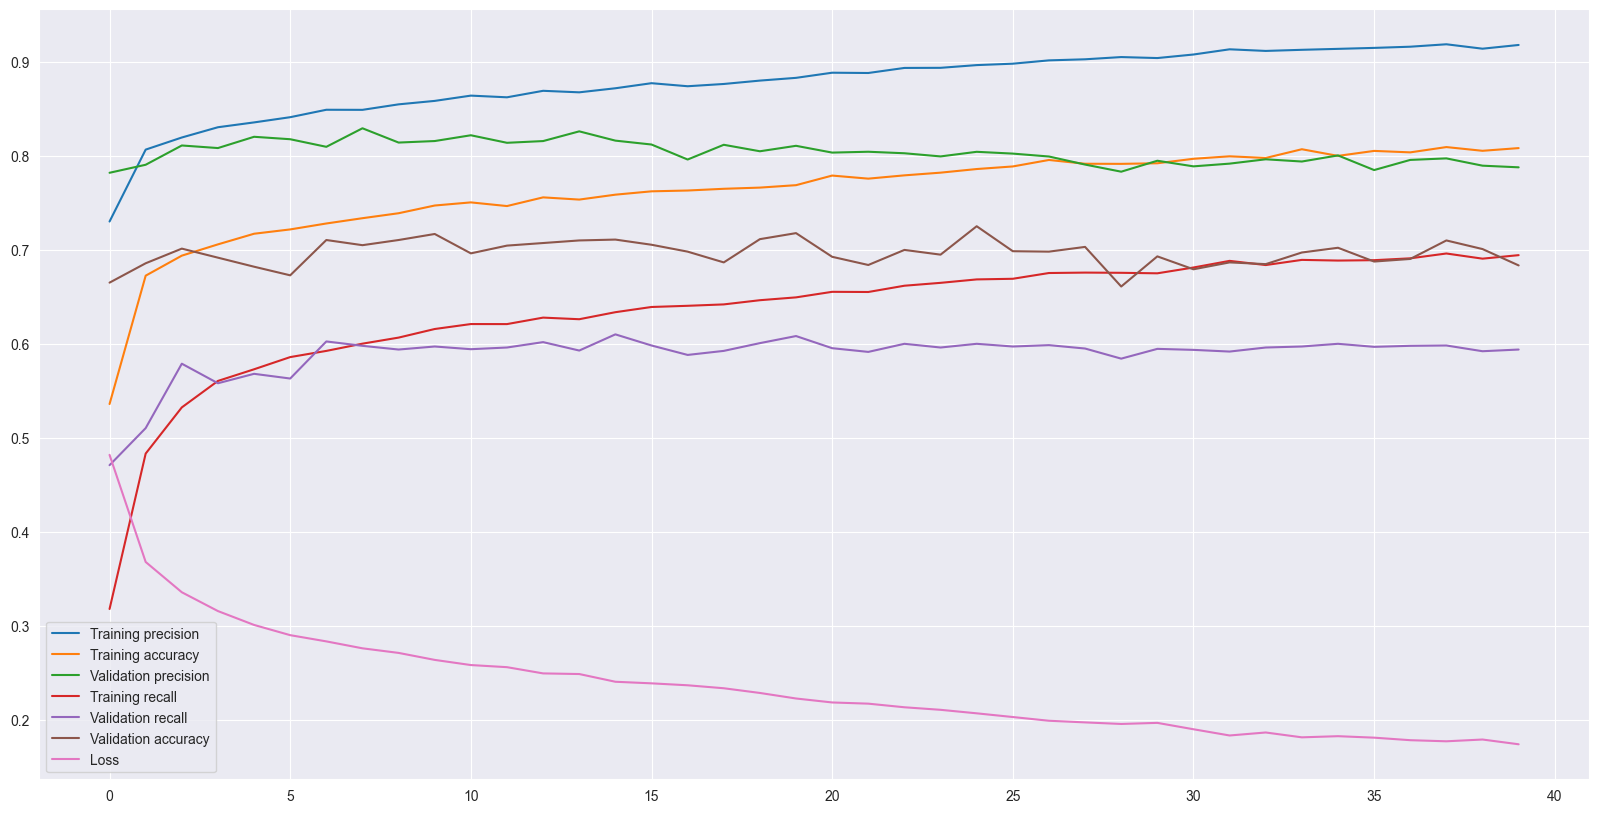

In [54]:
plt.figure(figsize=(20,10))
plt.plot(history.history['Precision'], label = 'Training precision')
plt.plot(history.history['categorical_accuracy'], label = 'Training accuracy')
plt.plot(history.history['val_Precision'], label = 'Validation precision')
plt.plot(history.history['Recall'], label = 'Training recall')
plt.plot(history.history['val_Recall'], label = 'Validation recall')
plt.plot(history.history['val_categorical_accuracy'], label = 'Validation accuracy')
plt.plot(history.history['loss'], label = 'Loss')
plt.legend()

In [57]:
modelCNN_residual_extra_features.save('modelCNN_residual_extra_features.keras') 

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Accuracy: 0.5696


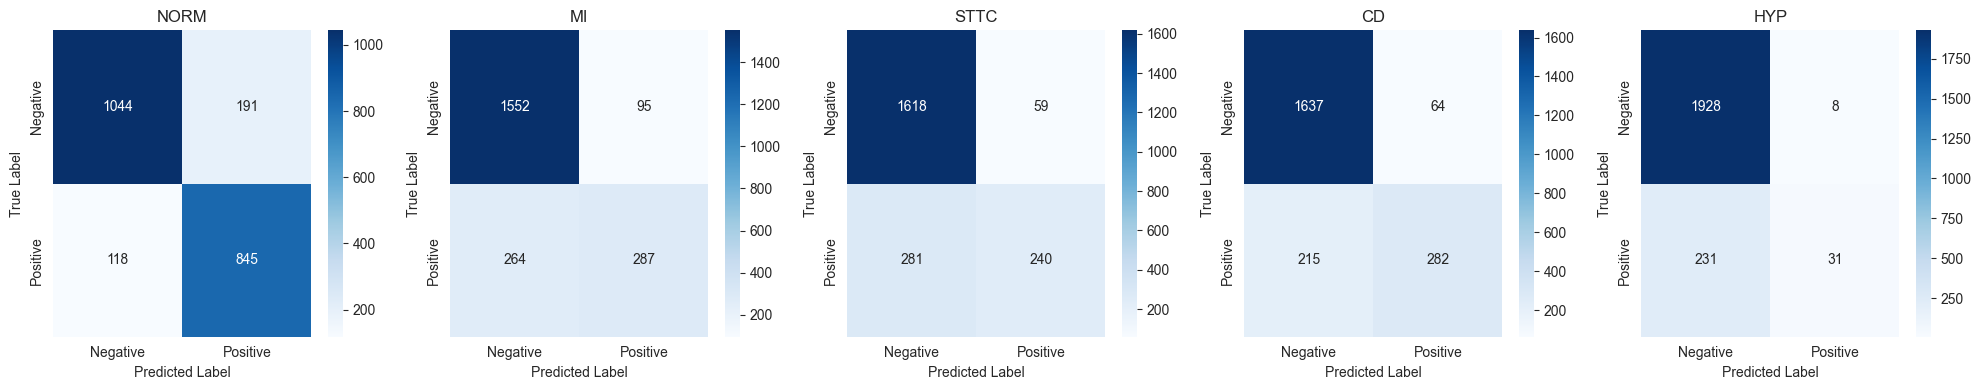

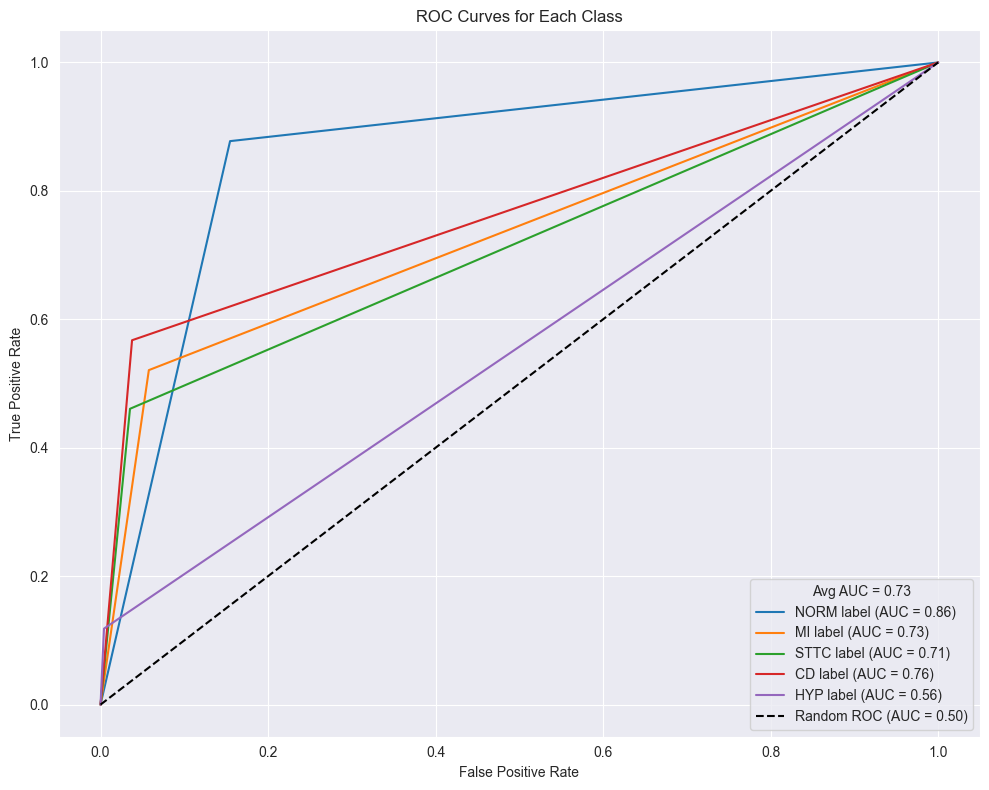

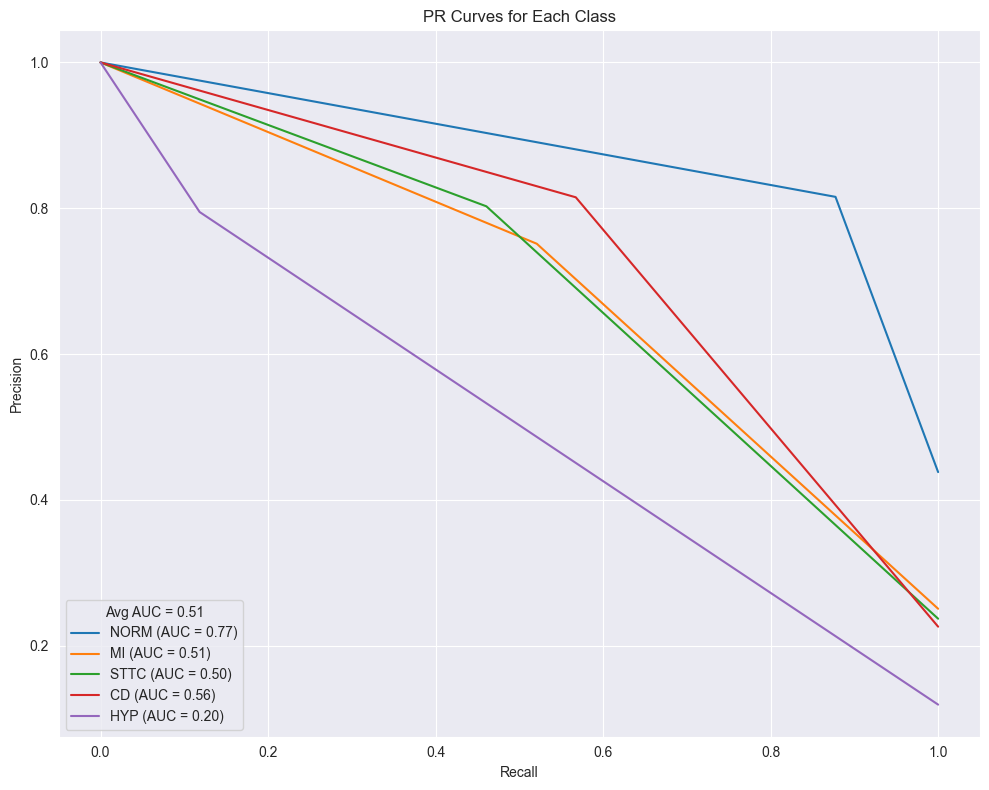

In [56]:
# Predecir en el conjunto de prueba
predictions = modelCNN_residual_extra_features.predict([combined_feat_test, ecg_test])

# Evaluar el modelo (puedes ajustar la métrica según lo que necesites)
pred_labels = (predictions >= threshold).astype(int)
accuracy = accuracy_score(labels_test, pred_labels)

print(f'Accuracy: {accuracy:.4f}')

plot_five_classes_cm(labels_test, pred_labels, label_classes)
_ = plot_five_classes_roc(np.array(labels_test), pred_labels, label_classes)
plot_five_classes_pr(np.array(labels_test), pred_labels, label_classes)

After the evaluation of the performance of the model, the addition of these new features did not suppose any improvement on the resuls of the classification. Nevertheless, it would be appealing to use these new features in the future on the median beats model as a support of the lost information on the median beats computation, specially the T-P distance.

### Using a VAE as a feature extractor

Finally, I decided to explore the use of VAEs in the ECG classification. This process is developped in two steps: firstly, the VAE is trained unsupervisedly and later the signals are compressed on the latent space and those reduced signals are used as features for a classifier training. This model can potentially leverage the ECG clasfication as it presents the following advantages:
* **Unsupervised Learning**: The lack of highly trustworthy labelled data is scarce and a very recurrent problem in health data. The use of VAEs can potentially avoid this issue as it allow as to use high amount of unlabled or poorly labelled data on the unsupervised first step and save the reduced reliable labelled data for the second training. 
* **High explainablity**: As the VAE can encode and the decode easily from the latent space, the specific latent dimensions that are categorized by the classifier as relevant can be easily studied. This is due to the fact that the information carried out by those latent features can be extracted by encoding examples ECGs, and reconstruct them with slight variations on the specific latent dimensions and fixing the other ones.

In [152]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding the 12-leads ECG signal."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [153]:
def encoder_model(train_data, number_latent_dimensions=16):
    encoder_inputs = tf.keras.Input(shape=(train_data.shape[1:]))
    
    # Primera capa Conv1D
    x = keras.layers.Conv1D(32, 5, strides=1, padding='same')(encoder_inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

    # Segunda capa Conv1D
    x = keras.layers.Conv1D(64, 5, strides=1, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

    # GlobalAveragePooling1D to reduce temporal dimension
    x = keras.layers.GlobalAveragePooling1D()(x)

    # Dense layers to create latent space
    x = keras.layers.Dense(64, activation="relu")(x)
    x = keras.layers.Dense(32, activation="relu")(x)

    # Now we generate the latent space of mean and log-variance
    z_mean = keras.layers.Dense(number_latent_dimensions, name="z_mean")(x)
    z_log_var = keras.layers.Dense(number_latent_dimensions, name="z_log_var")(x)

    # Sample from these distributions
    z = Sampling()([z_mean, z_log_var])
    
    encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder


In [191]:
def decoder_model(normal_train_data, number_latent_dimensions = 16):
    
    latent_inputs = tf.keras.Input(shape=(number_latent_dimensions,))
    # Expand dimensions to match the input shape expected by Conv1DTranspose
    x = layers.Dense(number_latent_dimensions * 4, activation="relu")(latent_inputs)
    x = layers.Dense(number_latent_dimensions * 24, activation="relu")(latent_inputs)
    x = layers.Reshape((12,number_latent_dimensions*2))(x)
    
    # Adding Conv1DTranspose layers for upsampling
    x = keras.layers.Conv1DTranspose(64, kernel_size=5, strides=1, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    
    decoder_outputs = keras.layers.Conv1DTranspose(120, kernel_size=5, strides=1, padding='same')(x)
    decoder_outputs = keras.layers.Permute((2, 1))(decoder_outputs)
    
    decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
    return decoder


In [192]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(data, reconstruction)
            )
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [193]:
N_latent_dimensions = 16

encoder = encoder_model(beats_train, N_latent_dimensions)
decoder = decoder_model(beats_train, N_latent_dimensions)

# Get the combined model
vae = VAE(encoder, decoder)

# Compile the model
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.summary()

Model: "vae_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ [(None, 16), (None,    │        19,936 │
│                                 │ 16), (None, 16)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 120, 12)        │        55,608 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,544 (295.09 KB)

 Trainable params: 75,224 (293.84 KB)

 Non-trainable params: 320 (1.25 KB)

In [194]:
# Fit the model to the training set
history = vae.fit(beats_train, beats_train, epochs=80, batch_size=128, shuffle=True)

Epoch 1/80
137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - kl_loss: 0.0146 - loss: -0.9581 - reconstruction_loss: -0.9727
Epoch 2/80
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - kl_loss: 0.0070 - loss: -1.1310 - reconstruction_loss: -1.1380
Epoch 3/80
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - kl_loss: 0.0142 - loss: -1.2726 - reconstruction_loss: -1.2868
Epoch 4/80
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - kl_loss: 0.0372 - loss: -1.4660 - reconstruction_loss: -1.5032
Epoch 5/80
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - kl_loss: 0.0336 - loss: -1.6166 - reconstruction_loss: -1.6502
Epoch 6/80
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - kl_loss: 0.0285 - loss: -1.7040 - reconstruction_loss: -1.7324
Epoch 7/80
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - kl_loss: 0.0285 - loss: -1.7689 - reconstruction_loss: -1.7974
Epoch 8/80
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - kl_loss: 0.0223 - loss: -1.7891 - reconstruction_loss: -1.8114
Epoch 9/80
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - k

Text(0.5, 0, 'Time (ms)')

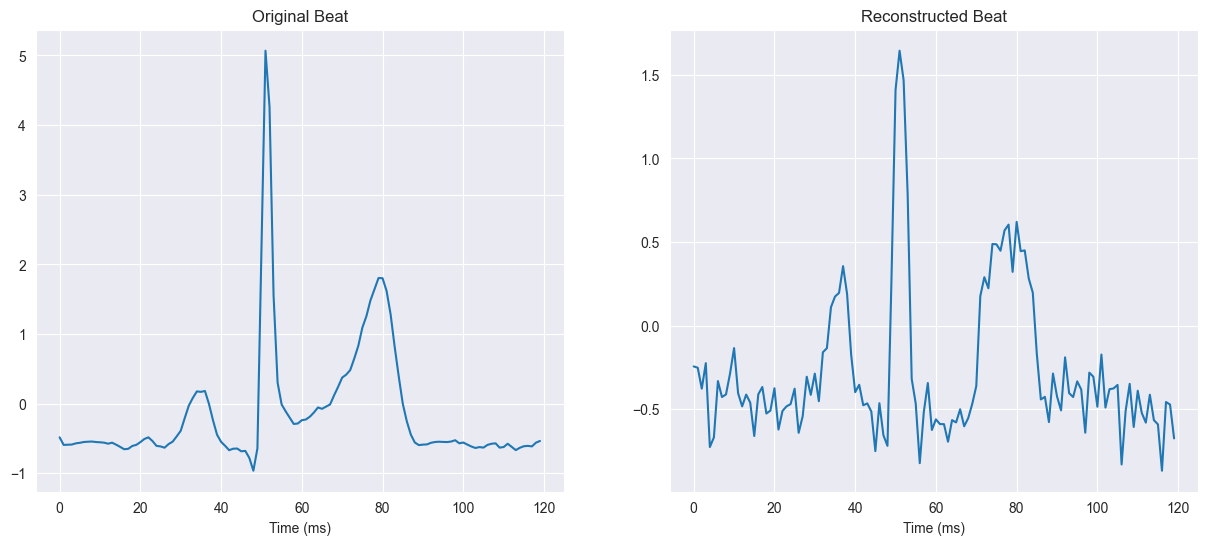

In [263]:
example_beat = beats_test[3,:,:]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))  # Adjust figsize as needed

axs[0].plot(example_beat[:, 1])
axs[0].set_title('Original Beat')
axs[0].set_xlabel('Time (ms)')


example_beat = np.expand_dims(example_beat, axis=0)
z_mean, z_log_var, encoded_beat = vae.encoder(example_beat)
reconstructed_beat = vae.decoder(encoded_beat).numpy()
reconstructed_beat = np.squeeze(reconstructed_beat)

axs[1].plot(reconstructed_beat[:,1])
axs[1].set_title('Reconstructed Beat')
axs[1].set_xlabel('Time (ms)')



The plot above corresponds to an example one lead median beat and its corresponding reconstruction. While the signal is not exaclty the same, the beat patterns are maintained during the process. These results can be easily improved with more time for studing more complex architectures to adjust the model to our particular problem, but that requires long periods of time of model studying that I lack in these circunstances. 

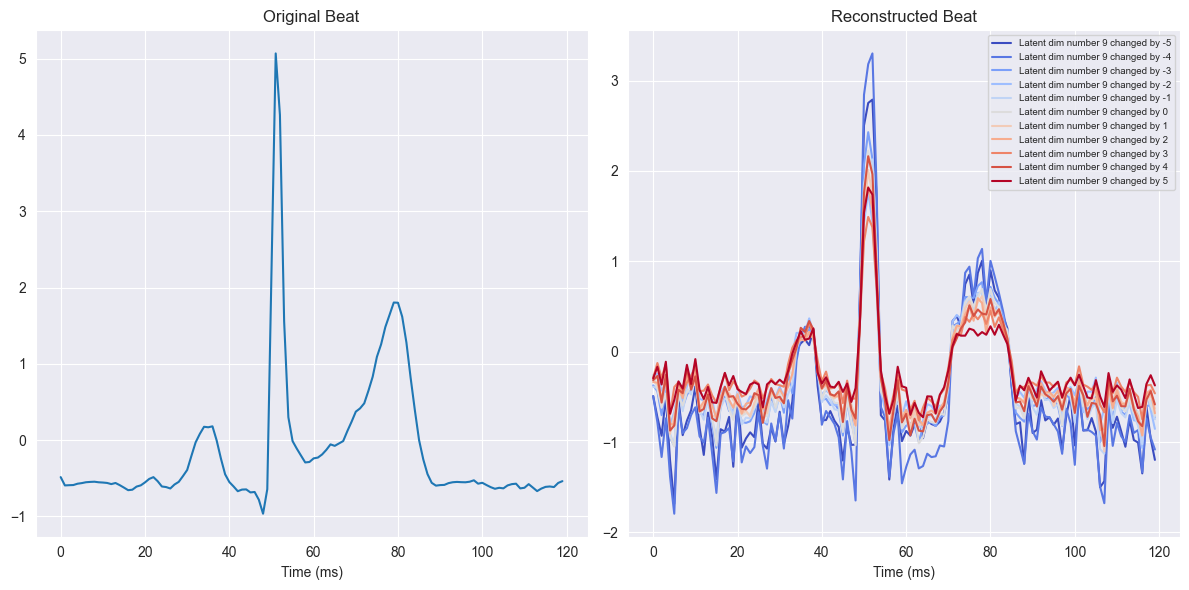

In [265]:
cmap = cm.get_cmap('coolwarm')

example_beat = beats_test[3, :, :]
values = np.arange(-5, 6)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))  # Adjust figsize as needed

axs[0].plot(example_beat[:, 1])
axs[0].set_title('Original Beat')
axs[0].set_xlabel('Time (ms)')

example_beat = np.expand_dims(example_beat, axis=0)
latent_dim = 9

for i in values:
    z_mean, z_log_var, encoded_beat = vae.encoder(example_beat)
    
    encoded_beat_np = encoded_beat.numpy()
    encoded_beat_np[0, latent_dim] = encoded_beat_np[0, latent_dim] + i
    modified_encoded_beat = tf.convert_to_tensor(encoded_beat_np)
    
    reconstructed_beat = vae.decoder(modified_encoded_beat).numpy()  # Use modified_encoded_beat
    reconstructed_beat = np.squeeze(reconstructed_beat)
    
    color = cmap((i - values.min()) / (values.max() - values.min()))
    axs[1].plot(reconstructed_beat[:, 1], label=f'Latent dim number {latent_dim} changed by {i}', color=color, alpha=1.0)

axs[1].set_title('Reconstructed Beat')
axs[1].set_xlabel('Time (ms)')

axs[1].legend(fontsize='x-small', loc='upper right')

plt.tight_layout()
plt.show()


The plot from above corresponds to the explainability characteristic that I explained before. Taking as an example the latent dimension number 9, its value on the encoded signal was slightly modified on range from -5 to 5 to see the impact of this dimension of the beat pattern.

In [266]:
_, _, encoded_beats_train = vae.encoder(beats_train)
encoded_beats_train = np.array(encoded_beats_train)
_, _, encoded_beats_test = vae.encoder(beats_test)
encoded_beats_test = np.array(encoded_beats_test)


Accuracy: 0.1583


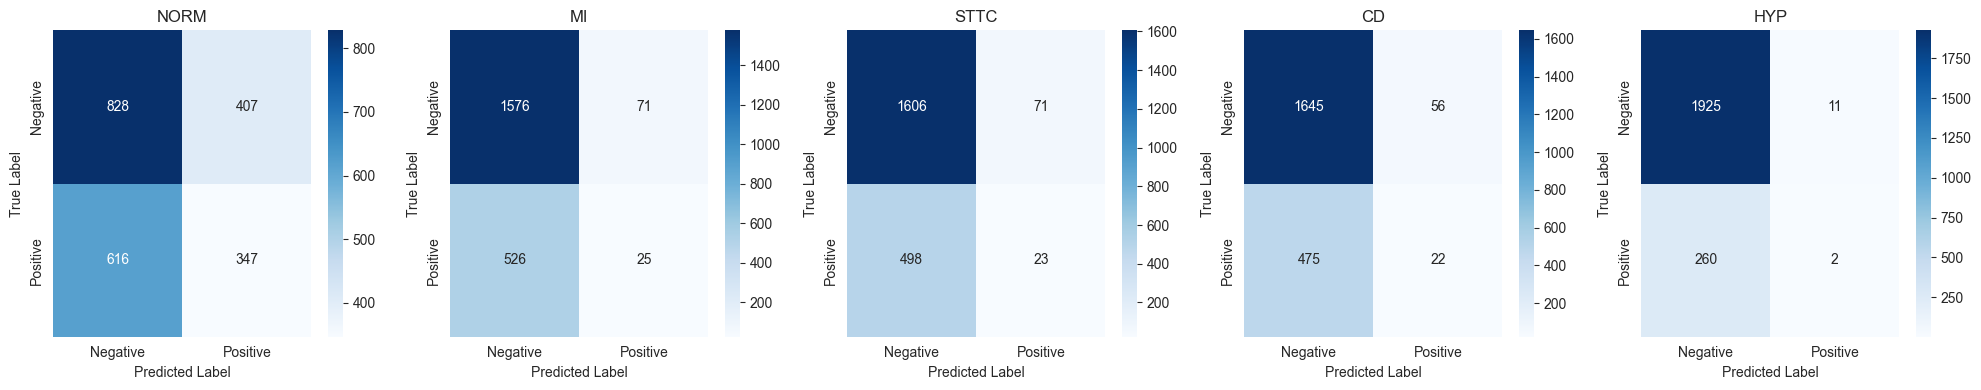

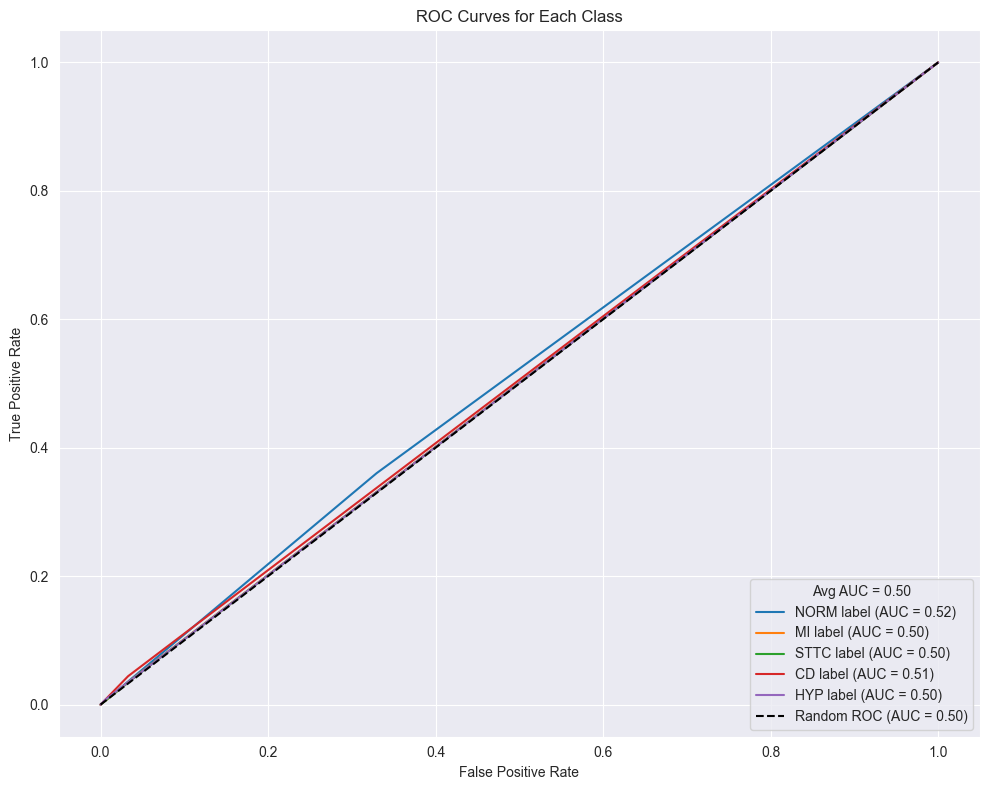

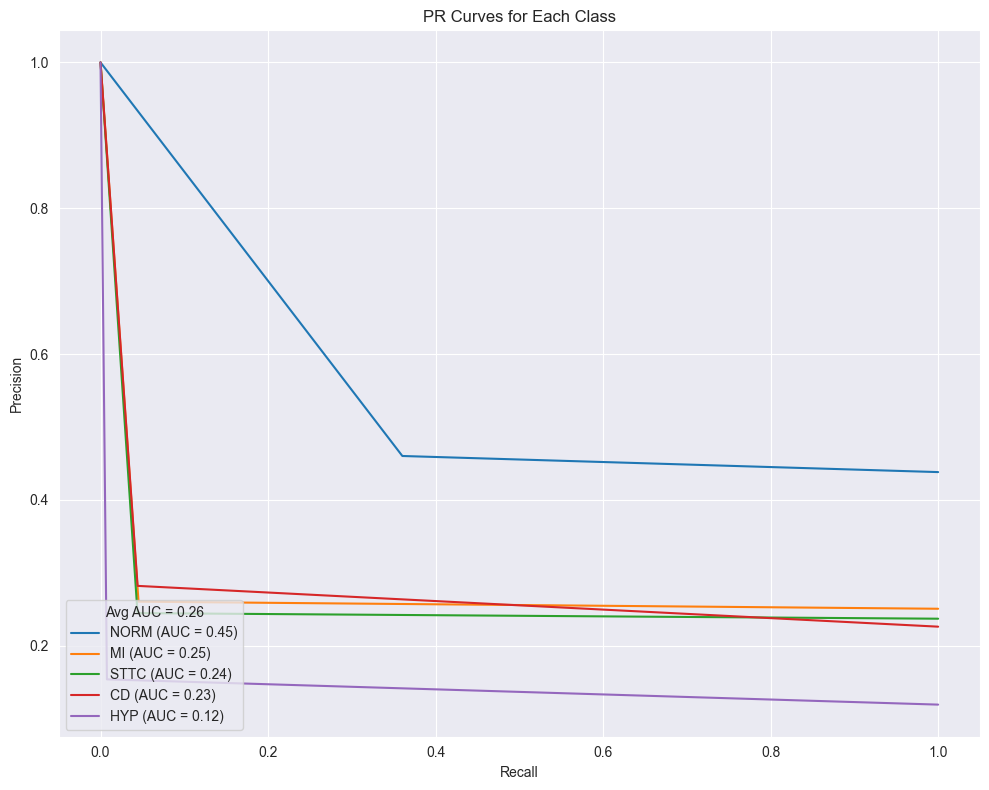

In [272]:
model = MultiOutputClassifier(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'))

model.fit(encoded_beats_train, labels_train)

predictions = model.predict(encoded_beats_test)

accuracy = accuracy_score(labels_test, predictions)

print(f'Accuracy: {accuracy:.4f}')

plot_five_classes_cm(labels_test, predictions, label_classes)
_ = plot_five_classes_roc(np.array(labels_test), predictions, label_classes)
plot_five_classes_pr(np.array(labels_test), predictions, label_classes)

Even though the results of this model are not as good as desired, it has a lot of promise. As shown in the literature, in depth analysis and development of this process can lead to better results compared to the ones we have obtained. 

Additonally, the unsupervised nature of the first step of the model can potentailly avoid the huge challenge that is the lack of reliable labelled health data, while its explainablity make the model more understandable to experts, thus making the AI closer to a user-friendly reliable tool in the cardio field. 

## Conclusions

In this work, several strategies were followed. The lack of time and computational cost has an important impact on the results as only a superfical analysis of the methods employed was carried out. Nevertehless, a lot of potential paths to follow were analysed to be explored in the future with very high promises.